# Jung Microglia Analysis

In [1]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = "jenhantao@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib_venn
import matplotlib.pyplot as plt 
import seaborn as sns
from collections import Counter
sys.setrecursionlimit(3000)
import pickle
from sklearn import preprocessing
import time
sns.set_context('talk')

/home/jtao/software/anaconda3/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Preprocessing

In [3]:
workingDirectory = '/home/jtao/analysis/jung_microglia_analysis/'
os.chdir(workingDirectory)

In [4]:
%%capture
!summarize_logs.py atac ./qc_atac ./tag_directories_atac/*/

In [5]:
summary_atac_frame = pd.read_csv('./qc_atac/mapping_stats.tsv', sep='\t')
summary_atac_frame['genome'] = 'mm10'
sample_names = summary_atac_frame['sample'].values
summary_atac_frame['cell'] = [x.split('_')[1] for x in sample_names]
summary_atac_frame['date'] = [x.split('_')[3] for x in sample_names]
summary_atac_frame['treatment'] = [x.split('_')[2] for x in sample_names]

In [5]:
# filter samples according to threshold for the fraction of uniquely mapped reads
mappedFractionThreshold = 0.0
uniquelyMappedReadThreshold = 0

filtered_summary_atac_frame = summary_atac_frame.copy()
# # filter on fraction of mapped reads
# filtered_summary_atac_frame = filtered_summary_atac_frame[filtered_summary_atac_frame['mappedFraction'] >= mappedFractionThreshold]
# # filter on total mapped reads
# filtered_summary_atac_frame = filtered_summary_atac_frame[filtered_summary_atac_frame['uniquelyMappedReads'] >= uniquelyMappedReadThreshold]

# get samples that were discarded
discardedSampleNames = [x for x in summary_atac_frame['sample'].values if not x in filtered_summary_atac_frame['sample'].values]
discarded_summary_atac_frame = summary_atac_frame[summary_atac_frame['sample'].isin(discardedSampleNames)]
print("Number of Samples:", summary_atac_frame.shape[0])
print("Number of discarded samples:",discarded_summary_atac_frame.shape[0])
print("Number of Samples remaining after filtering:", filtered_summary_atac_frame.shape[0])

# generate simplified name for naming output files
factorTreatment_count_dict = {} #{factor-treatment:count}
simplifiedNames = []
for simpleNameRoot in list((filtered_summary_atac_frame['cell'] 
                            + '_' + filtered_summary_atac_frame['treatment'] 
                            + '_' + filtered_summary_atac_frame['date']).values):
    if not simpleNameRoot in factorTreatment_count_dict:
        factorTreatment_count_dict[simpleNameRoot] = 1
    else:
        factorTreatment_count_dict[simpleNameRoot] += 1
    simplifiedName = (simpleNameRoot + '_' + str(factorTreatment_count_dict[simpleNameRoot])).lower()
    simplifiedNames.append(simplifiedName)

filtered_summary_atac_frame["simplifiedName"] = simplifiedNames

originalName_simpleName_dict = dict(zip(filtered_summary_atac_frame['sample'].values,
                                       filtered_summary_atac_frame['simplifiedName'].values))
simpleName_originalName_dict = dict(zip(filtered_summary_atac_frame['simplifiedName'].values,
                                       filtered_summary_atac_frame['sample'].values))


Number of Samples: 12
Number of discarded samples: 0
Number of Samples remaining after filtering: 12


In [6]:
# %%capture 
# suppress output - this can be saved to a variable (like a log file)

### call peaks ###
# iterate through each individual file
peakDirectory = workingDirectory + '/' + 'atac_peak_files'

if not os.path.exists(peakDirectory):
    os.makedirs(peakDirectory)

# make peak files with simplified names
# filteredSamples = list(filtered_mappingStats_frame['sampleName'].values)
scriptFile1 = open('./peakCalling_homer_idr.sh', 'w')
scriptFile2 = open('./peakCalling_homer.sh', 'w')

atacTagDirPath = './tag_directories_atac/'
for tagDir in filtered_summary_atac_frame['sample'].values:
    # call peaks only for experiments that passed thresholding

    peakFileName1 = originalName_simpleName_dict[tagDir] + "_peaks.tsv"
    peakFileName2 = originalName_simpleName_dict[tagDir] + "_default_peaks.tsv"

    scriptFile1.write('findPeaks ' + atacTagDirPath + '/' + tagDir 
                     + ' -L 0 -C 0 -fdr 0.9' 
                     + ' -style factor -size 150  > ' + 
                     peakDirectory + '/' + peakFileName1 + ' &\n')
    scriptFile2.write('findPeaks ' + atacTagDirPath + '/' + tagDir
                 + ' -style factor -size 150 > ' + 
                 peakDirectory +'/' + peakFileName2 + ' &\n')
scriptFile1.close()
scriptFile2.close()


In [ ]:
%%bash
rm ./atac_peak_files/*
chmod a+x ./*sh
bash ./peakCalling_homer_idr.sh

In [34]:
idrDirectory = './atac_idr/'
scriptFile = open('./run_idr.sh', 'w')
!rm ./atac_idr/*

! if [ ! -d $idrDirectory ]; then mkdir $idrDirectory; fi
replicateIndices = []


# homer peaks
counter = 0
for cellType in sorted(set(filtered_summary_atac_frame['cell'])):
    for treatment in sorted(set(filtered_summary_atac_frame['treatment'])):
        
        samples = filtered_summary_atac_frame[(filtered_summary_atac_frame['treatment'] == treatment) &
                                              (filtered_summary_atac_frame['cell'] == cellType)
                                             ]['simplifiedName'].values
        print(treatment, samples)
        for i in range(len(samples) - 1):
            for j in range(i+1, len(samples)):
                counter += 1
                sample1 = samples[i]
                sample2 = samples[j]
                peakFile1 = peakDirectory + '/' + sample1 + '_peaks.tsv'
                peakFile2 = peakDirectory + '/' + sample2 + '_peaks.tsv'

                # determine IDR threshold based on number of peaks
                # https://sites.google.com/site/anshulkundaje/projects/idr
                with open(peakFile1) as f:
                    data = f.readlines()
                len_1 = len(data)
                with open(peakFile2) as f:
                    data = f.readlines()
                len_2 = len(data)
                max_length = max(len_1, len_2)
                print(peakFile1, peakFile2, max_length)
                commandString = ' '.join(['python /home/jtao/code/seq_merge_pipe/run_idr_homerPeaks.py',
                                         peakFile1,
                                         peakFile2,
                                         idrDirectory])
                if max_length > 150000 + 35: # 35 is the number of header rows in peak files
                    commandString += " -threshold 0.02"
                else: 
                    commandString += " -threshold 0.05"            
                if not counter % 12 == 0:
                    commandString += ' &'
                scriptFile.write(commandString + '\n')
scriptFile.close()

rm: cannot remove ‘./atac_idr/*’: No such file or directory
LPS ['cd451_lps_1_1' 'cd451_lps_2_1' 'cd451_lps_3_1']
/home/jtao/analysis/jung_microglia_analysis//atac_peak_files/cd451_lps_1_1_peaks.tsv /home/jtao/analysis/jung_microglia_analysis//atac_peak_files/cd451_lps_2_1_peaks.tsv 184367
/home/jtao/analysis/jung_microglia_analysis//atac_peak_files/cd451_lps_1_1_peaks.tsv /home/jtao/analysis/jung_microglia_analysis//atac_peak_files/cd451_lps_3_1_peaks.tsv 196348
/home/jtao/analysis/jung_microglia_analysis//atac_peak_files/cd451_lps_2_1_peaks.tsv /home/jtao/analysis/jung_microglia_analysis//atac_peak_files/cd451_lps_3_1_peaks.tsv 196348
nt ['cd451_nt_4_1' 'cd451_nt_5_1' 'cd451_nt_6_1']
/home/jtao/analysis/jung_microglia_analysis//atac_peak_files/cd451_nt_4_1_peaks.tsv /home/jtao/analysis/jung_microglia_analysis//atac_peak_files/cd451_nt_5_1_peaks.tsv 407097
/home/jtao/analysis/jung_microglia_analysis//atac_peak_files/cd451_nt_4_1_peaks.tsv /home/jtao/analysis/jung_microglia_analysis//a

In [19]:
%%bash
chmod a+x ./scratch/*
bash ./run_idr.sh

Performing IDR analysis on the following samples: /home/jtao/analysis/jung_microglia_analysis//atac_peak_files/cd452_lps_1_1_peaks.tsv, /home/jtao/analysis/jung_microglia_analysis//atac_peak_files/cd452_lps_2_1_peaks.tsv
Output files will be written to: ./atac_idr/
Using the following IDR threshold: 0.05
Peaks will be ranked using: findPeaks Score
Other available scoreColumns: ['Normalized Tag Count' 'focus ratio' 'findPeaks Score' 'Score']
idr --samples ./atac_idr//cd452_lps_1_1_peaks.narrowPeak ./atac_idr//cd452_lps_2_1_peaks.narrowPeak --output-file ./atac_idr//cd452_lps_1_1_peaks_cd452_lps_2_1_peaks_idr.out --plot --idr-threshold 0.05 &
Performing IDR analysis on the following samples: /home/jtao/analysis/jung_microglia_analysis//atac_peak_files/cd451_lps_2_1_peaks.tsv, /home/jtao/analysis/jung_microglia_analysis//atac_peak_files/cd451_lps_3_1_peaks.tsv
Output files will be written to: ./atac_idr/
Using the following IDR threshold: 0.05
Peaks will be ranked using: findPeaks Score
O

chmod: cannot access ‘./scratch/*’: No such file or directory
Initial parameter values: [0.10 1.00 0.20 0.50]
Initial parameter values: [0.10 1.00 0.20 0.50]
Initial parameter values: [0.10 1.00 0.20 0.50]
Initial parameter values: [0.10 1.00 0.20 0.50]
Initial parameter values: [0.10 1.00 0.20 0.50]
Initial parameter values: [0.10 1.00 0.20 0.50]
Initial parameter values: [0.10 1.00 0.20 0.50]
Initial parameter values: [0.10 1.00 0.20 0.50]
Initial parameter values: [0.10 1.00 0.20 0.50]
Initial parameter values: [0.10 1.00 0.20 0.50]
Initial parameter values: [0.10 1.00 0.20 0.50]
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [2.03 1.46 0.92 0.64]
Final parameter values: [2.05 1.45 0.92 0.64]
Final parameter values: [2.16 1.49 0.93 0.66]
Number of reported peaks - 44906/84459 (53.2%)

Number of peaks passing IDR cutoff of 0.05 - 44906/84459 (53.2%)

Number of reported peaks - 45502/84413 (53.9%)

Number of peaks passing IDR cutoff of 0.05 - 45502/84413 (53.9

In [53]:
# pick the IDR results that have the most peaks
idrDirectory = './atac_idr/'
treatment_bestIDR_dict = {}
treatment_peakNumber_dict = {}
for p in os.listdir(idrDirectory):
    if 'idr.tsv' in p:
        with open (idrDirectory + '/' + p) as f:
            data = f.readlines()
        numPeaks = len(data) - 1
        treatment = '_'.join(p.split('_')[:2])
        if treatment in treatment_peakNumber_dict:
            if treatment_peakNumber_dict[treatment] < numPeaks:
                treatment_peakNumber_dict[treatment] = numPeaks
                treatment_bestIDR_dict[treatment] = p
        else:
            treatment_peakNumber_dict[treatment] = numPeaks
            treatment_bestIDR_dict[treatment] = p

In [55]:
outFile = open('./best_samples.tsv','w')
if not os.path.isdir('./atac_idr_peaks/'):
    os.mkdir('./atac_idr_peaks/')
else:
    for f in os.listdir('./atac_idr_peaks/'):
        os.remove('./atac_idr_peaks/' + f)
for key in sorted(treatment_bestIDR_dict.keys()):
    p = treatment_bestIDR_dict[key]
    tokens = p.split('_')
    strain = tokens[0]
    treatment = tokens[1]
    sample1 = simpleName_originalName_dict['_'.join(tokens[:4])]
    sample2 = simpleName_originalName_dict['_'.join(tokens[5:9])]
    outFile.write('\t'.join([strain, treatment, sample1, sample2, str(treatment_bestIDR_dict[key]),'\n']))
    print('\t'.join([strain, treatment, sample1, sample2, str(treatment_bestIDR_dict[key])]))

    if treatment_bestIDR_dict[key]:
        outpath = './atac_idr_peaks/' + '_'.join([strain, treatment]) + '_peaks.tsv'
        !cp $idrDirectory/$p $outpath
outFile.close()





cd451	lps	AS_CD451_LPS_1	AS_CD451_LPS_3	cd451_lps_1_1_peaks_cd451_lps_3_1_peaks_idr.tsv
cd451	nt	AS_CD451_nt_4	AS_CD451_nt_5	cd451_nt_4_1_peaks_cd451_nt_5_1_peaks_idr.tsv
cd452	lps	AS_CD452_LPS_2	AS_CD452_LPS_3	cd452_lps_2_1_peaks_cd452_lps_3_1_peaks_idr.tsv
cd452	nt	AS_CD452_nt_5	AS_CD452_nt_6	cd452_nt_5_1_peaks_cd452_nt_6_1_peaks_idr.tsv


## ATAC TBA

#### Create script to run model

In [56]:
%%bash
# delete the existing script file
rm ./run_tba.sh
# create a script file
touch ./run_tba.sh

# if directories don't exist, create them
if [ ! -d ./bed_files/ ]; then mkdir ./bed_files; fi
if [ ! -d ./peak_sequences/ ]; then mkdir ./peak_sequences; fi
if [ ! -d ./background_files/ ]; then mkdir ./background_files; fi
if [ ! -d ./tba_output/ ]; then mkdir ./tba_output; fi

# for each peak file create several commands
for peak_file in ./atac_idr_peaks/*;

# generate name of bed file
do bed_file=${peak_file/tsv/bed};
bed_file=${bed_file/atac_idr_peaks/bed_files}
# call Homer pos2bed.pl to create bed file
echo "pos2bed.pl $peak_file > $bed_file" >> ./run_tba.sh

# generate peak sequence fasta file name
seq_file=${bed_file/peaks.bed/peaks.fasta};
seq_file=${seq_file/bed_files/peak_sequences};

# execute command to extract sequences
echo "/home/jtao/code/tba/model_training/extract_sequences.py $bed_file mm10 $seq_file">> ./run_tba.sh

# generate background coordinates
echo "/home/jtao/code/tba/model_training/generate_background_coordinates.py $bed_file mm10 ./background_files/">> ./run_tba.sh

# rename background file
bg_seq_file=${seq_file/peak_sequences/background_files};
bg_seq_file=${bg_seq_file/peaks.fasta/background.fasta};
echo "mv ./background_files/background.fasta $bg_seq_file">> ./run_tba.sh
echo "/home/jtao/code/tba/model_training/create_features.py -num_procs 40 $seq_file $bg_seq_file ./tba_output /home/jtao/code/tba/default_motifs/*">> ./run_tba.sh

# calculate motif scores for peaks and background
combined_features=${seq_file/peak_sequences/tba_output}
combined_features=${combined_features/.fasta/_combined_features.tsv}
labels=${combined_features/combined_features.tsv/labels.txt}
echo "/home/jtao/code/tba/model_training/train_classifier.py $combined_features $labels ./tba_output/">> ./run_tba.sh
coeff_path=${combined_features/combined_features.tsv/coefficients.tsv}
performance_path=${combined_features/combined_features.tsv/performance.tsv}
echo "mv ./tba_output/coefficients.tsv $coeff_path">> ./run_tba.sh
echo "mv ./tba_output/performance.tsv $performance_path">> ./run_tba.sh

# perform insilico mutagenesis
echo "/home/jtao/code/tba/model_training/calc_feature_significance.py -num_iterations 5 -num_procs 12 $combined_features $labels ./tba_output/">> ./run_tba.sh
significance_path=${combined_features/combined_features.tsv/significance.tsv}
echo mv ./tba_output/significance.tsv $significance_path>> ./run_tba.sh

done

### read in weight values

In [7]:
sample_weights_dict = {}
for f in os.listdir('./tba_output/'):
    if 'coefficients' in f and not 'gene' in f:
        # read in coefficients
        frame = pd.read_csv('./tba_output/' + f, sep='\t', index_col=0)
        # take the mean across cross validation iterations
        mean_weights = frame.mean(axis=1)
        sample = '_'.join(f.split('_')[0:2])
        sample_weights_dict[sample] = mean_weights
# create data frame
mean_weights_frame = pd.DataFrame(sample_weights_dict, index = sample_weights_dict[list(sample_weights_dict.keys())[0]].index.values)
mean_weights_frame = mean_weights_frame[mean_weights_frame.isnull().max(axis=1) ==False]

### read in significance values

In [8]:
sample_pval_dict = {}
for f in os.listdir('./tba_output/'):
    if 'significance' in f and not 'gene' in f:
        # read in signifance values using pandas
        frame = pd.read_csv('./tba_output/' + f, sep='\t', index_col=0)
        # take the mean across cross validation iterations
        mean_pval = frame.mean(axis=1) 
        sample = '_'.join(f.split('_')[0:2])
        sample_pval_dict[sample] = mean_pval
# create data frame
mean_pval_frame = pd.DataFrame(sample_pval_dict, index = sample_pval_dict[list(sample_pval_dict.keys())[0]].index.values)
mean_pval_frame = mean_pval_frame[mean_pval_frame.isnull().max(axis=1) ==False]

### Plot all Motifs Significance values

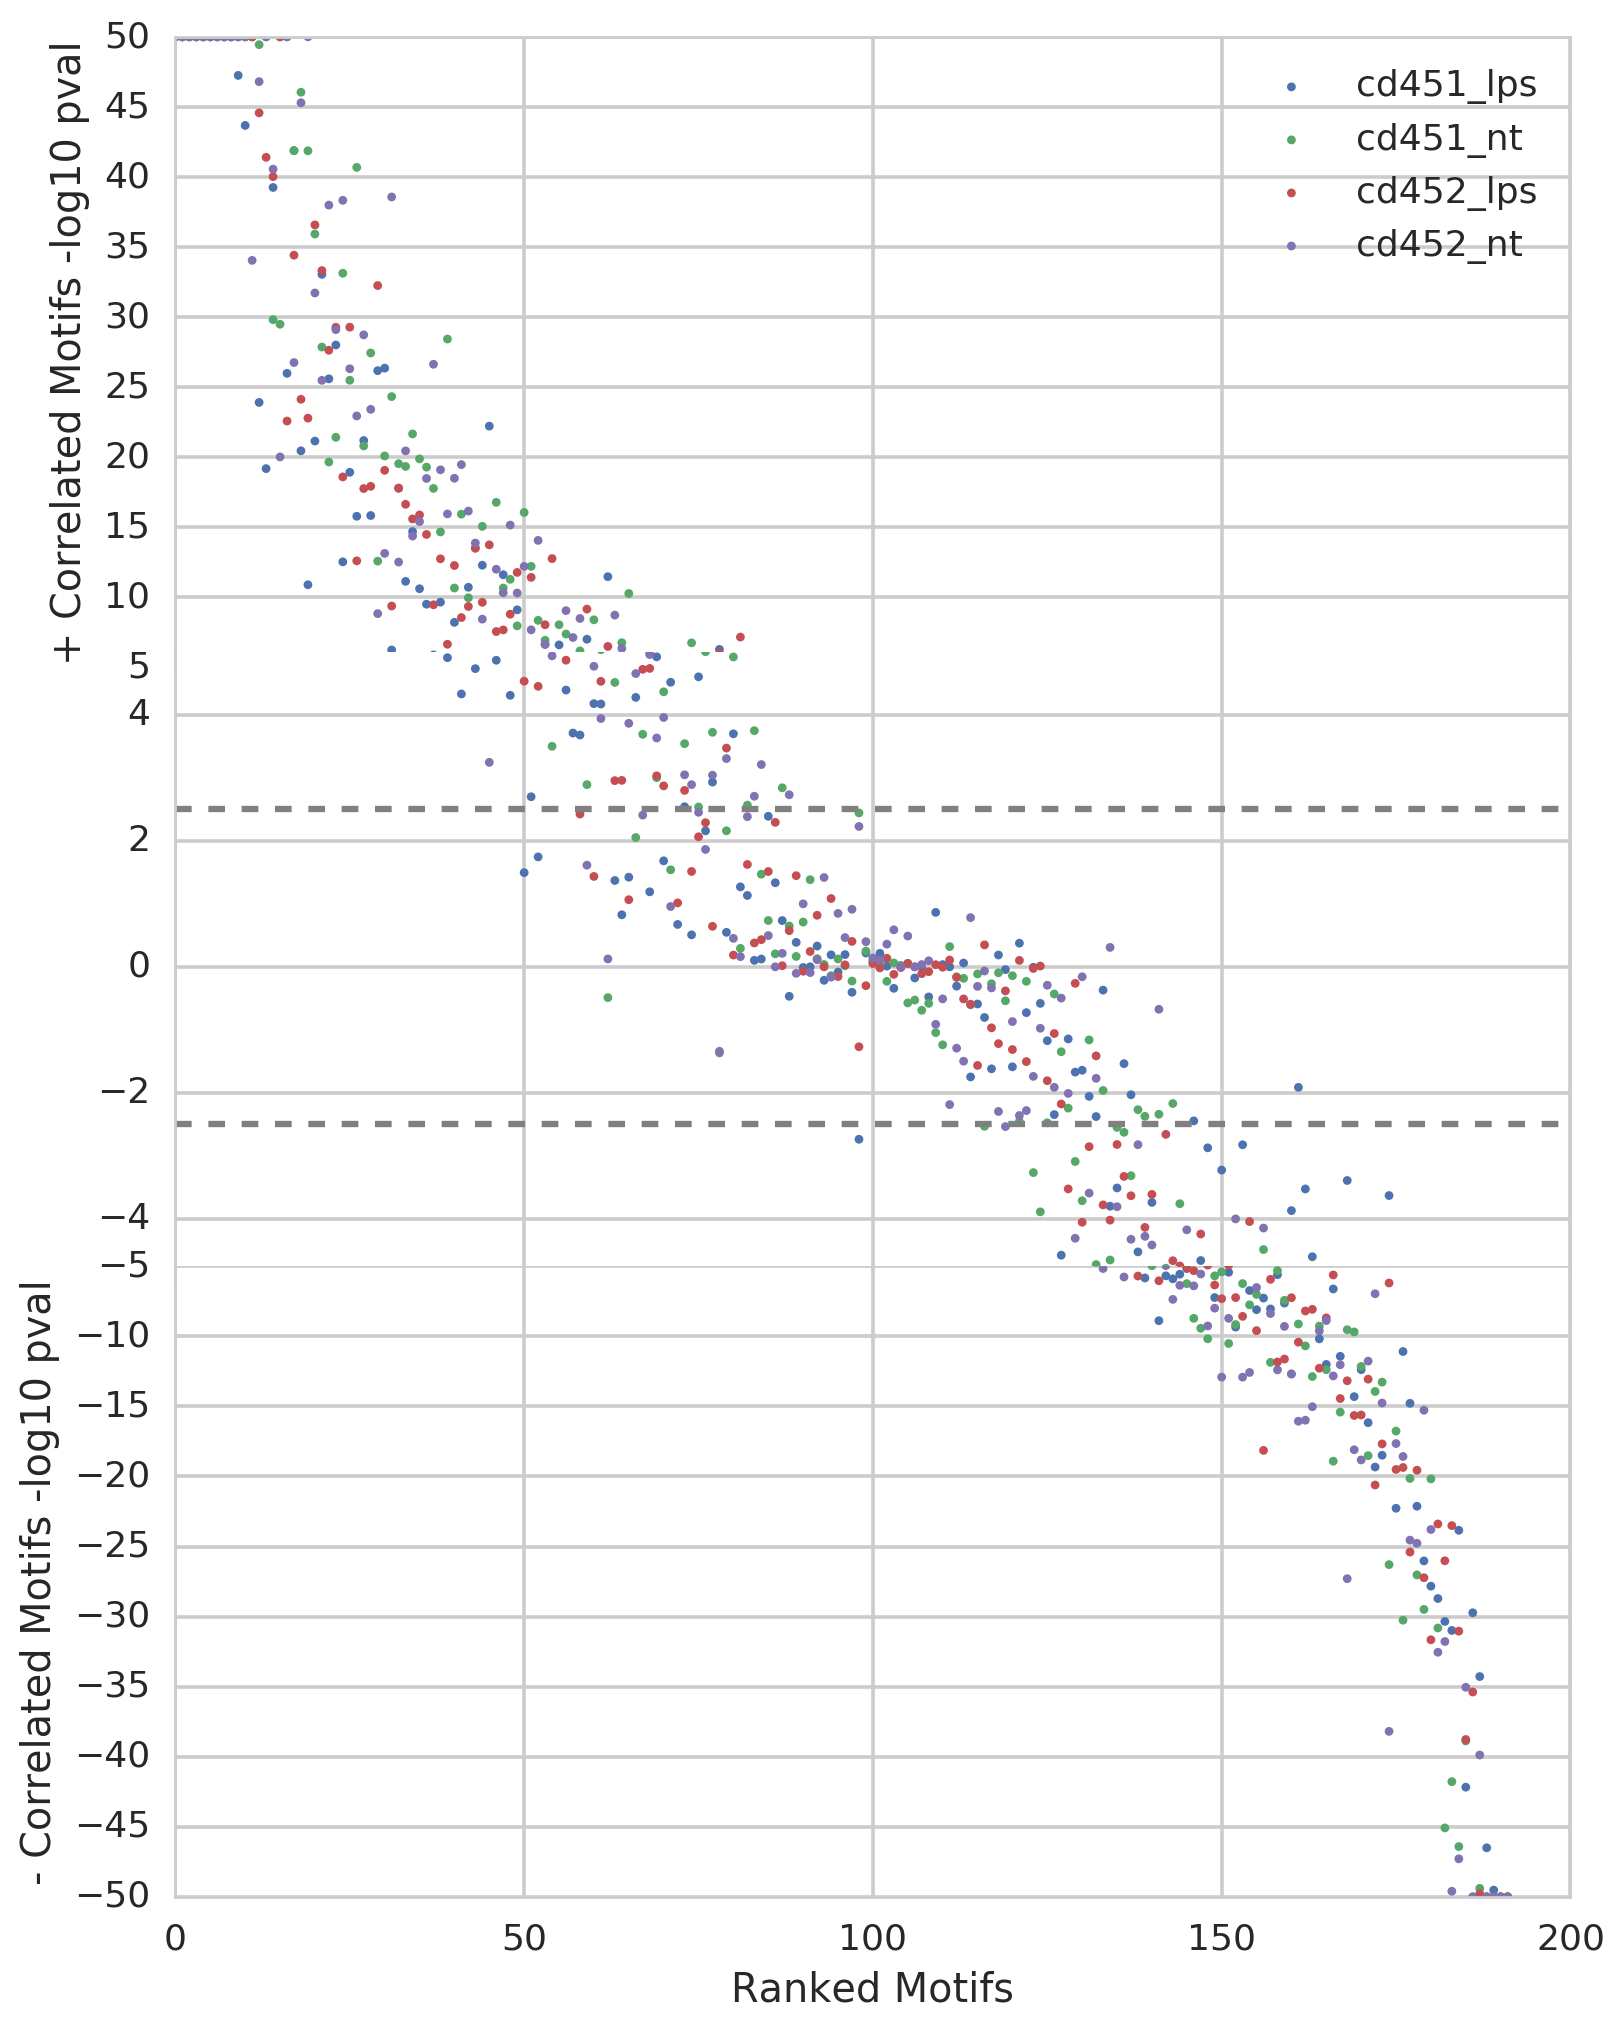

In [9]:
pseudocount = 1e-50 # set ceiling/floor for pvals
treatments = mean_pval_frame.columns
pval_threshold = 10**-2.5 # position of the dashed lines
treatment_orientedPvals_dict = {}
for treatment in treatments:
    pvals = mean_pval_frame[treatment]
    weights = mean_weights_frame[treatment]
    # calculate logpvals and assign direction according to weight
    oriented_pvals = [np.log10(x[0] +pseudocount) if x[1] < 0 else -np.log10(x[0]+pseudocount) for x in zip(pvals, weights)]
    treatment_orientedPvals_dict[treatment] = oriented_pvals

    # create data frame and sort according to mean
frame = pd.DataFrame(treatment_orientedPvals_dict, index = mean_pval_frame.index.values)
frame['mean'] = frame.mean(axis=1)
frame.sort_values('mean', ascending = False, inplace=True)
frame.drop('mean', axis=1, inplace=True)

colors = sns.color_palette()
counter = 0
with sns.axes_style('whitegrid'):
    # define subplots
    f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize = (9,12))

    for treatment in frame.columns.values:
        color = colors[counter]
        counter += 1
        # top panel
        # bottom panel
        ax1.scatter(list(range(frame.shape[0])), 
                    frame[treatment], 
                    label = treatment, 
                    c = color,
                    marker = 'o',
                    edgecolor = 'None',
                    s=10)
        
        # middle panel
        ax2.scatter(list(range(frame.shape[0])), 
                    frame[treatment], 
                    label = treatment, 
                    c = color,
                    marker = 'o',
                    edgecolor = 'None',
                    s=10)
        # bottom panel
        ax3.scatter(list(range(frame.shape[0])), 
                    frame[treatment], 
                    label = treatment, 
                    c = color,
                    marker = 'o',
                    edgecolor = 'None',
                    s=10)
        
    # scale panels
    plt.xlim(0,200)
    ax1.set_ylim(5, 50)
    ax2.set_ylim(-5, 5)  
    ax3.set_ylim(-50,-5)
    
    # hide the spines between axes
    ax1.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    
    ax2.spines['bottom'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    
    ax1.xaxis.tick_top()
    ax1.tick_params(labeltop='off')  # don't put tick labels at the top
    
    ax3.xaxis.tick_bottom()
    
    ax2.axhline(xmin=0,xmax=200,y=-np.log10(pval_threshold+ pseudocount), c='grey', linestyle='--')
    ax2.axhline(xmin=0,xmax=200,y=np.log10(pval_threshold+ pseudocount), c='grey', linestyle='--')
    
    ax1.set_ylabel('+ Correlated Motifs -log10 pval')
    ax3.set_ylabel('- Correlated Motifs -log10 pval')
    ax1.legend()
    
    plt.xlabel('Ranked Motifs')
    f.subplots_adjust(hspace=-0.025, wspace=-0.025)

### Create Heatmap of differential motifs

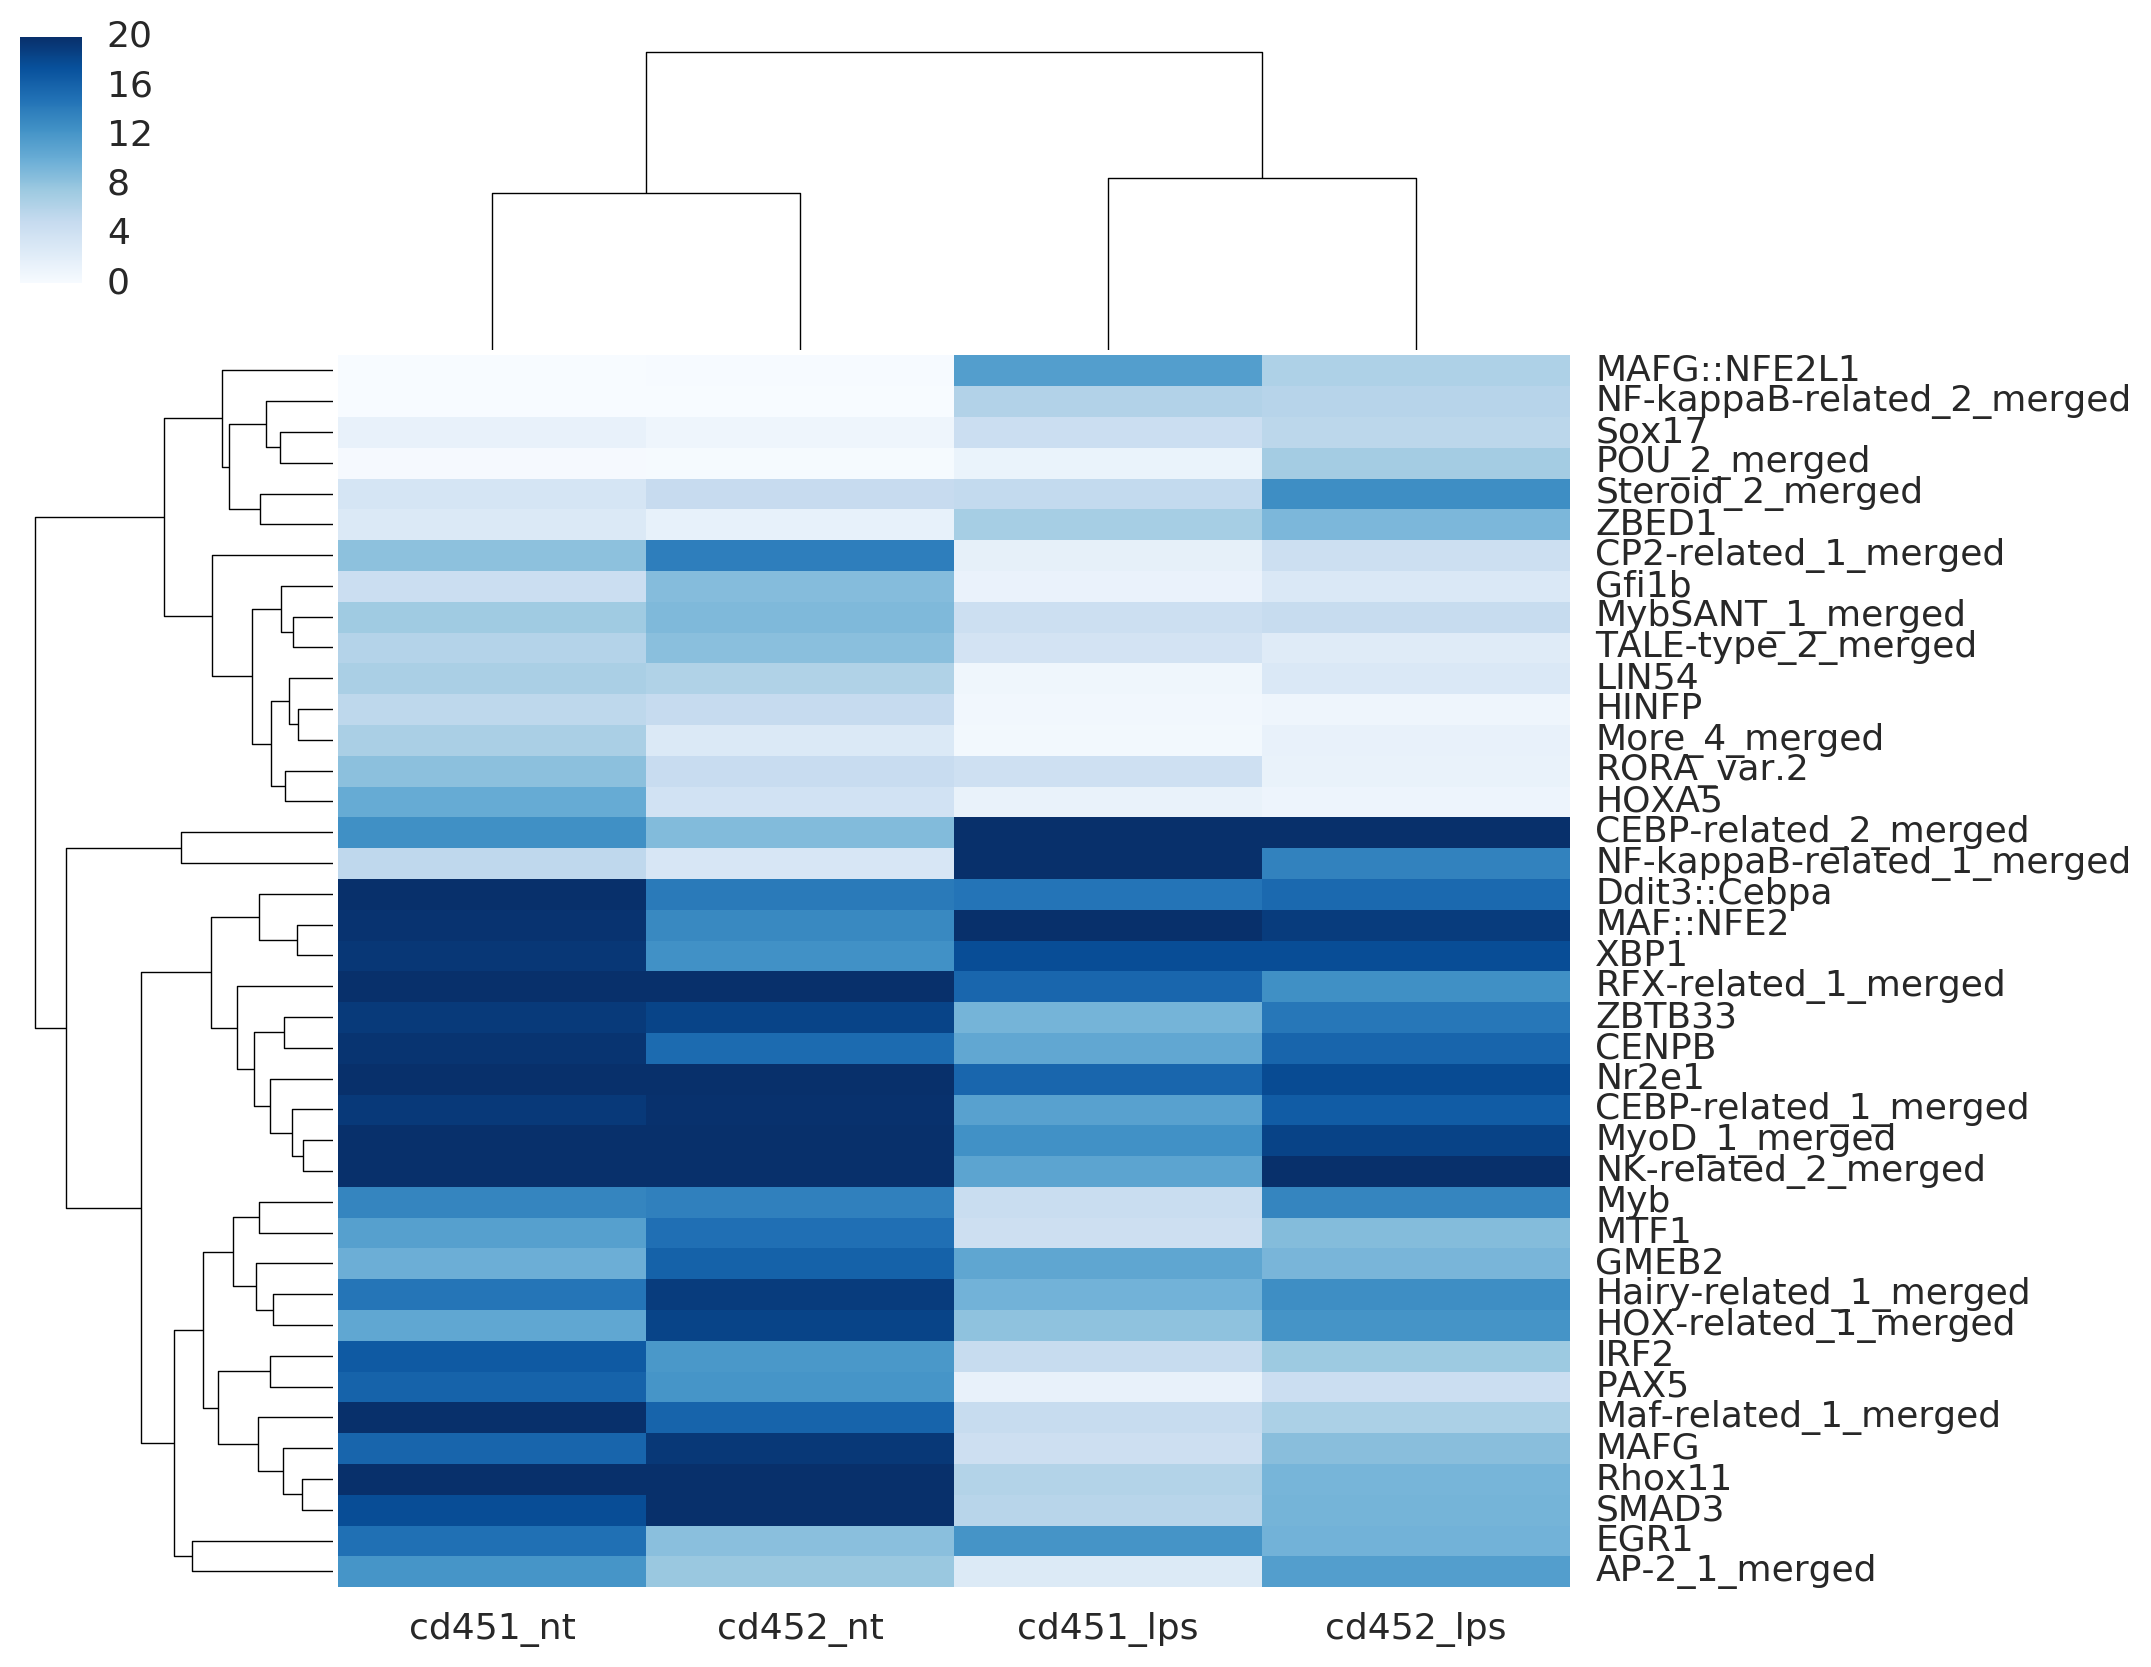

In [10]:
pseudocount = 1e-20 # pseudocount for calculating logfold change
treatments = mean_pval_frame.columns
treatment_orientedPvals_dict = {}
for treatment in treatments:
    # retrieve pval and weights cooresponding to treatment
    pvals = mean_pval_frame[treatment]
    weights = mean_weights_frame[treatment]
    
    # calculate logpvals and assign direction according to weight
    oriented_pvals = [np.log10(x[0] +pseudocount) if x[1] < 0 else -np.log10(x[0]+pseudocount) for x in zip(pvals, weights)]
    treatment_orientedPvals_dict[treatment] = oriented_pvals
# crate data frame
frame = pd.DataFrame(treatment_orientedPvals_dict, index = mean_pval_frame.index.values)
# sort by mean
frame['mean'] = frame.mean(axis=1)
frame.sort_values('mean', ascending = False, inplace=True)
frame.drop('mean', axis=1, inplace=True)

# plot only motifs with log pval > 2 for at least one condition (p<0.01) and positively correlated with open chromatin
frame = frame[frame.max(axis=1) > 5]
# plot only motifs with absolute log likelihood ratio >=3
filtered_frame = frame[((frame.max(axis=1) - frame.min(axis=1)).abs() >=4)]

# create heatmap
cg = sns.clustermap(filtered_frame,
     vmin=0,
     cmap='Blues',
                   )
plt.setp(cg.ax_heatmap.get_yticklabels(), rotation=0);


### Create Table of top positively correlated motifs

In [11]:
pval_threshold = 1e-10
positive_motif_set = None
for treatment in treatments:
    pvals = mean_pval_frame[treatment]
    weights = mean_weights_frame[treatment]


    significant_positive_motifs = weights[weights>0].index.intersection(pvals[pvals < pval_threshold].index)
    if positive_motif_set == None:
        positive_motif_set = set(significant_positive_motifs)
    else:
        positive_motif_set = positive_motif_set.intersection(set(significant_positive_motifs)) 
data = mean_pval_frame.loc[sorted(positive_motif_set), :]

data = data+1e-50

positive_table = data[[]]
positive_table['Motif'] = data.index.values
positive_table['Mean p-val'] = data.mean(axis=1)
positive_table.sort_values(by='Mean p-val', inplace = True)
# positive_table.to_csv('./figures/postive_motif_table.tsv', sep='\t', index = False)
positive_table

/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

Motif    Mean p-val
Klf12                                  Klf12  1.000000e-50
Gabpa                                  Gabpa  1.000000e-50
Runt-related_1_merged  Runt-related_1_merged  1.000000e-50
CTCF                                    CTCF  1.000000e-50
Jun-related_1_merged    Jun-related_1_merged  1.000000e-50
Ets-related_1_merged    Ets-related_1_merged  1.000000e-50
Ets-related_2_merged    Ets-related_2_merged  1.000000e-50
IRF1                                    IRF1  1.000000e-50
STAT1::STAT2                    STAT1::STAT2  1.000006e-50
Regulators_1_merged      Regulators_1_merged  1.418321e-48
Pax2                                    Pax2  5.271295e-45
CEBPA                                  CEBPA  2.245329e-35
NFYA                                    NFYA  3.852035e-31
Gmeb1                                  Gmeb1  4.398271e-28
Three-zinc_2_merged      Three-zinc_2_merged  8.261097e-27
NFIC::TLX1                        NFIC::TLX1  3.095114e-25
THAP1                                  THAP1  6.591244e-24
ZNF143                                ZNF143  9.572712e-23
HMBOX1                                HMBOX1  1.770150e-22
E2F1                                    E2F1  8.793182e-22
ATF4                                    ATF4  2.394557e-21
NRF1                                    NRF1  5.560442e-21
SPIB                                    SPIB  1.641438e-20
Ahr::Arnt                          Ahr::Arnt  3.001031e-20
BARHL2                                BARHL2  4.356007e-19
Nr2e1                                  Nr2e1  3.666943e-17
Ddit3::Cebpa                    Ddit3::Cebpa  1.643325e-15
MAF::NFE2                          MAF::NFE2  1.845547e-14
RFX-related_1_merged    RFX-related_1_merged  6.268751e-14
MyoD_1_merged                  MyoD_1_merged  7.404100e-14
XBP1                                    XBP1  7.649884e-14
CEBP-related_1_merged  CEBP-related_1_merged  1.820137e-12
NK-related_2_merged      NK-related_2_merged  3.180988e-12
CENPB                                  CENPB  6.119337e-12

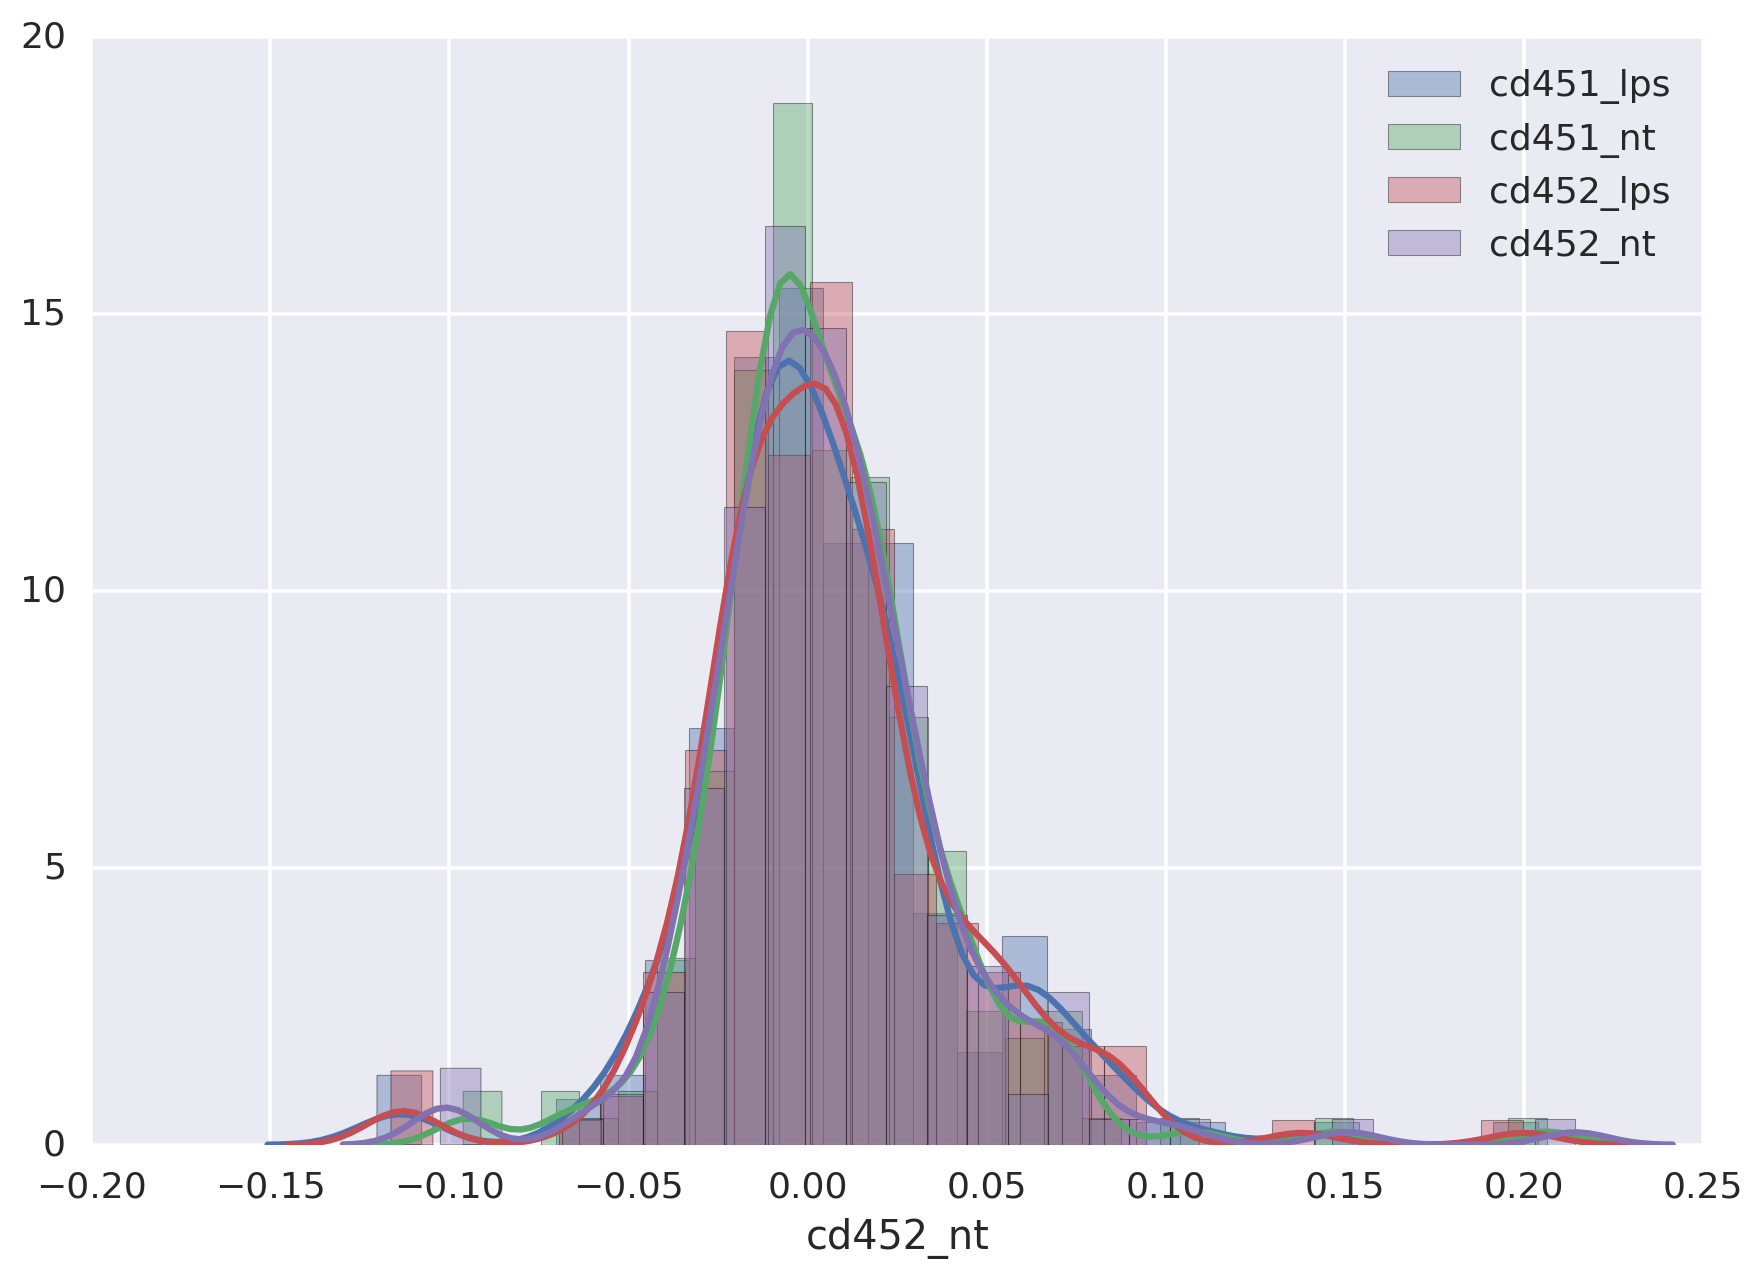

In [12]:
for treatment in mean_weights_frame.columns:
    sns.distplot(mean_weights_frame[treatment], label = treatment)
plt.legend()

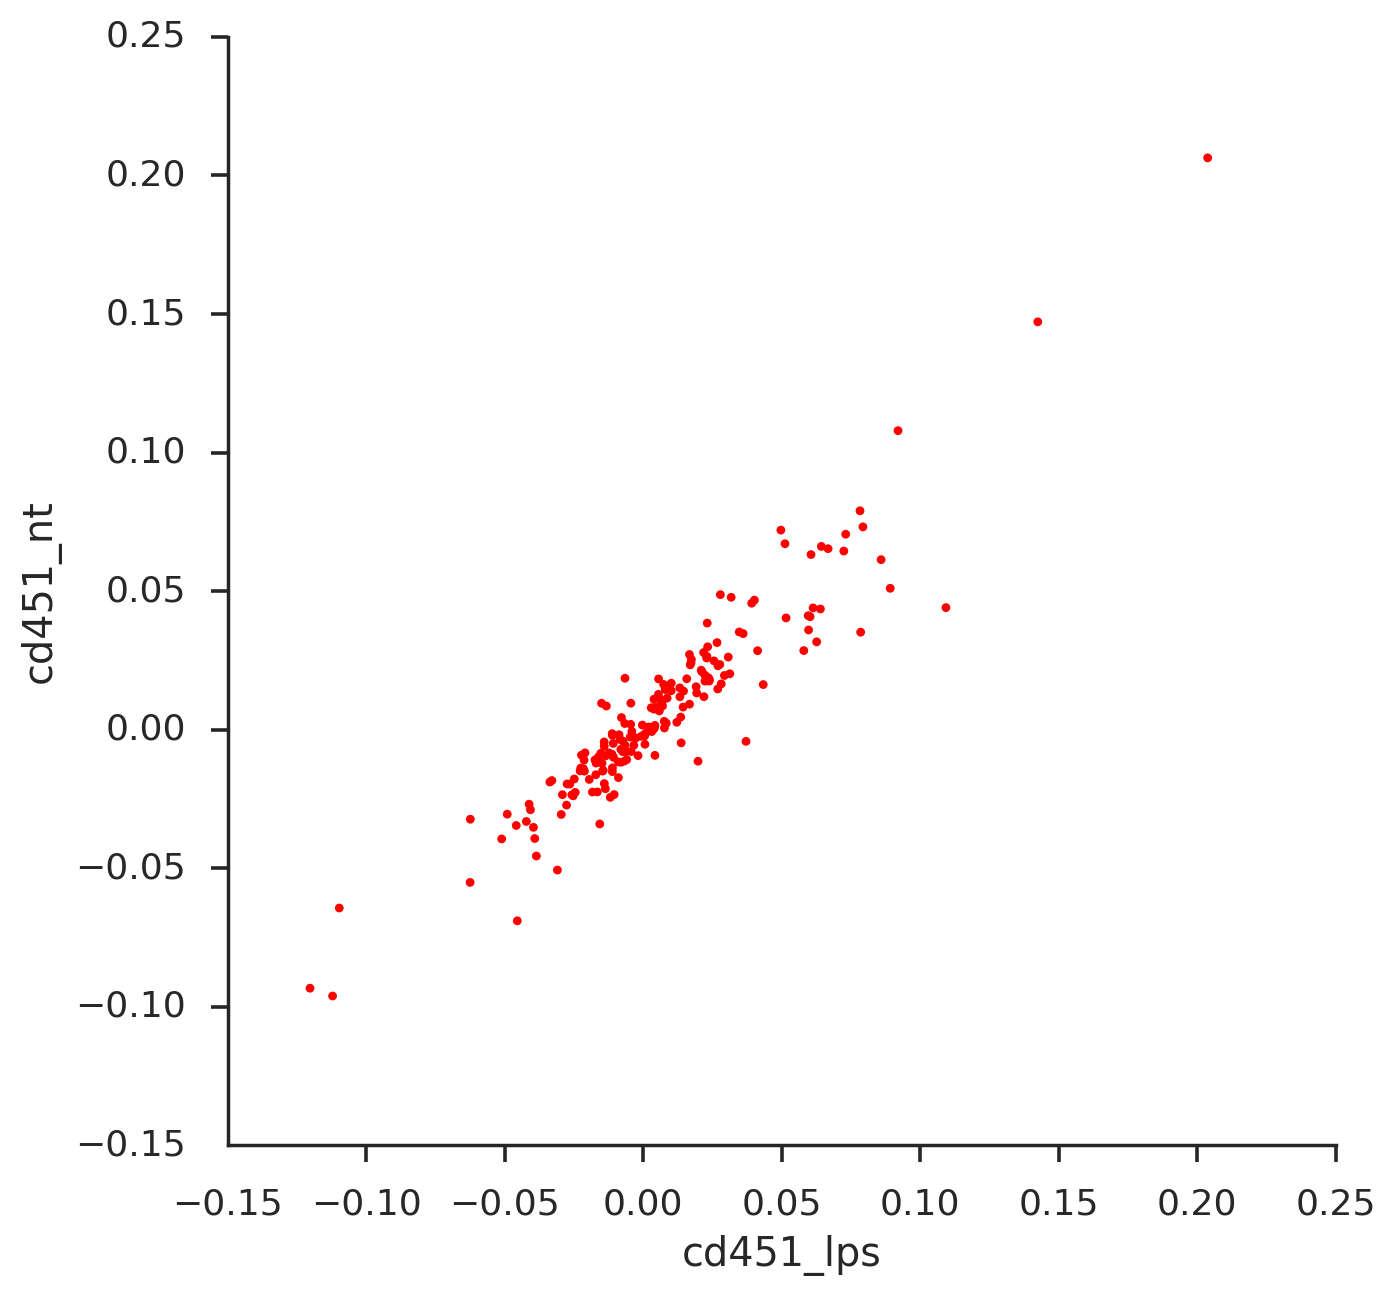

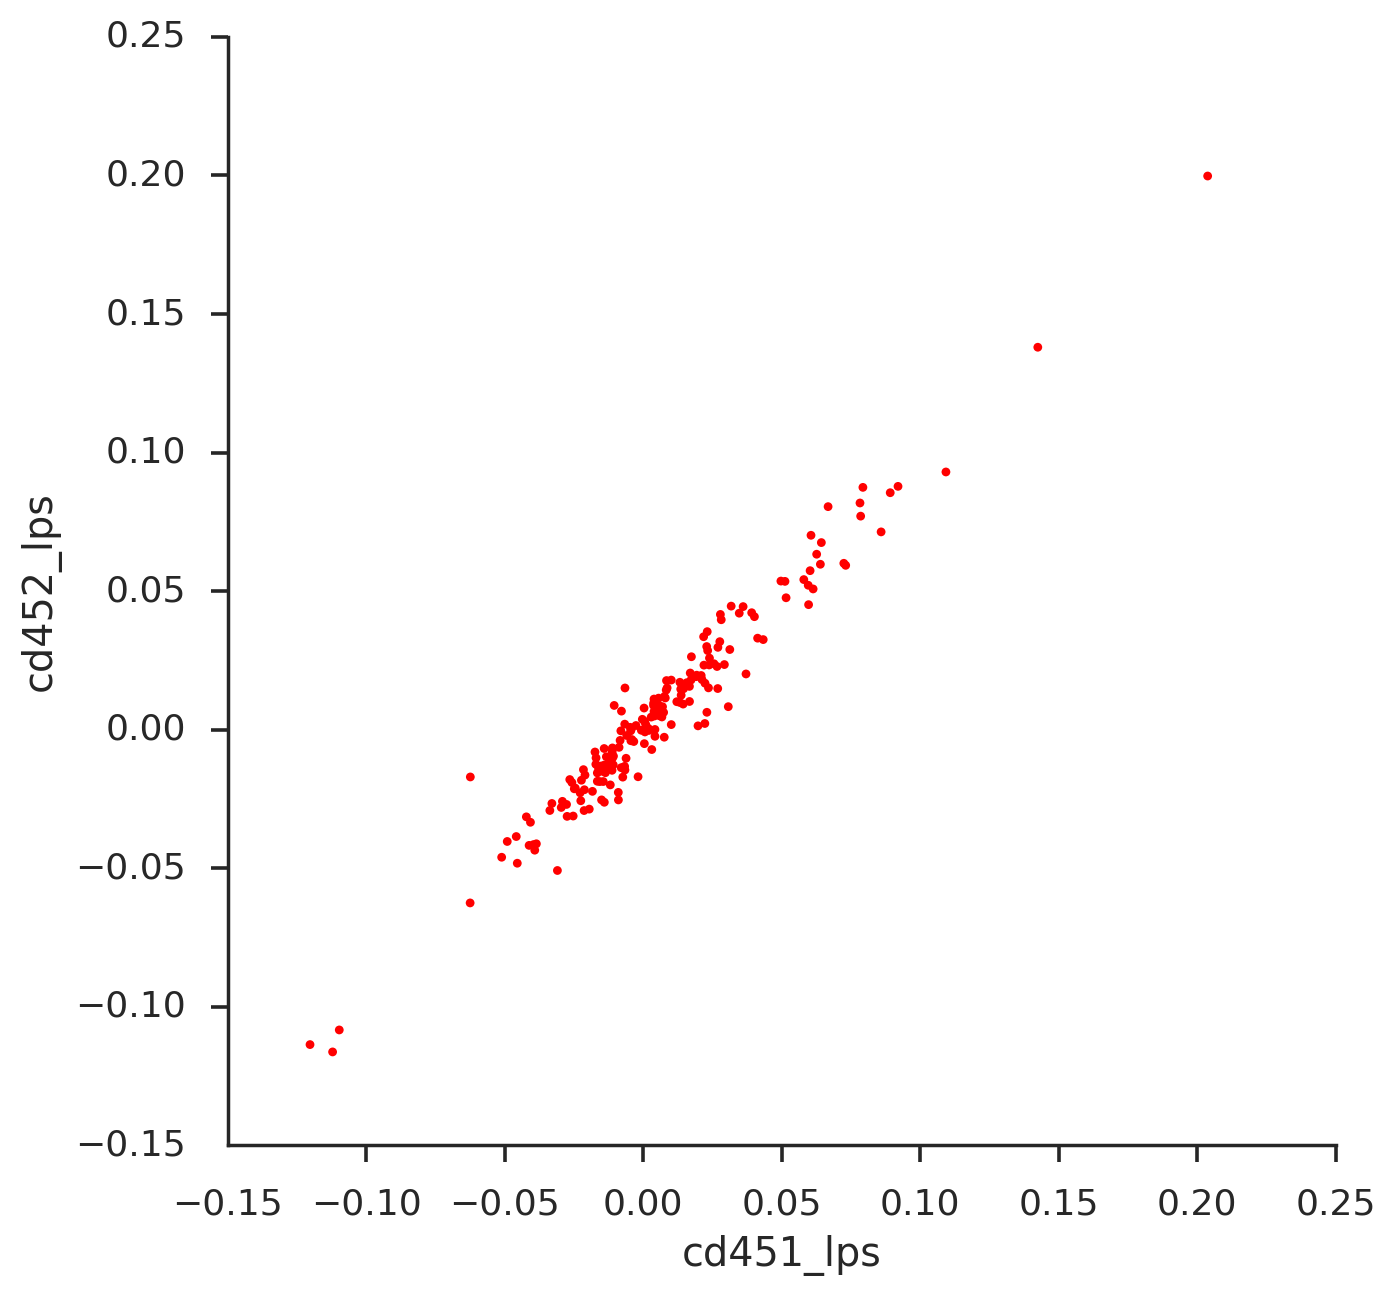

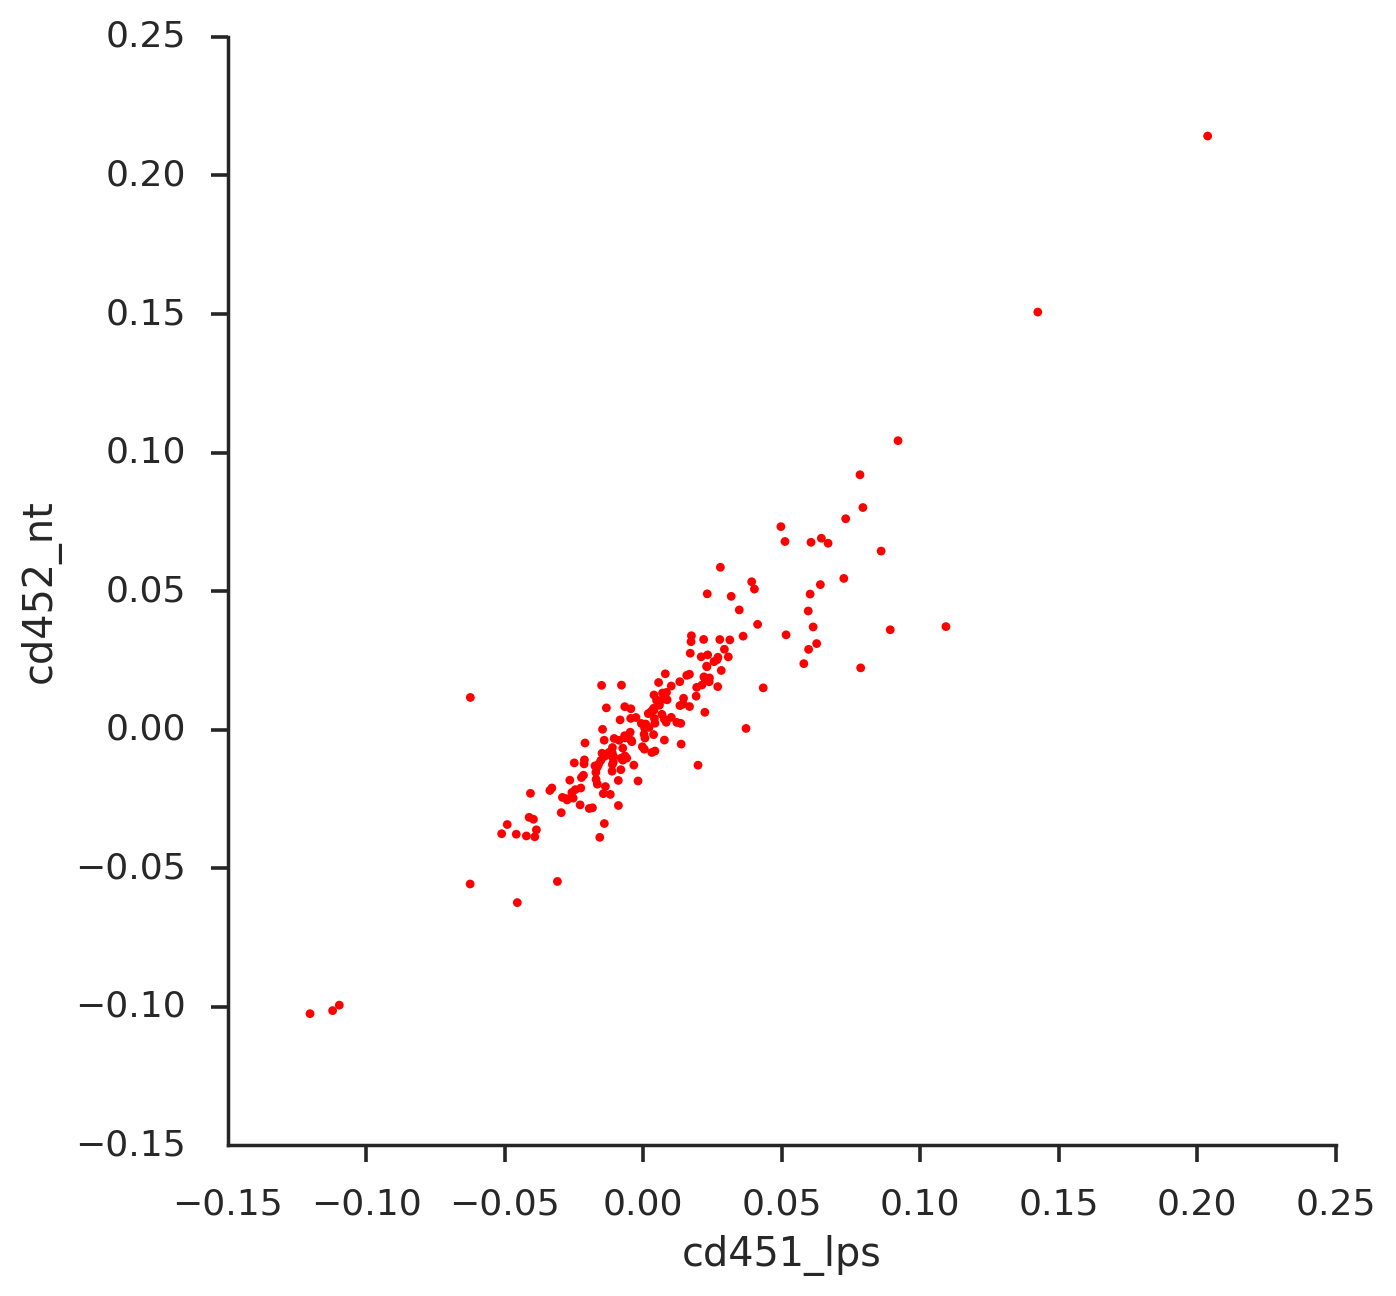

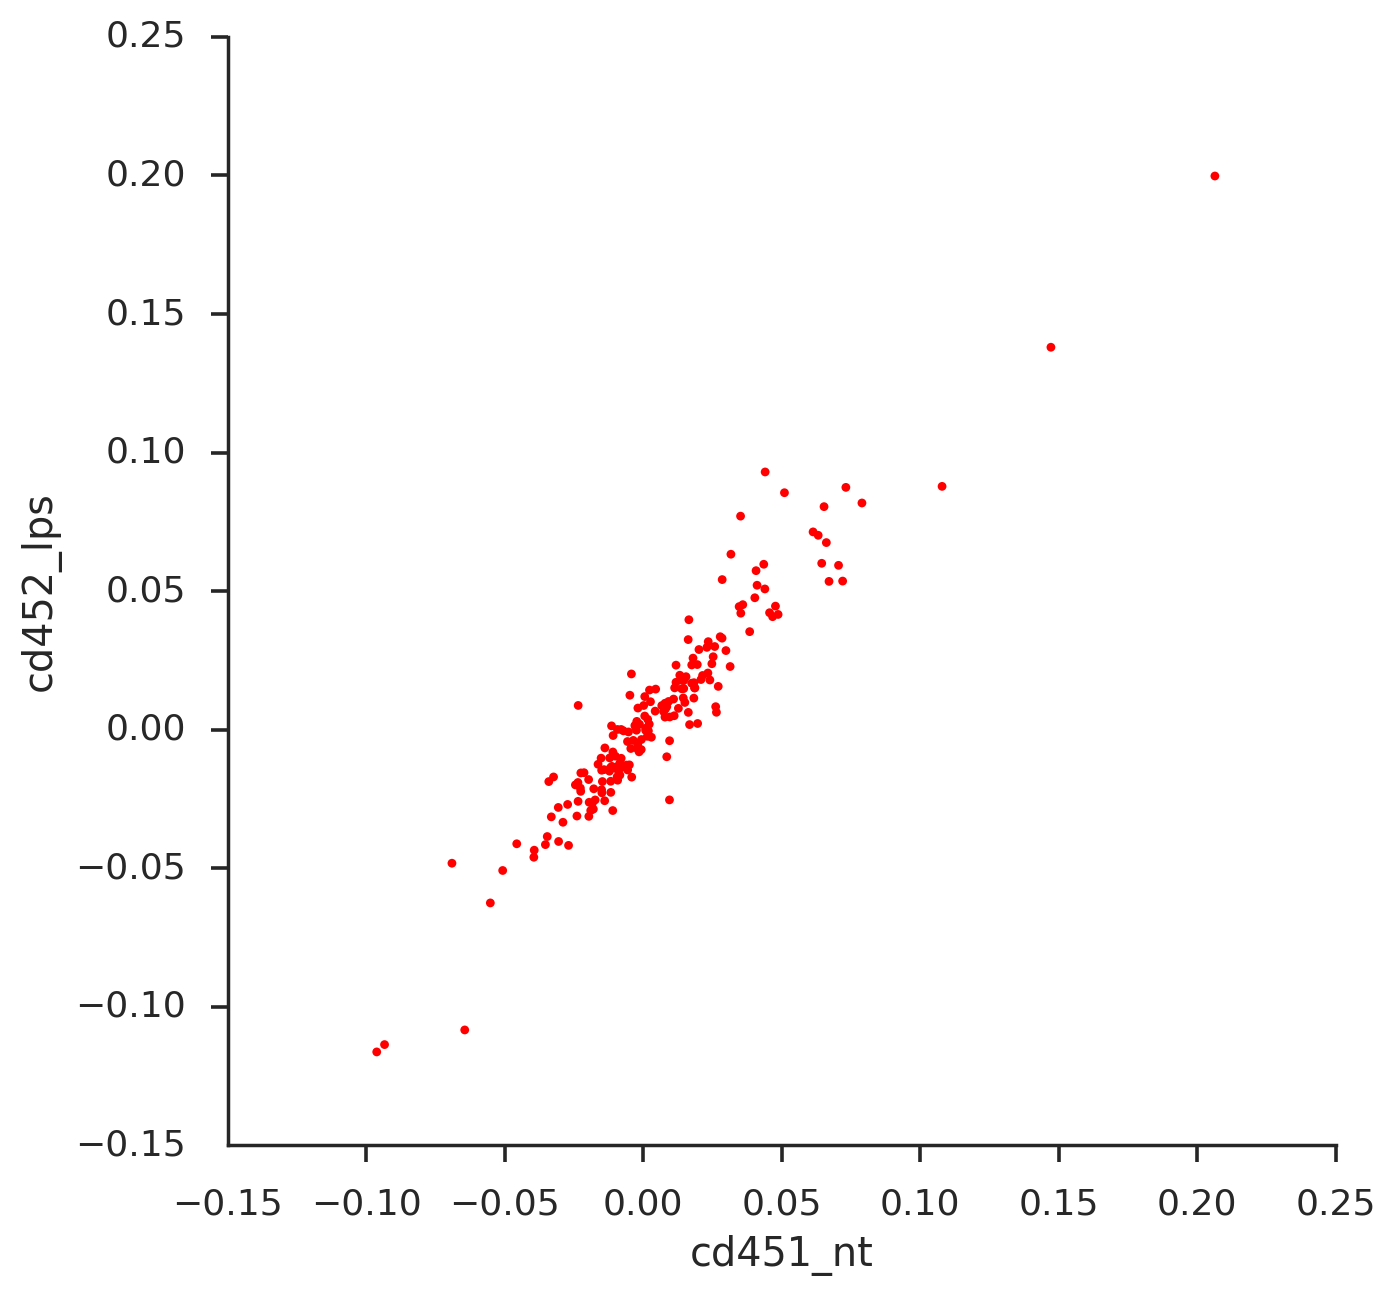

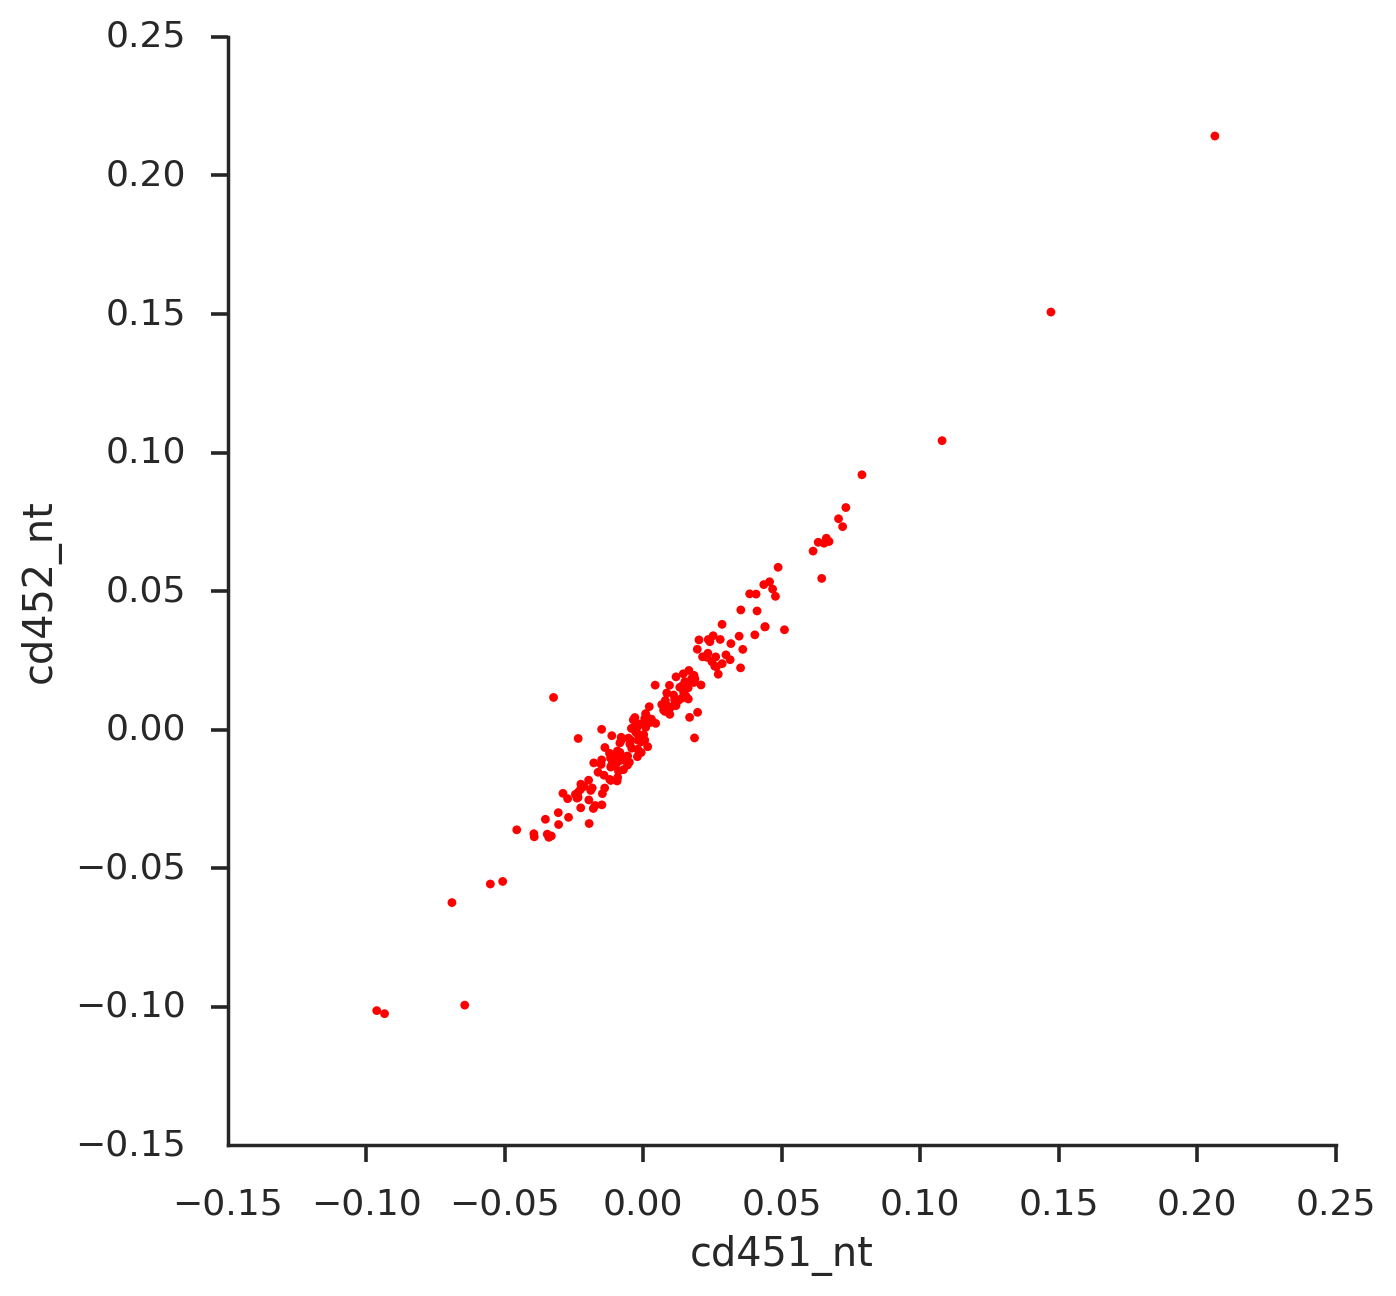

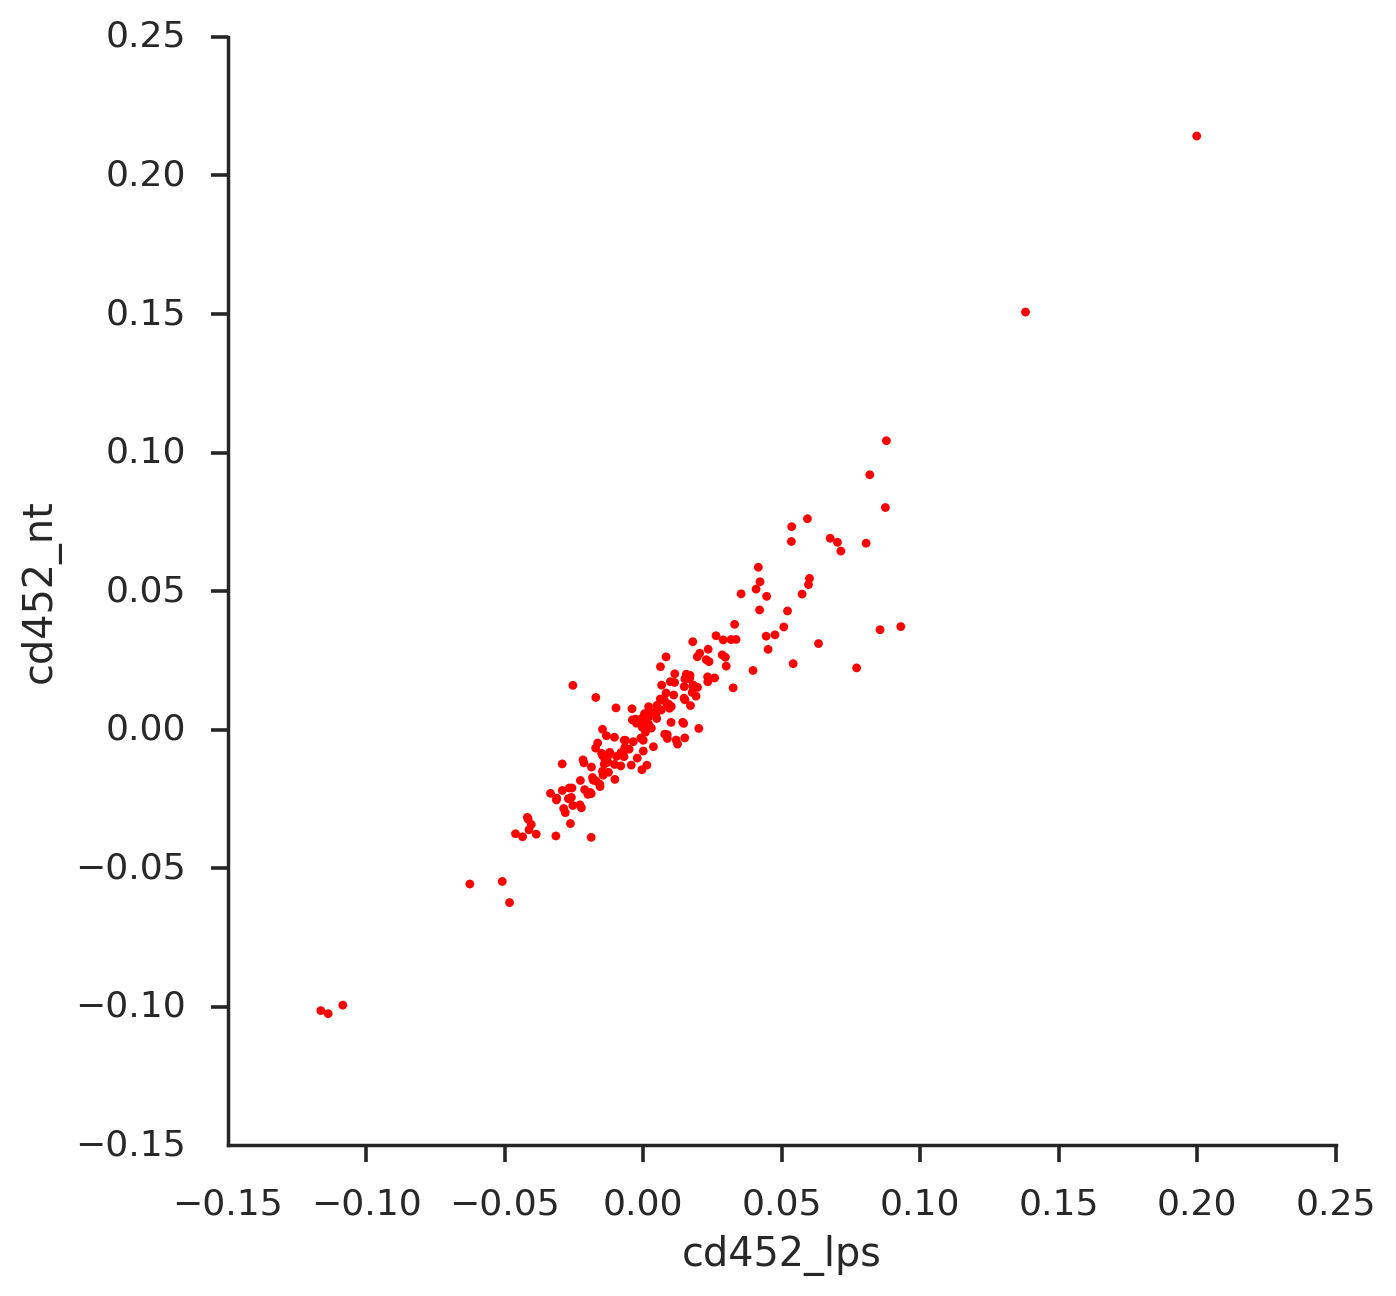

In [13]:
treatments = mean_weights_frame.columns.values
for i in range(len(treatments)-1):
    for j in range(i+1,len(treatments)):
        with sns.axes_style('ticks'):
            xvals = mean_weights_frame[treatments[i]]
            yvals = mean_weights_frame[treatments[j]]
            x_vals = np.exp(xvals)
            y_vals = np.exp(yvals)
            plt.scatter(xvals,
                        yvals,
                        edgecolor='None',
                        s=10,
                        c='red')
            plt.xlabel(treatments[i])
            plt.ylabel(treatments[j])
            sns.despine()
            plt.xlim(-0.15,0.25)
            plt.ylim(-0.15,0.25)
            plt.gca().set_aspect(1)
            plt.show()

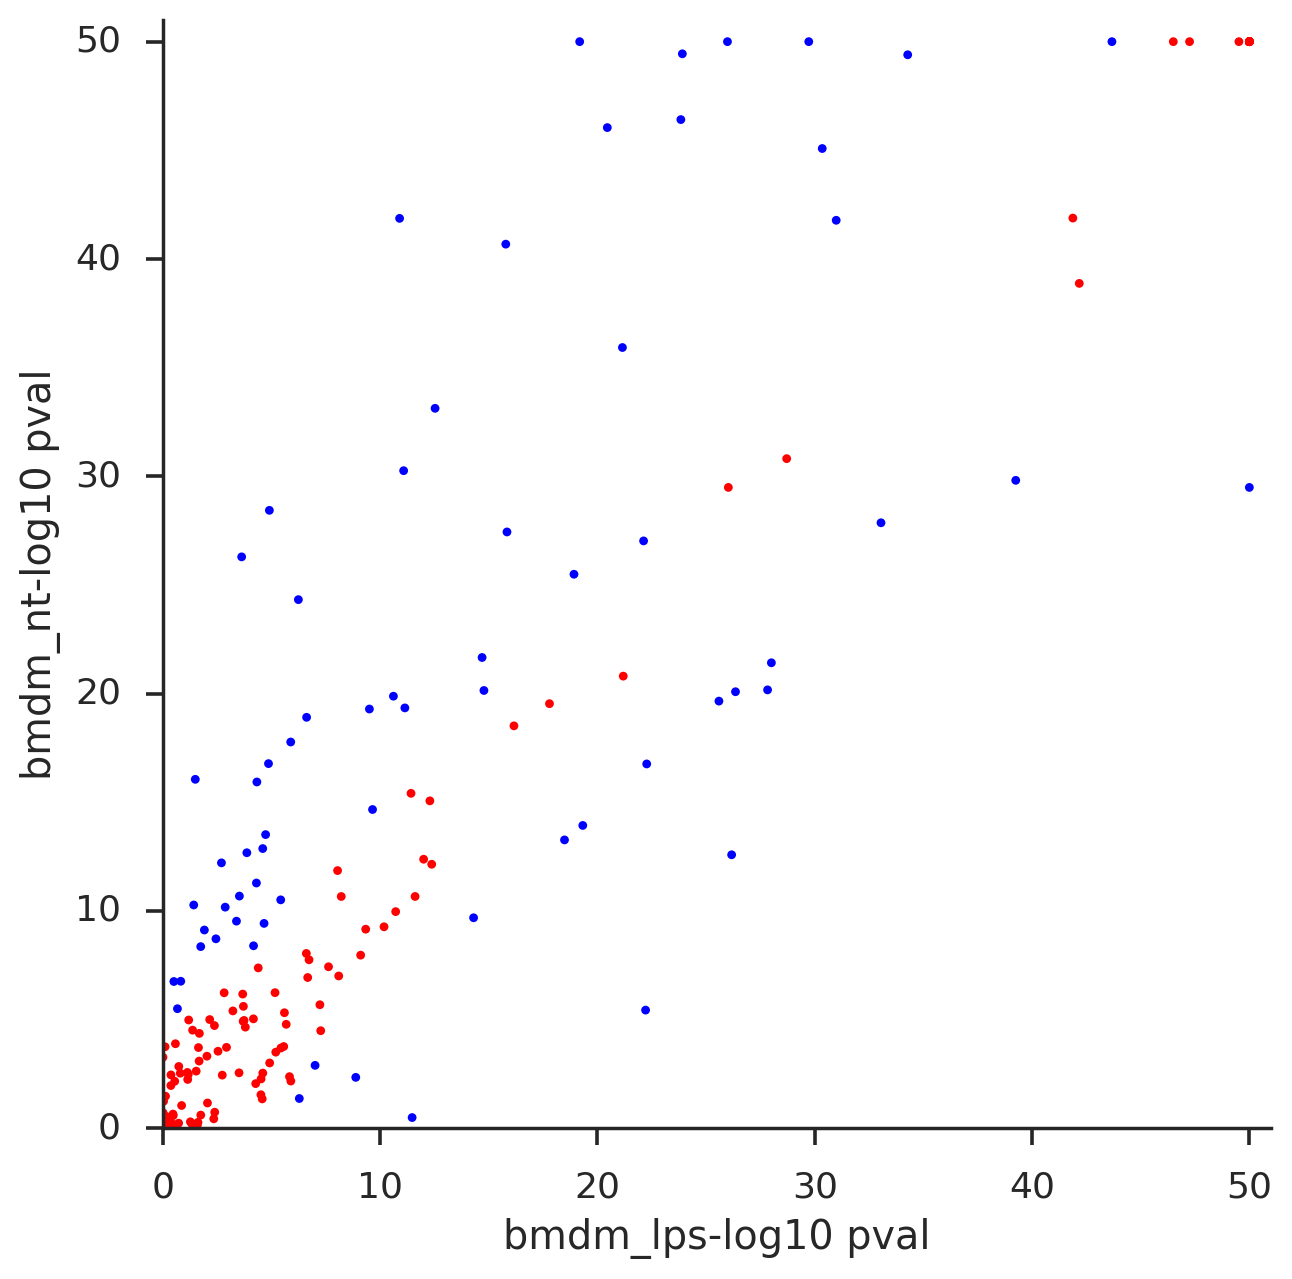

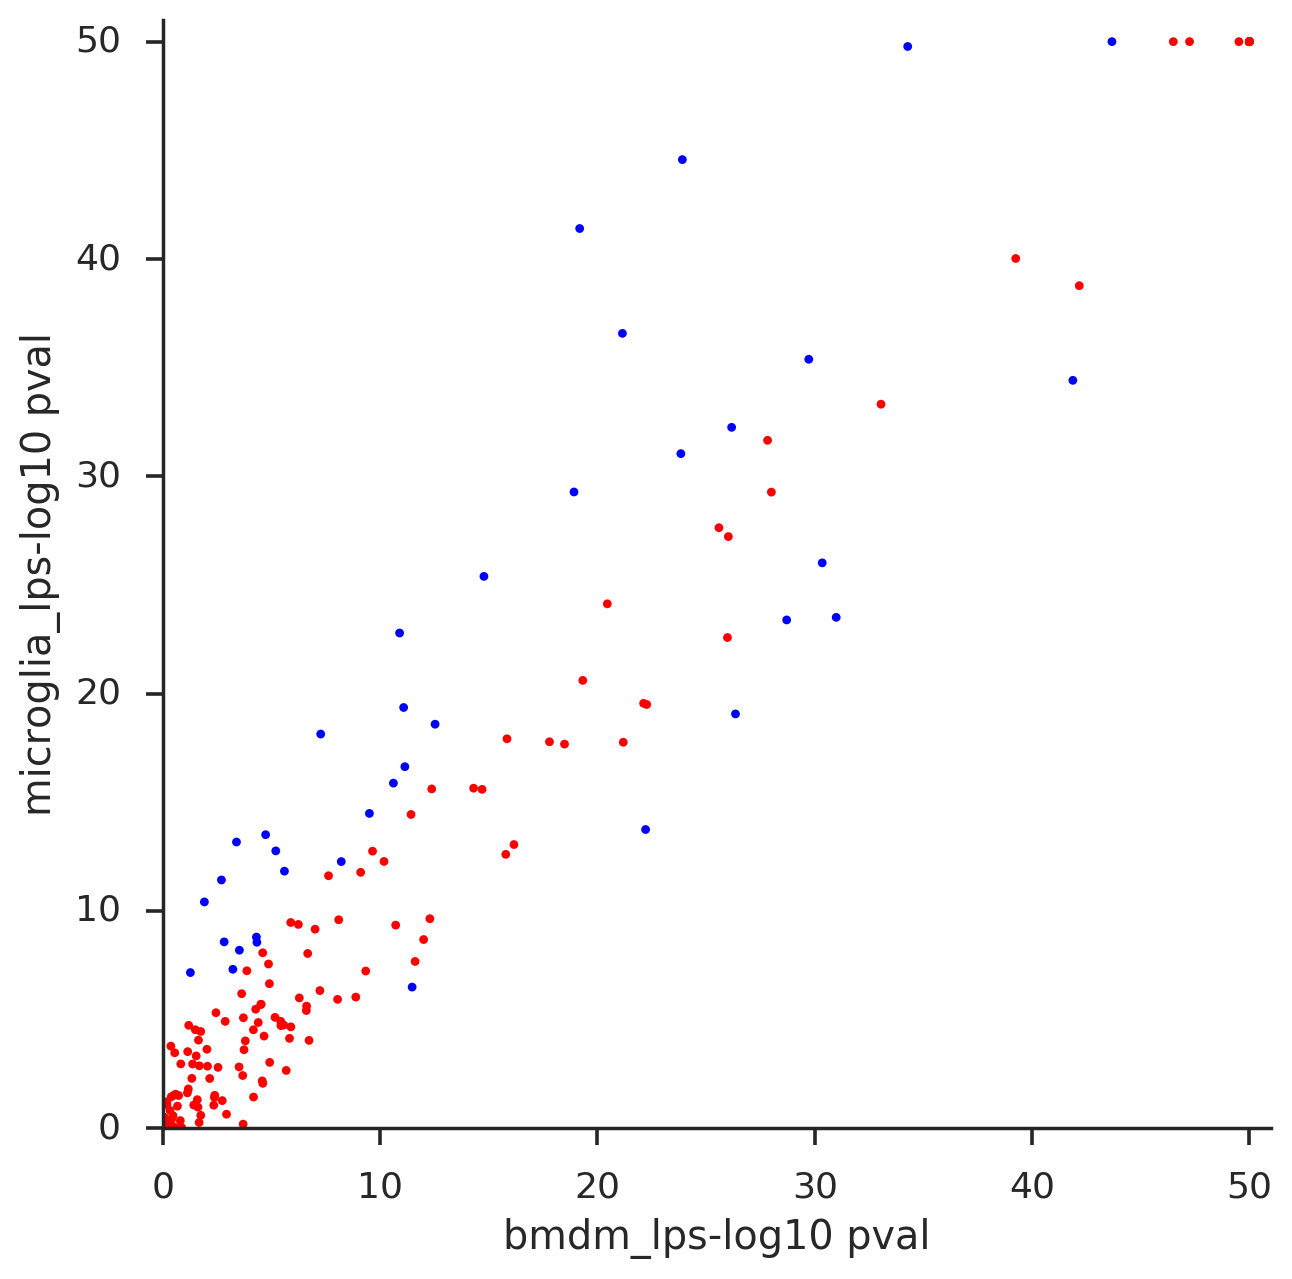

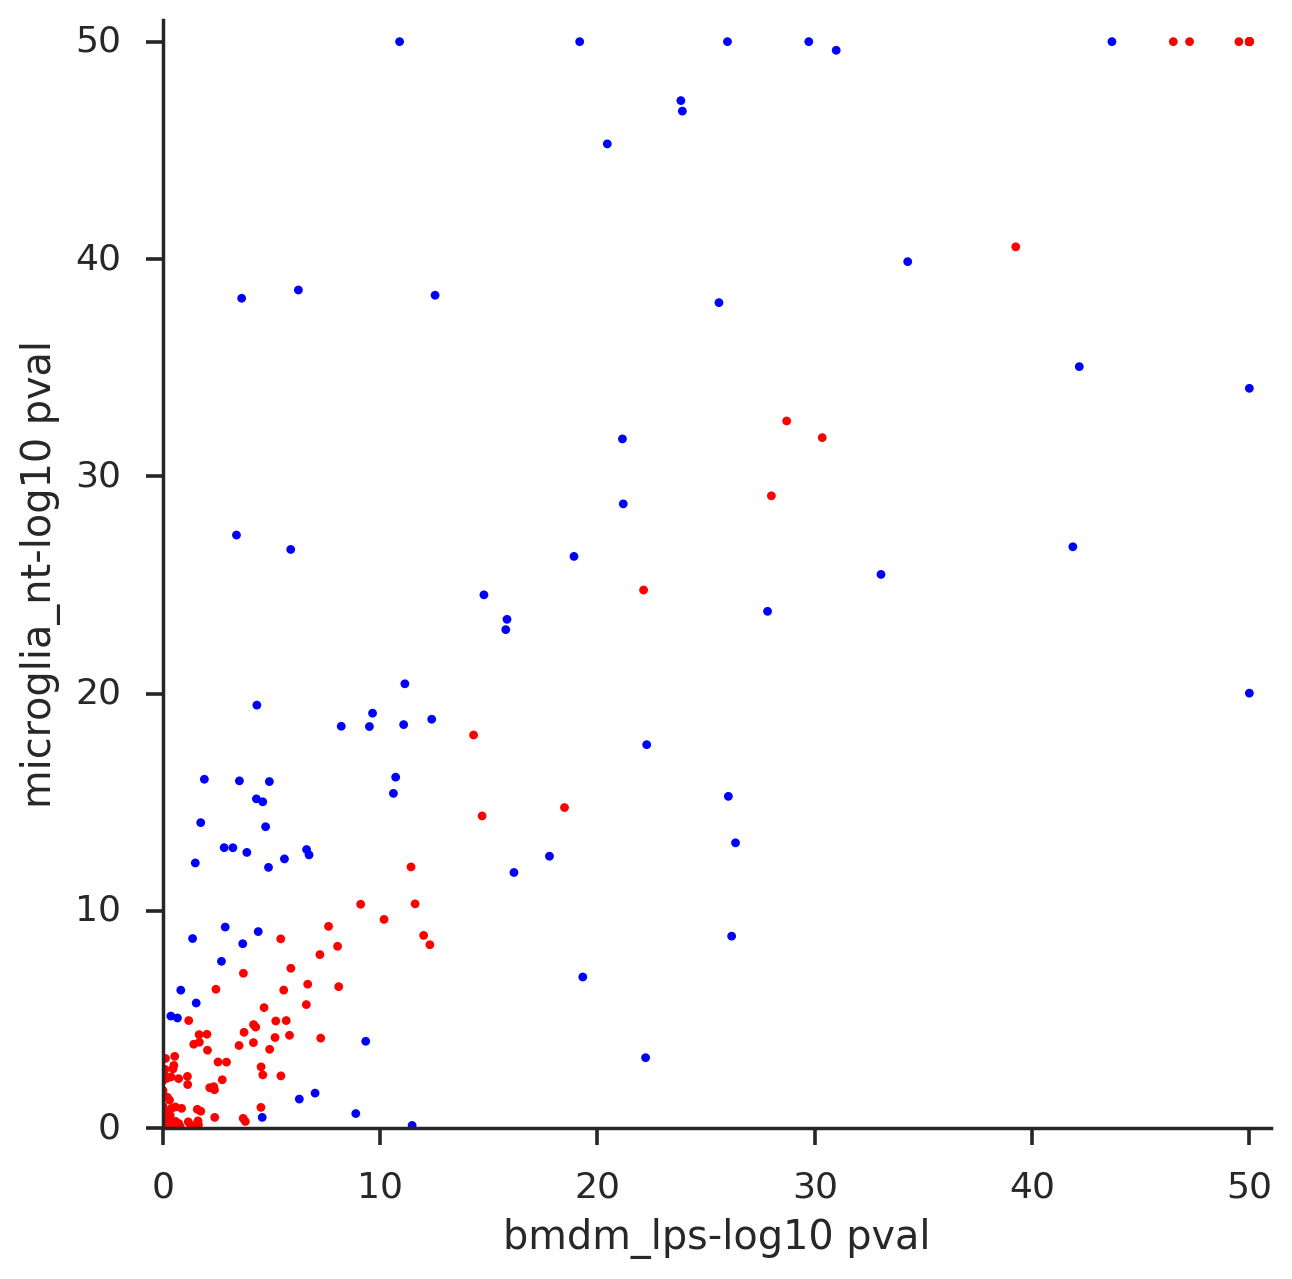

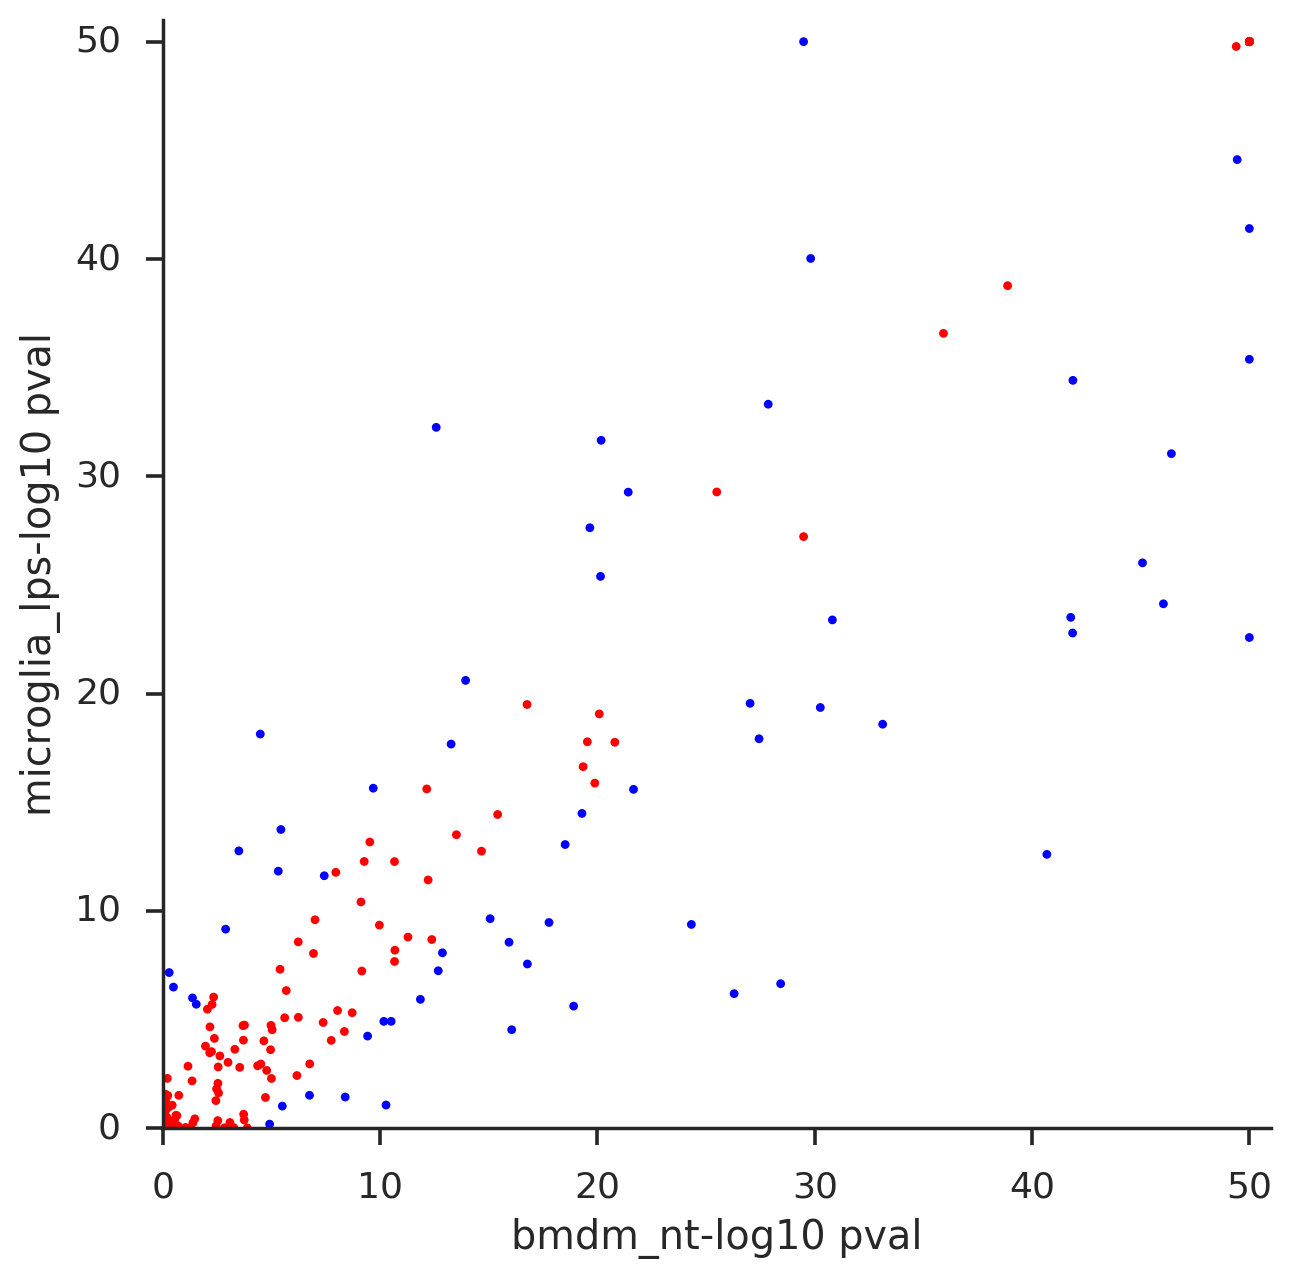

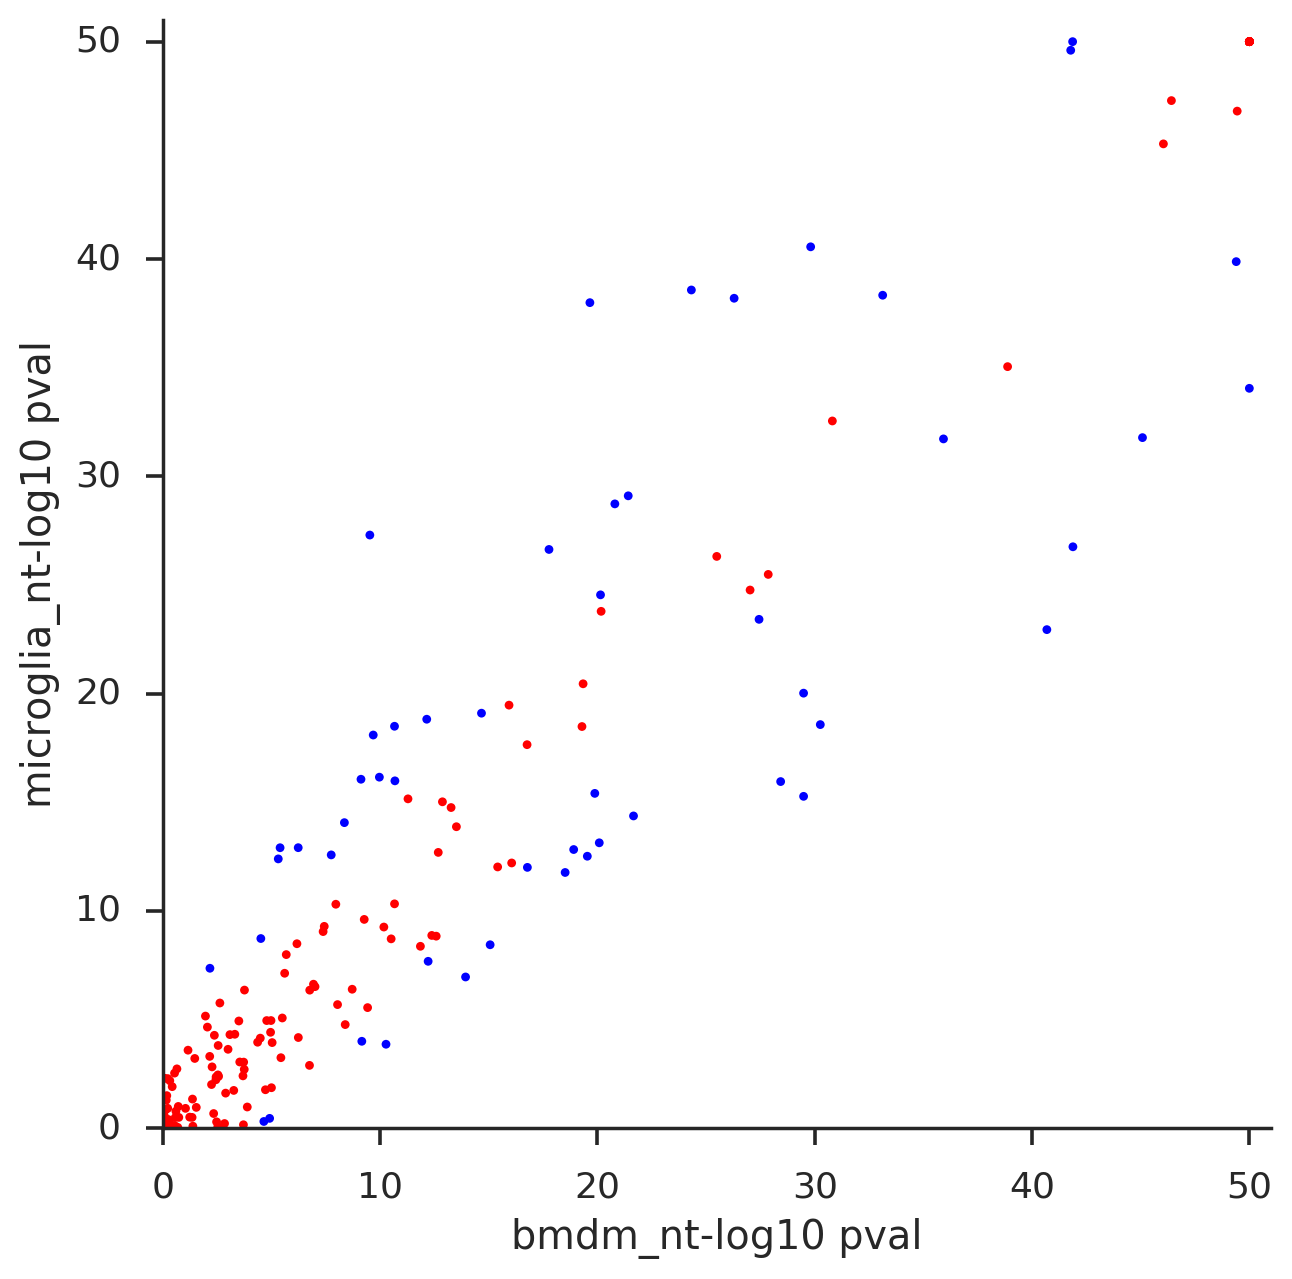

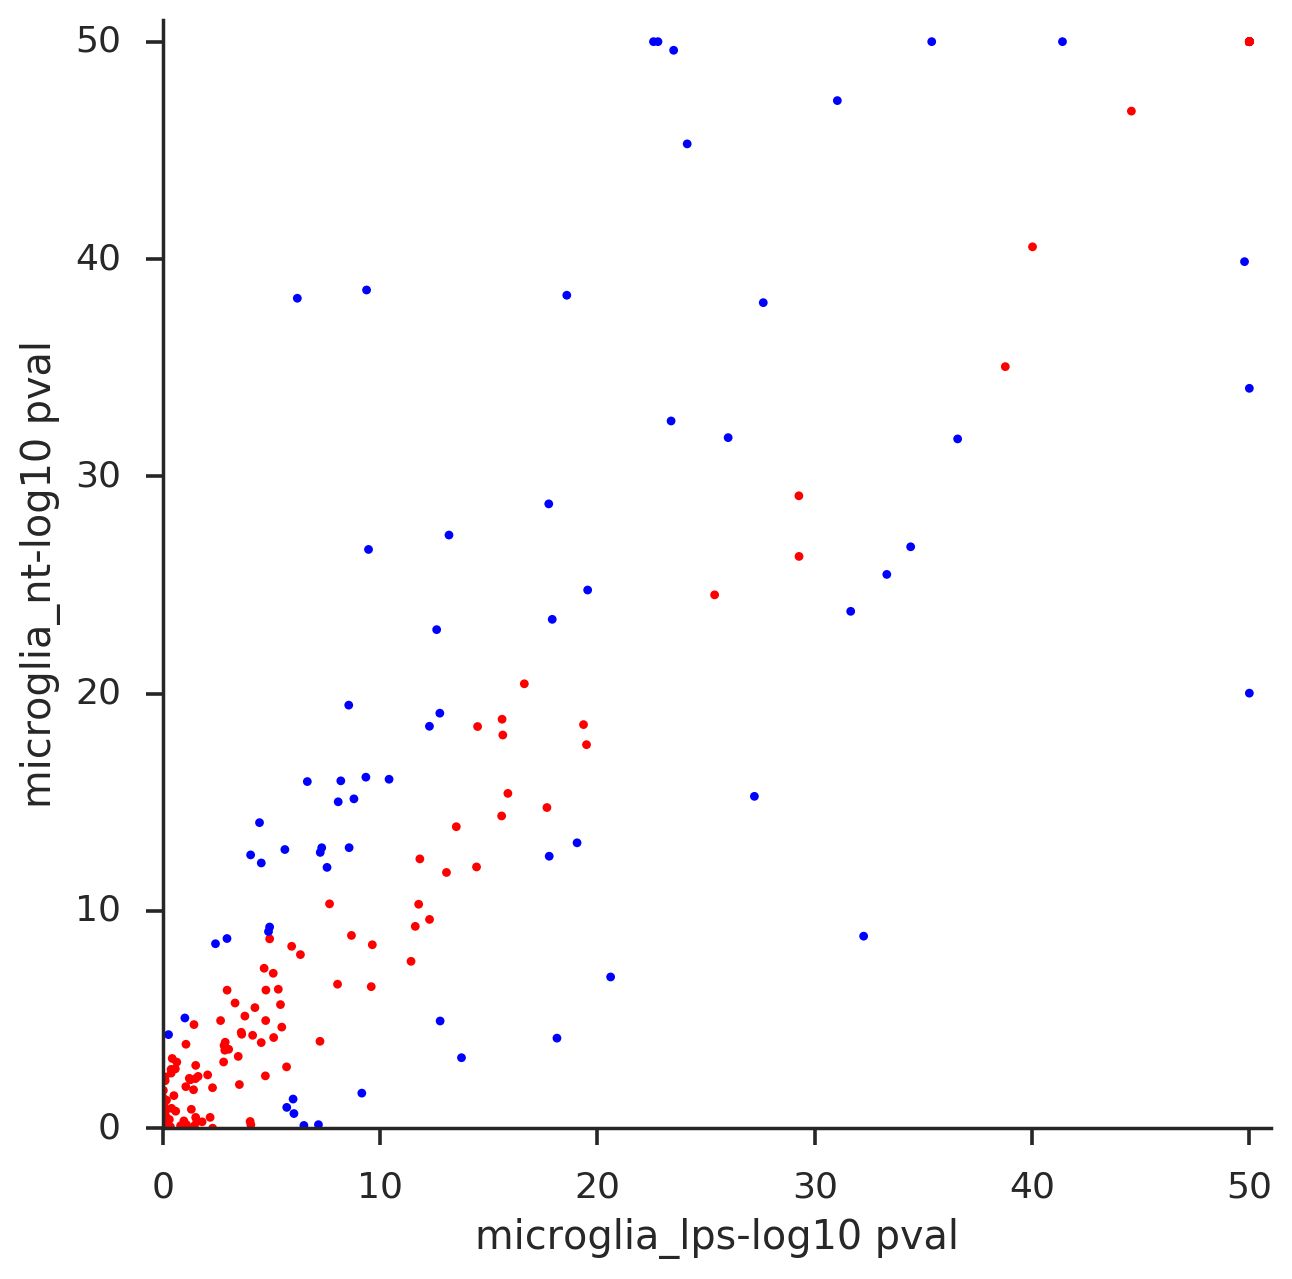

In [14]:
treatments = mean_weights_frame.columns.values
for i in range(len(treatments)-1):
    for j in range(i+1,len(treatments)):
        with sns.axes_style('ticks'):
            colors = []
            xvals = mean_pval_frame[treatments[i]]
            yvals = mean_pval_frame[treatments[j]]
            
            xvals = -np.log10(xvals+1e-50)
            yvals = -np.log10(yvals+1e-50)
            for x, y in list(zip(xvals+1e-20,yvals+1e-20)):
                if abs(x-y)>=4:
                    colors.append('blue')
                else:
                    colors.append('red')
            plt.scatter(xvals,
                        yvals,
                        edgecolor='None',
                        s=10,
                        c=colors
                       )
            plt.xlabel(treatments[i].replace('cd451', 'bmdm').replace('cd452', 'microglia') + '-log10 pval')
            plt.ylabel(treatments[j].replace('cd451', 'bmdm').replace('cd452', 'microglia') + '-log10 pval')
            sns.despine()
            plt.xlim(0,51)
            plt.ylim(0,51)
            plt.gca().set_aspect(1)
            plt.show()

In [57]:
! mergePeaks -d 75 -venn venn.txt ./atac_idr_peaks/*  > ./merged_atac_peaks.tsv

	Max distance to merge: 75 bp
	Merging peaks... 
	Comparing ./atac_idr_peaks/cd451_lps_peaks.tsv (44540 total) and ./atac_idr_peaks/cd451_lps_peaks.tsv (44540 total)
	Comparing ./atac_idr_peaks/cd451_lps_peaks.tsv (44540 total) and ./atac_idr_peaks/cd451_nt_peaks.tsv (82444 total)
	Comparing ./atac_idr_peaks/cd451_lps_peaks.tsv (44540 total) and ./atac_idr_peaks/cd452_lps_peaks.tsv (53913 total)
	Comparing ./atac_idr_peaks/cd451_lps_peaks.tsv (44540 total) and ./atac_idr_peaks/cd452_nt_peaks.tsv (74433 total)
	Comparing ./atac_idr_peaks/cd451_nt_peaks.tsv (82444 total) and ./atac_idr_peaks/cd451_lps_peaks.tsv (44540 total)
	Comparing ./atac_idr_peaks/cd451_nt_peaks.tsv (82444 total) and ./atac_idr_peaks/cd451_nt_peaks.tsv (82444 total)
	Comparing ./atac_idr_peaks/cd451_nt_peaks.tsv (82444 total) and ./atac_idr_peaks/cd452_lps_peaks.tsv (53913 total)
	Comparing ./atac_idr_peaks/cd451_nt_peaks.tsv (82444 total) and ./atac_idr_peaks/cd452_nt_peaks.tsv (74433 total)
	Comparing ./atac_idr_p

In [58]:
! makeSummaryFile.py ./merged_atac_peaks.tsv ./group_atac_summary.tsv ./atac_idr_peaks/*

Finished reading merged peak file...
Integrating scores for cd451_lps
Integrating scores for cd451_nt
Integrating scores for cd452_lps
Integrating scores for cd452_nt


In [8]:
# read in peak data data
summary_frame = pd.read_csv('./group_atac_summary.tsv' , sep='\t')
summary_frame = summary_frame.fillna('0')
for col in summary_frame.columns[5:]:
    floatValues = []
    for val in summary_frame[col].values.astype(str):
        if ',' in val:
            maxVal = np.mean([float(x) for x in val.split(',')])
            floatValues.append(maxVal)
        else:
            floatValues.append(float(val))
    summary_frame[col] = floatValues
summary_frame.index = summary_frame['ID'].values

# remove peaks in unknown/random chromosomes
summary_frame = summary_frame[~summary_frame['chr'].str.contains('random')]
summary_frame = summary_frame[~summary_frame['chr'].str.contains('Un')]


In [9]:
summary_frame.shape

(104506, 9)

In [10]:
summary_frame.head()

ID    chr      start        end  \
Merged-chr17-48411509-1  Merged-chr17-48411509-1  chr17   48411472   48411546   
Merged-chr11-63264868-1  Merged-chr11-63264868-1  chr11   63264831   63264905   
Merged-chr7-109863786-1  Merged-chr7-109863786-1   chr7  109863749  109863823   
Merged-chr19-32328319-1  Merged-chr19-32328319-1  chr19   32328282   32328356   
Merged-chr8-37063986-1    Merged-chr8-37063986-1   chr8   37063949   37064023   

                          Factors  cd451_lps  cd451_nt  cd452_lps  cd452_nt  
Merged-chr17-48411509-1  cd452_nt        0.0       0.0        0.0      56.0  
Merged-chr11-63264868-1  cd452_nt        0.0       0.0        0.0      44.0  
Merged-chr7-109863786-1  cd452_nt        0.0       0.0        0.0      52.0  
Merged-chr19-32328319-1  cd452_nt        0.0       0.0        0.0      37.0  
Merged-chr8-37063986-1   cd452_nt        0.0       0.0        0.0      39.0

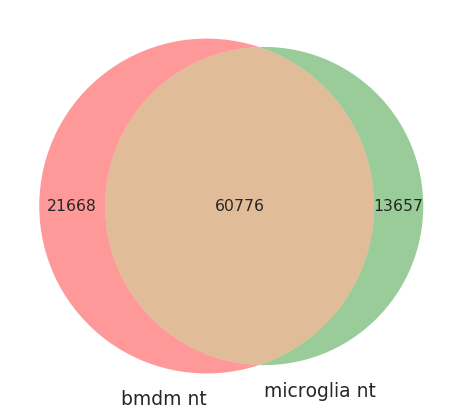

In [11]:
matplotlib_venn.venn2([set(summary_frame[summary_frame['cd451_nt'] > 0].index.values),
                       set(summary_frame[summary_frame['cd452_nt'] > 0].index.values)], 
                      set_labels=['bmdm nt', 'microglia nt'])

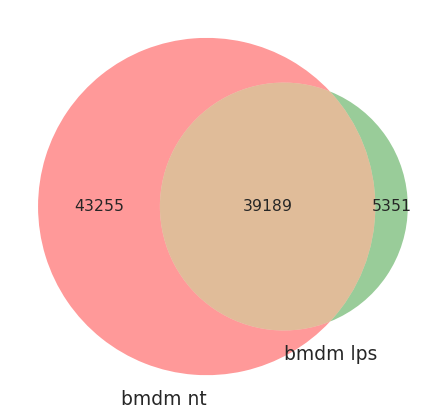

In [12]:
matplotlib_venn.venn2([set(summary_frame[summary_frame['cd451_nt'] > 0].index.values),
                       set(summary_frame[summary_frame['cd451_lps'] > 0].index.values)], 
                      set_labels=['bmdm nt', 'bmdm lps'])

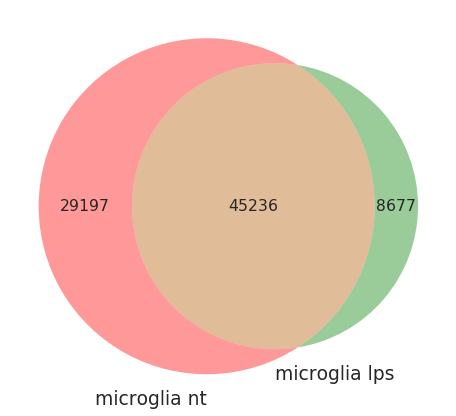

In [13]:
matplotlib_venn.venn2([set(summary_frame[summary_frame['cd452_nt'] > 0].index.values),
                       set(summary_frame[summary_frame['cd452_lps'] > 0].index.values)], 
                      set_labels=['microglia nt', 'microglia lps'])

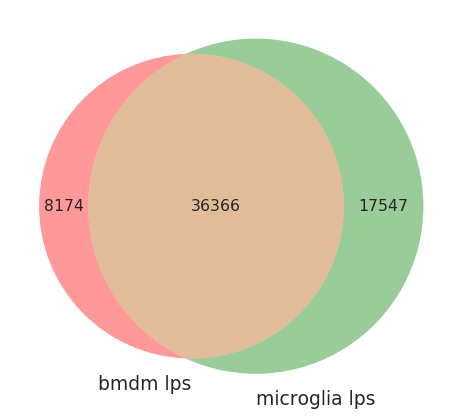

In [14]:
matplotlib_venn.venn2([set(summary_frame[summary_frame['cd451_lps'] > 0].index.values),
                       set(summary_frame[summary_frame['cd452_lps'] > 0].index.values)], 
                      set_labels=['bmdm lps', 'microglia lps'])

In [7]:
def quantile_normalize_df(df_input):
    df = df_input.copy()
    #compute rank
    dic = {}
    for col in df:
        dic.update({col : sorted(df[col])})
    sorted_df = pd.DataFrame(dic)
    rank = sorted_df.mean(axis = 1).tolist()
    #sort
    for col in df:
        t = np.searchsorted(np.sort(df[col]), df[col])
        df[col] = [rank[i] for i in t]
    return df

In [66]:
! annotatePeaks.pl merged_atac_peaks.tsv mm10 -size 1000 -hist 25 -ghist -d ./tag_directories_atac/*/ > ./ghist.tsv


	Peak file = merged_atac_peaks.tsv
	Genome = mm10
	Organism = mouse
	Peak Region set to 1000
	-----------------------------------------------------
	Histogram mode activated (bin size = 25 bp)
	-----------------------------------------------------
	Will create histogram for each gene
	Tag Directories:
		./tag_directories_atac/AS_CD451_LPS_1/
		./tag_directories_atac/AS_CD451_LPS_2/
		./tag_directories_atac/AS_CD451_LPS_3/
		./tag_directories_atac/AS_CD451_nt_4/
		./tag_directories_atac/AS_CD451_nt_5/
		./tag_directories_atac/AS_CD451_nt_6/
		./tag_directories_atac/AS_CD452_LPS_1/
		./tag_directories_atac/AS_CD452_LPS_2/
		./tag_directories_atac/AS_CD452_LPS_3/
		./tag_directories_atac/AS_CD452_nt_4/
		./tag_directories_atac/AS_CD452_nt_5/
		./tag_directories_atac/AS_CD452_nt_6/
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 104506
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 104506
		Redundant Peak IDs: 0
		Peaks lacki

In [76]:
! annotatePeaks.pl merged_atac_peaks.tsv mm10 -size 200  -d ./tag_directories_atac/*/ > ./annotated.tsv


	Peak file = merged_atac_peaks.tsv
	Genome = mm10
	Organism = mouse
	Peak Region set to 200
	Tag Directories:
		./tag_directories_atac/AS_CD451_LPS_1/
		./tag_directories_atac/AS_CD451_LPS_2/
		./tag_directories_atac/AS_CD451_LPS_3/
		./tag_directories_atac/AS_CD451_nt_4/
		./tag_directories_atac/AS_CD451_nt_5/
		./tag_directories_atac/AS_CD451_nt_6/
		./tag_directories_atac/AS_CD452_LPS_1/
		./tag_directories_atac/AS_CD452_LPS_2/
		./tag_directories_atac/AS_CD452_LPS_3/
		./tag_directories_atac/AS_CD452_nt_4/
		./tag_directories_atac/AS_CD452_nt_5/
		./tag_directories_atac/AS_CD452_nt_6/
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 104506
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 104506
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file l

In [15]:
# average tag counts from both replicates
tag_frame = pd.read_csv('annotated.tsv', sep='\t')
tag_frame.index = tag_frame.iloc[:,0].values

annotations = tag_frame['Annotation']
annotation_genes = tag_frame['Gene Name']
annotation_gene_distances = tag_frame['Distance to TSS']

tag_frame = tag_frame[[x for x in tag_frame.columns.values if 'Tag Count' in x]]
columns = [x.split(' ')[0].split('/')[2].lower() for x in tag_frame.columns.values]
tag_frame.columns = columns

factor_treatments = sorted(set(['_'.join(x.split('_')[1:3]) for x in columns]))

meanTag_dict = {}
for ft in factor_treatments:
    cleaned_ft = ft.replace('thiomac_chip_','').replace('-1h','')

    meanTag_dict[cleaned_ft] = tag_frame[[x for x in tag_frame.columns if ft in x]].mean(axis=1).values
meanTag_frame = pd.DataFrame(meanTag_dict)
meanTag_frame.index = tag_frame.index.values

quantileTag_frame = quantile_normalize_df(meanTag_frame)

In [16]:
ghist_frame = pd.read_csv('./ghist.tsv', sep='\t')
ghist_frame.index = ghist_frame['Gene'].values
ghist_frame.drop('Gene', axis=1, inplace=True)

In [17]:
ghist_frame.shape

(104506, 492)

In [18]:
ghist_frame.shape

(104506, 492)

In [19]:
492/6

82.0

In [20]:
ghist_frame.head()

-500  -475  -450  -425  -400  -375       -350  -325  \
Merged-chr17-48411509-1   0.0   0.0   0.0   0.0   0.0   0.0   0.000000   0.0   
Merged-chr11-63264868-1   0.0   0.0   0.0   0.0   0.0   0.0  11.538462  20.0   
Merged-chr7-109863786-1   0.0   0.0   0.0   0.0   0.0   0.0   0.000000   0.0   
Merged-chr19-32328319-1   0.0   0.0   0.0   0.0   0.0   0.0   0.000000   0.0   
Merged-chr8-37063986-1    0.0   0.0   0.0   0.0   0.0   0.0   0.000000   0.0   

                              -300       -275      ...             275.11  \
Merged-chr17-48411509-1   0.000000   0.000000      ...      -2.442491e-15   
Merged-chr11-63264868-1  24.615385  24.615385      ...       1.617647e+00   
Merged-chr7-109863786-1   0.000000   0.000000      ...       4.044118e+00   
Merged-chr19-32328319-1   0.000000   0.000000      ...      -8.881784e-16   
Merged-chr8-37063986-1    0.000000   0.000000      ...       8.088235e-01   

                               300.11        325.11        350.11  \
Merged-chr17-48411509-1 -2.442491e-15 -2.442491e-15 -2.442491e-15   
Merged-chr11-63264868-1  8.088235e-01 -1.110223e-15 -1.110223e-15   
Merged-chr7-109863786-1  3.235294e+00  7.279412e+00  8.088235e+00   
Merged-chr19-32328319-1 -8.881784e-16 -8.881784e-16 -8.881784e-16   
Merged-chr8-37063986-1   8.088235e-01  8.088235e-01 -8.881784e-16   

                               375.11        400.11        425.11  \
Merged-chr17-48411509-1 -2.442491e-15 -2.442491e-15 -2.442491e-15   
Merged-chr11-63264868-1 -1.110223e-15 -1.110223e-15 -1.110223e-15   
Merged-chr7-109863786-1  7.279412e+00  9.705882e+00  7.279412e+00   
Merged-chr19-32328319-1 -8.881784e-16 -8.881784e-16 -8.881784e-16   
Merged-chr8-37063986-1  -8.881784e-16  8.088235e-01  8.088235e-01   

                               450.11        475.11        500.11  
Merged-chr17-48411509-1 -2.442491e-15 -2.442491e-15 -2.442491e-15  
Merged-chr11-63264868-1 -1.110223e-15 -1.110223e-15 -1.110223e-15  
Merged-chr7-109863786-1  6.470588e+00  4.044118e+00 -3.552714e-15  
Merged-chr19-32328319-1 -8.881784e-16 -8.881784e-16 -8.881784e-16  
Merged-chr8-37063986-1   8.088235e-01  8.088235e-01 -8.881784e-16  

[5 rows x 492 columns]

### All peaks

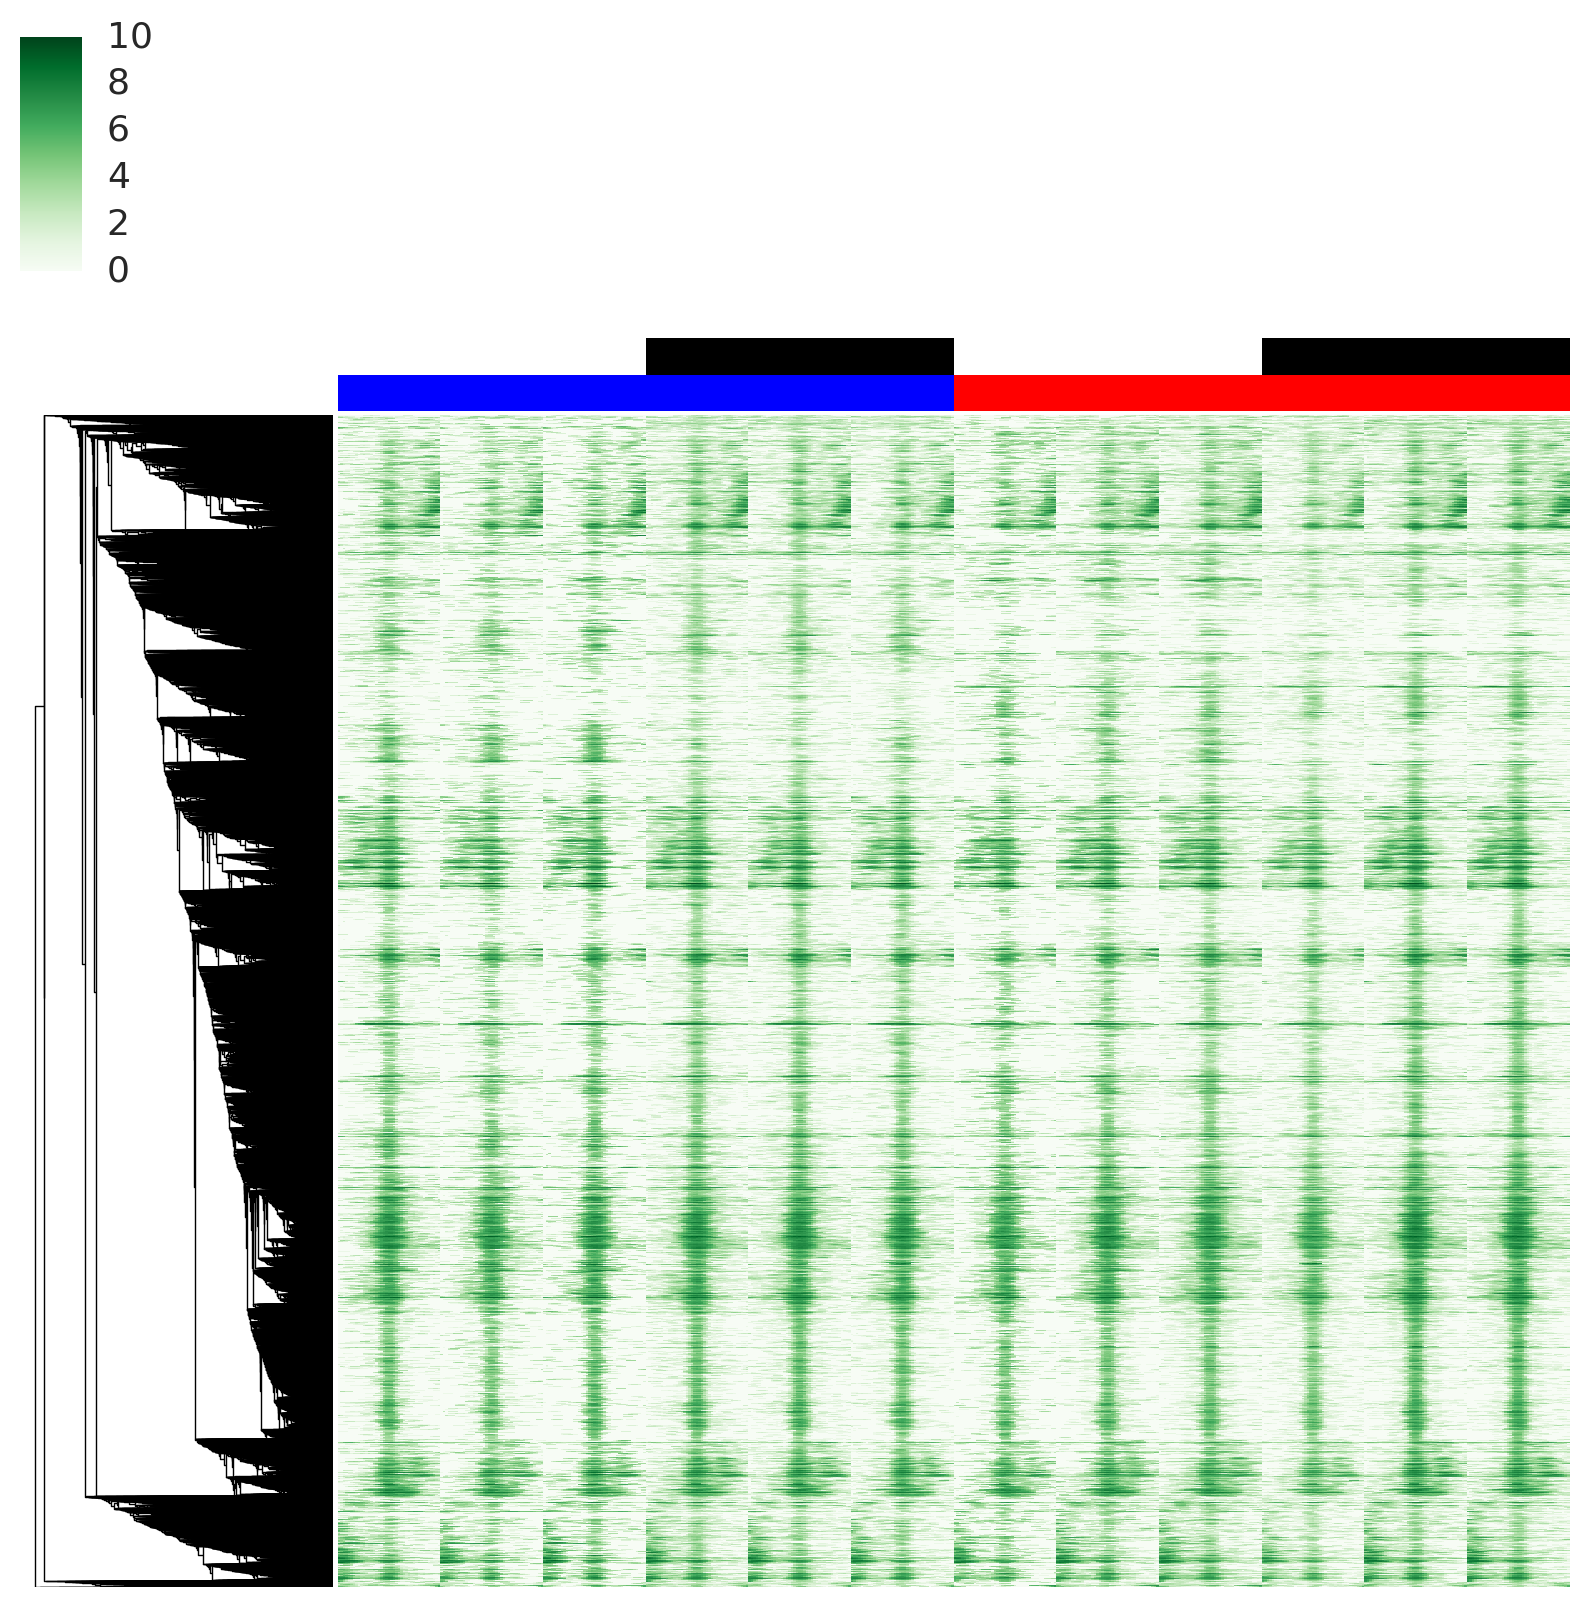

In [74]:
logged_data = np.log2(ghist_frame+1)
logged_data['mean'] = logged_data.mean(axis=1)
logged_data.sort_values(by='mean', ascending = False, inplace=True)
logged_data.drop('mean', axis=1, inplace=True)
sns.clustermap(logged_data, 
               yticklabels = False,
               xticklabels = False,
               col_cluster=False,
               row_cluster = True,
               metric = 'correlation',
               vmin = 0,
               cmap='Greens',
               vmax=10,
               col_colors = [['white']*123 + ['black']*123 + ['white']*123 + ['black']*123,
                             ['blue']*123*2 + ['red']*123*2]
               )

plt.show()

### Enhancers

In [17]:
intergenic_indices = annotations[annotations=='Intergenic'].index.values

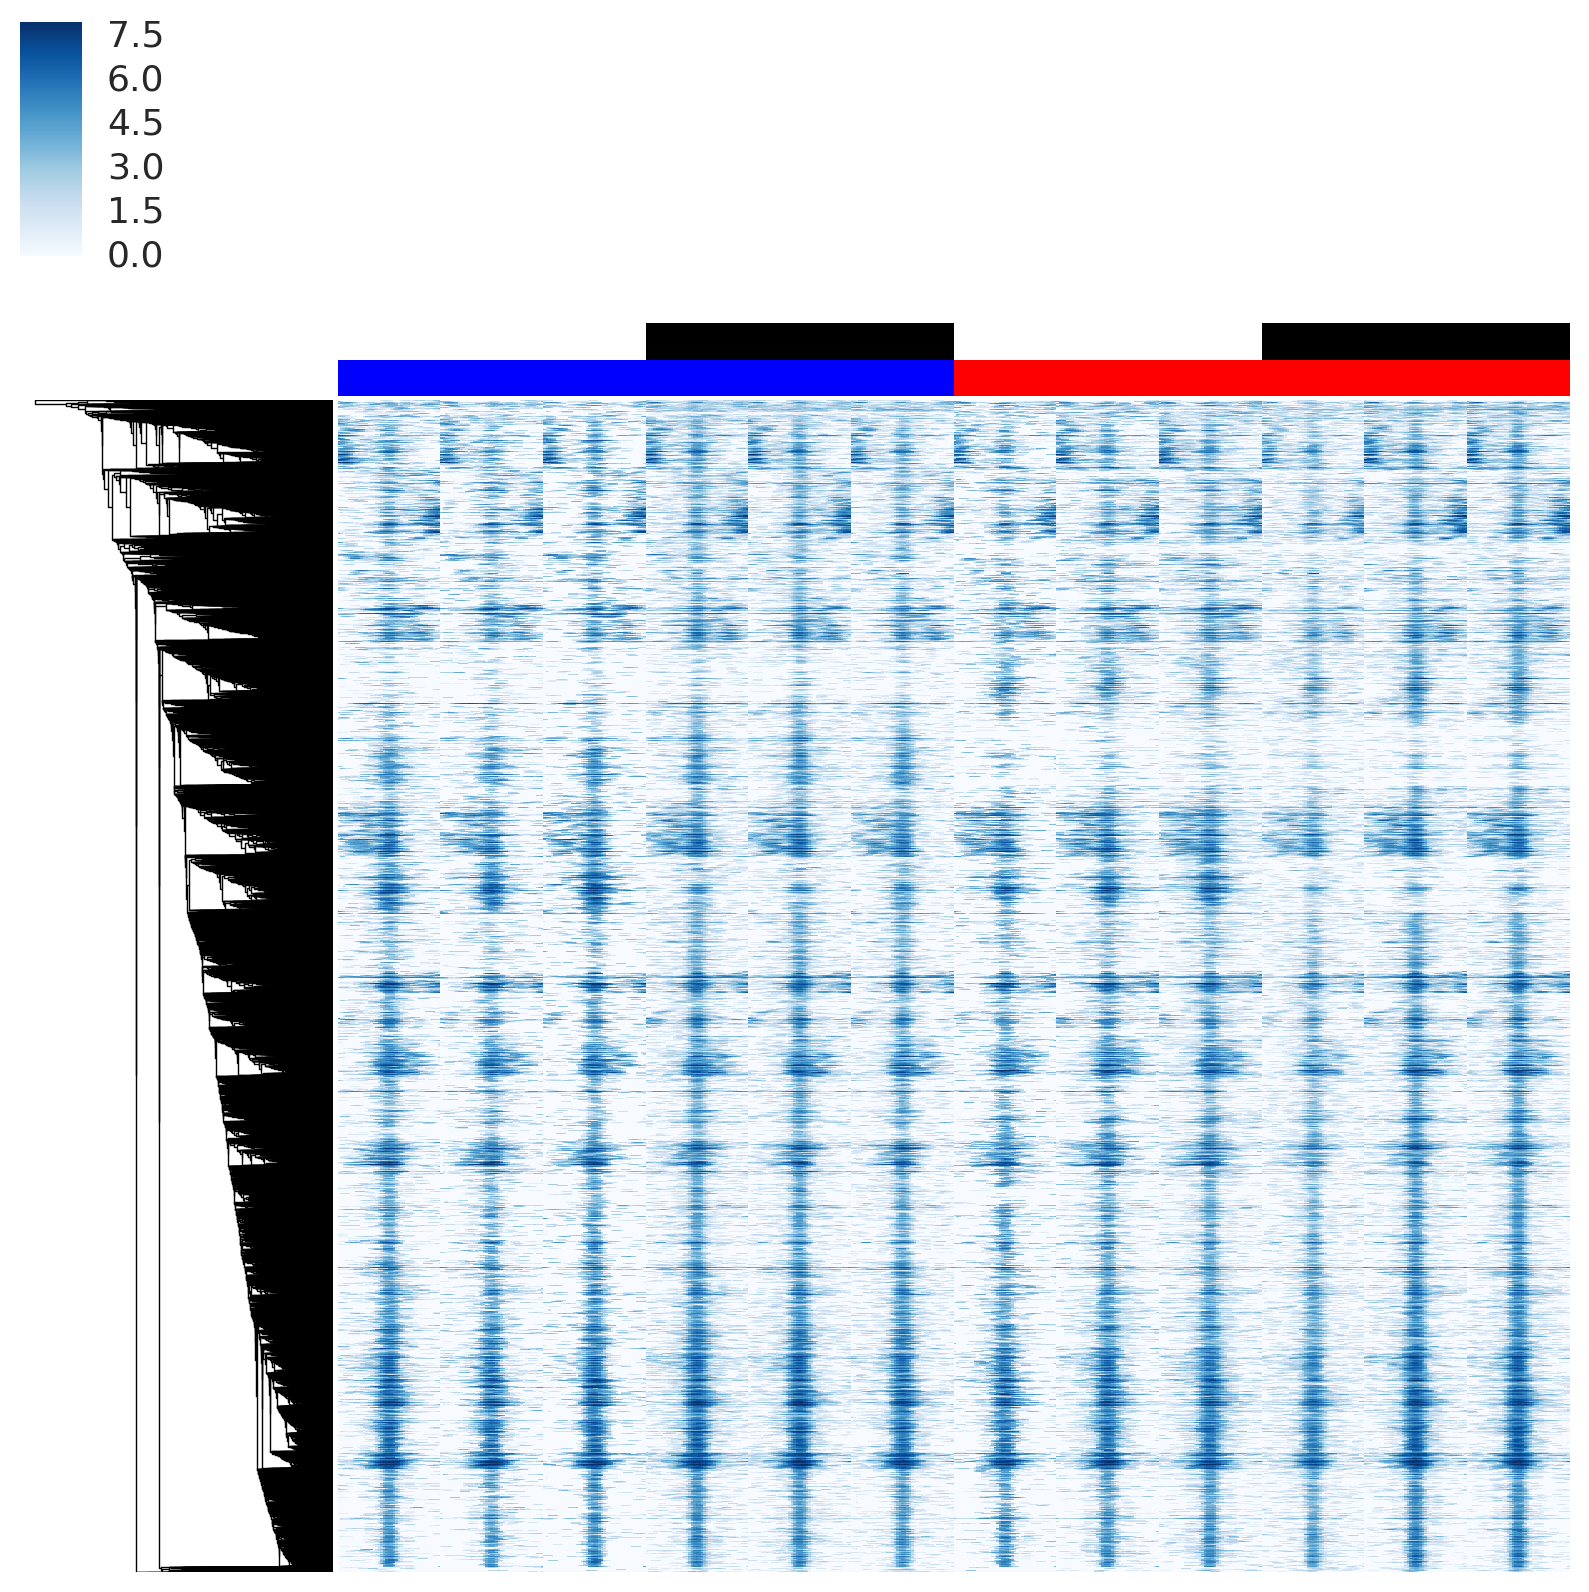

In [21]:
logged_data = np.log2(ghist_frame.loc[intergenic_indices,:]+1)
logged_data['mean'] = logged_data.mean(axis=1)
logged_data.sort_values(by='mean', ascending = False, inplace=True)
logged_data.drop('mean', axis=1, inplace=True)
sns.clustermap(logged_data, 
               yticklabels = False,
               xticklabels = False,
               col_cluster=False,
               row_cluster = True,
               metric = 'correlation',
               vmin = 0,
               cmap='Blues',
               vmax=8,
               col_colors = [['white']*123 + ['black']*123 + ['white']*123 + ['black']*123,
                             ['blue']*123*2 + ['red']*123*2]
               )

plt.show()

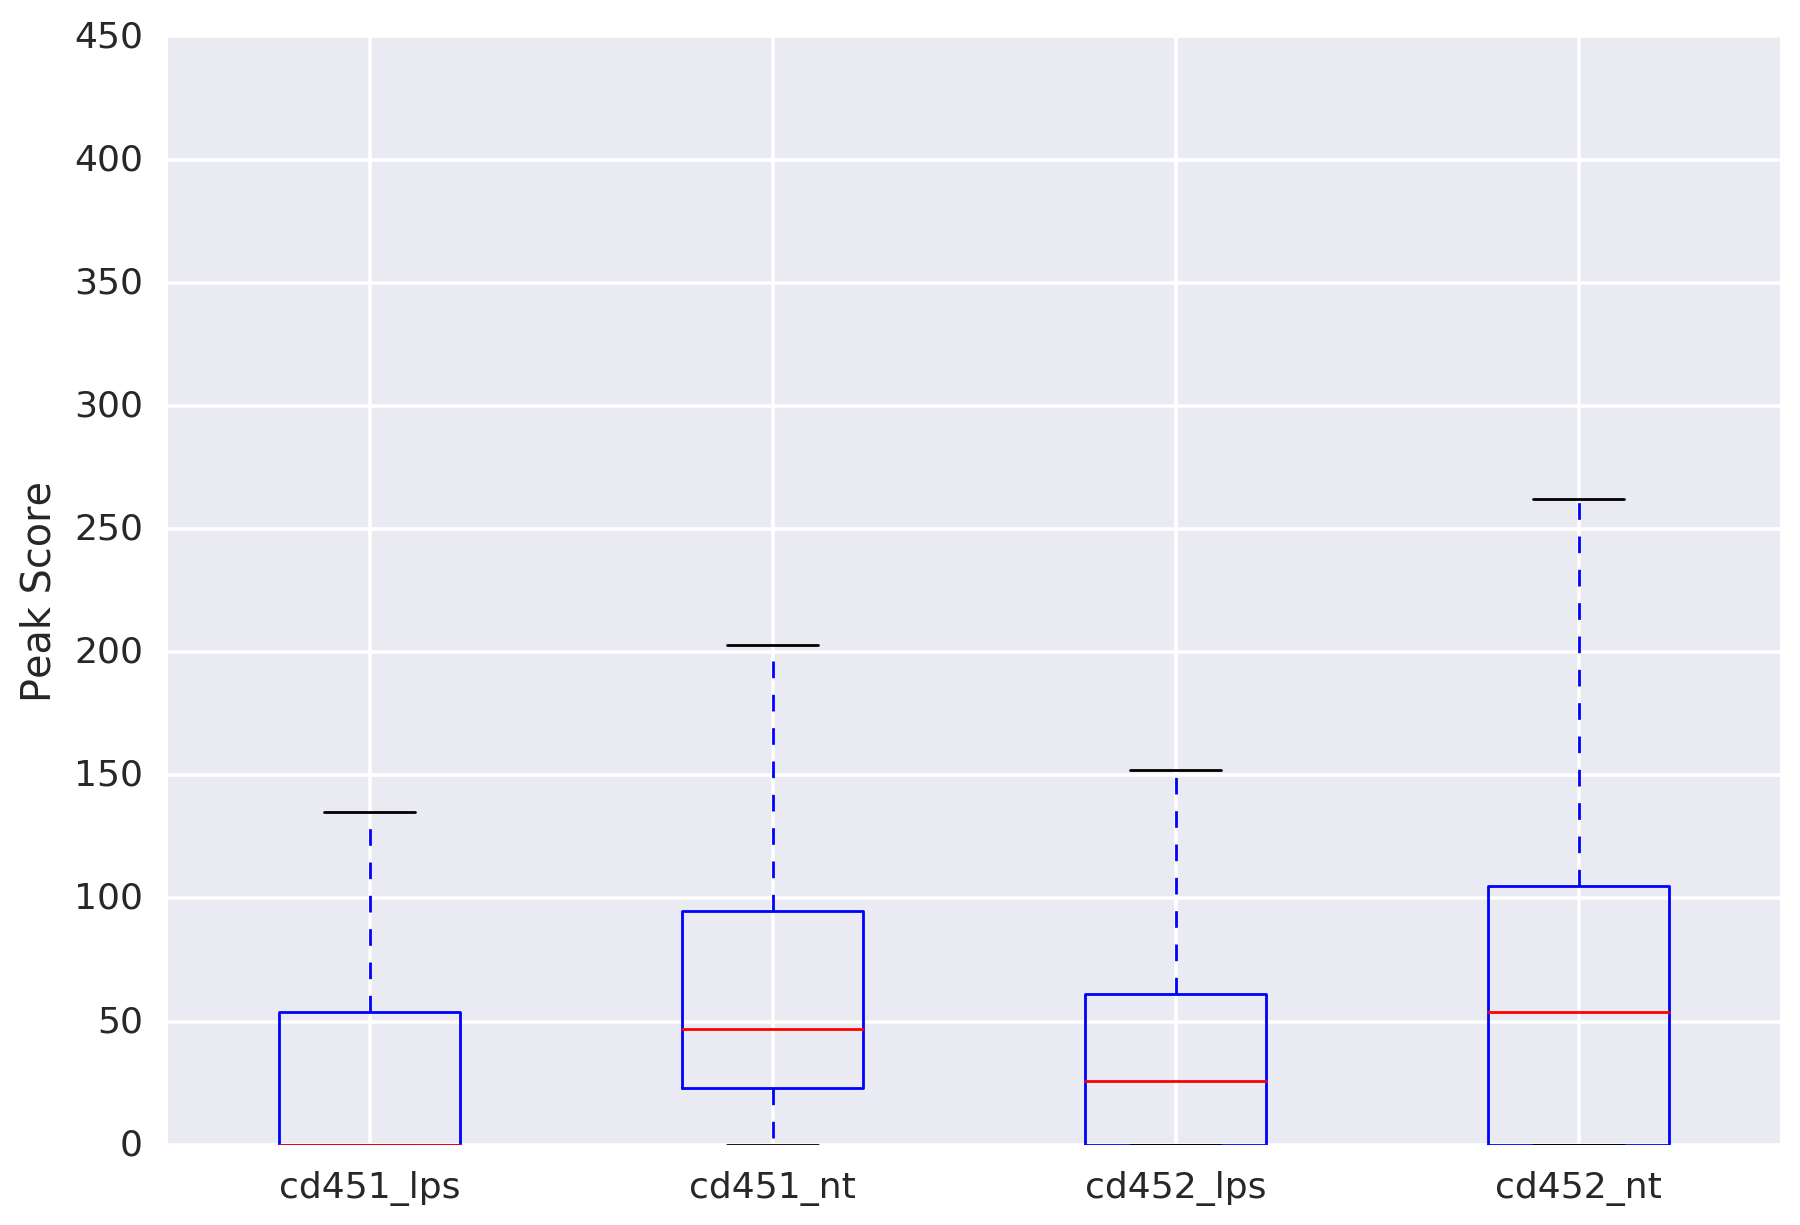

In [75]:
scores = []
for col in summary_frame.columns[5:]:
    scores.append(summary_frame[col].values)
plt.boxplot(scores);
plt.xticks(range(1,5),summary_frame.columns[5:].values);
plt.ylabel('Peak Score')

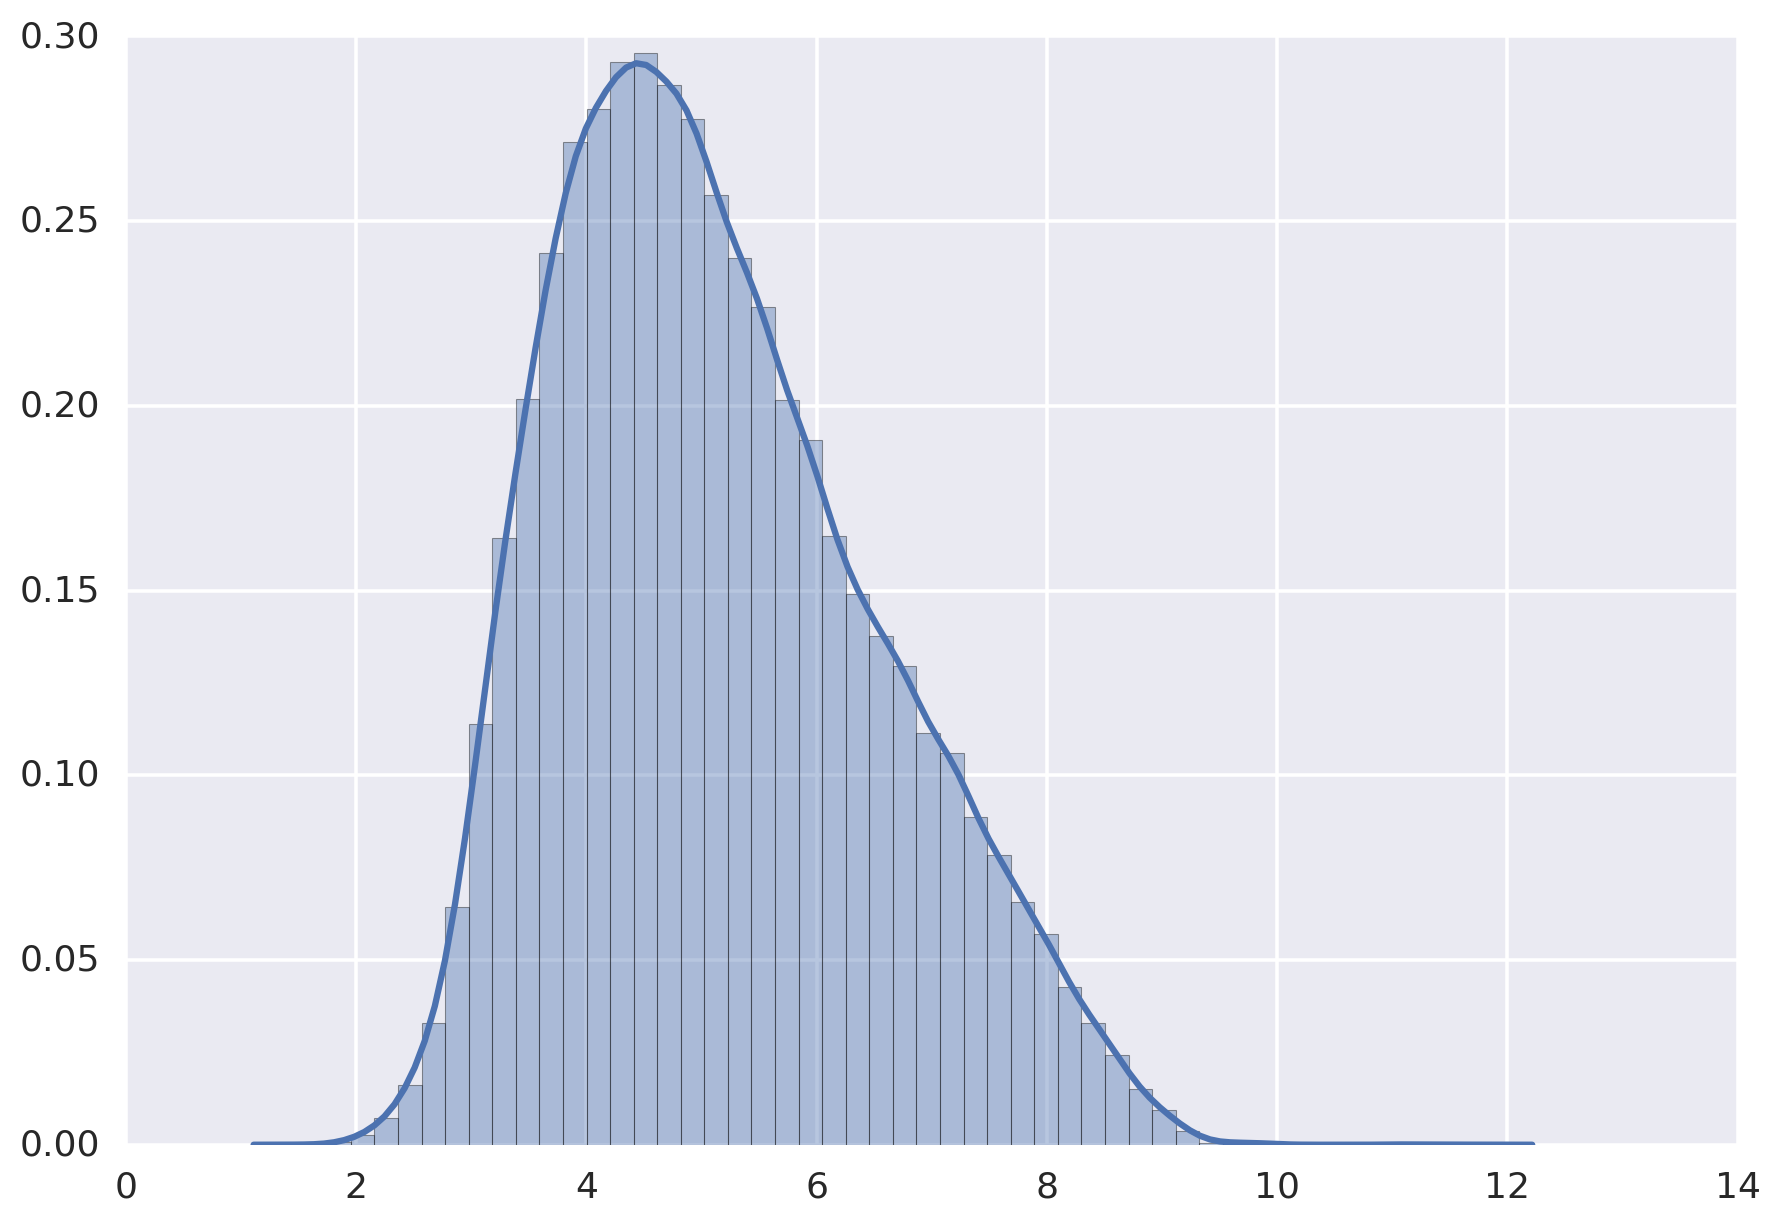

In [79]:
sns.distplot(np.log2(quantileTag_frame.max(axis=1)+1))

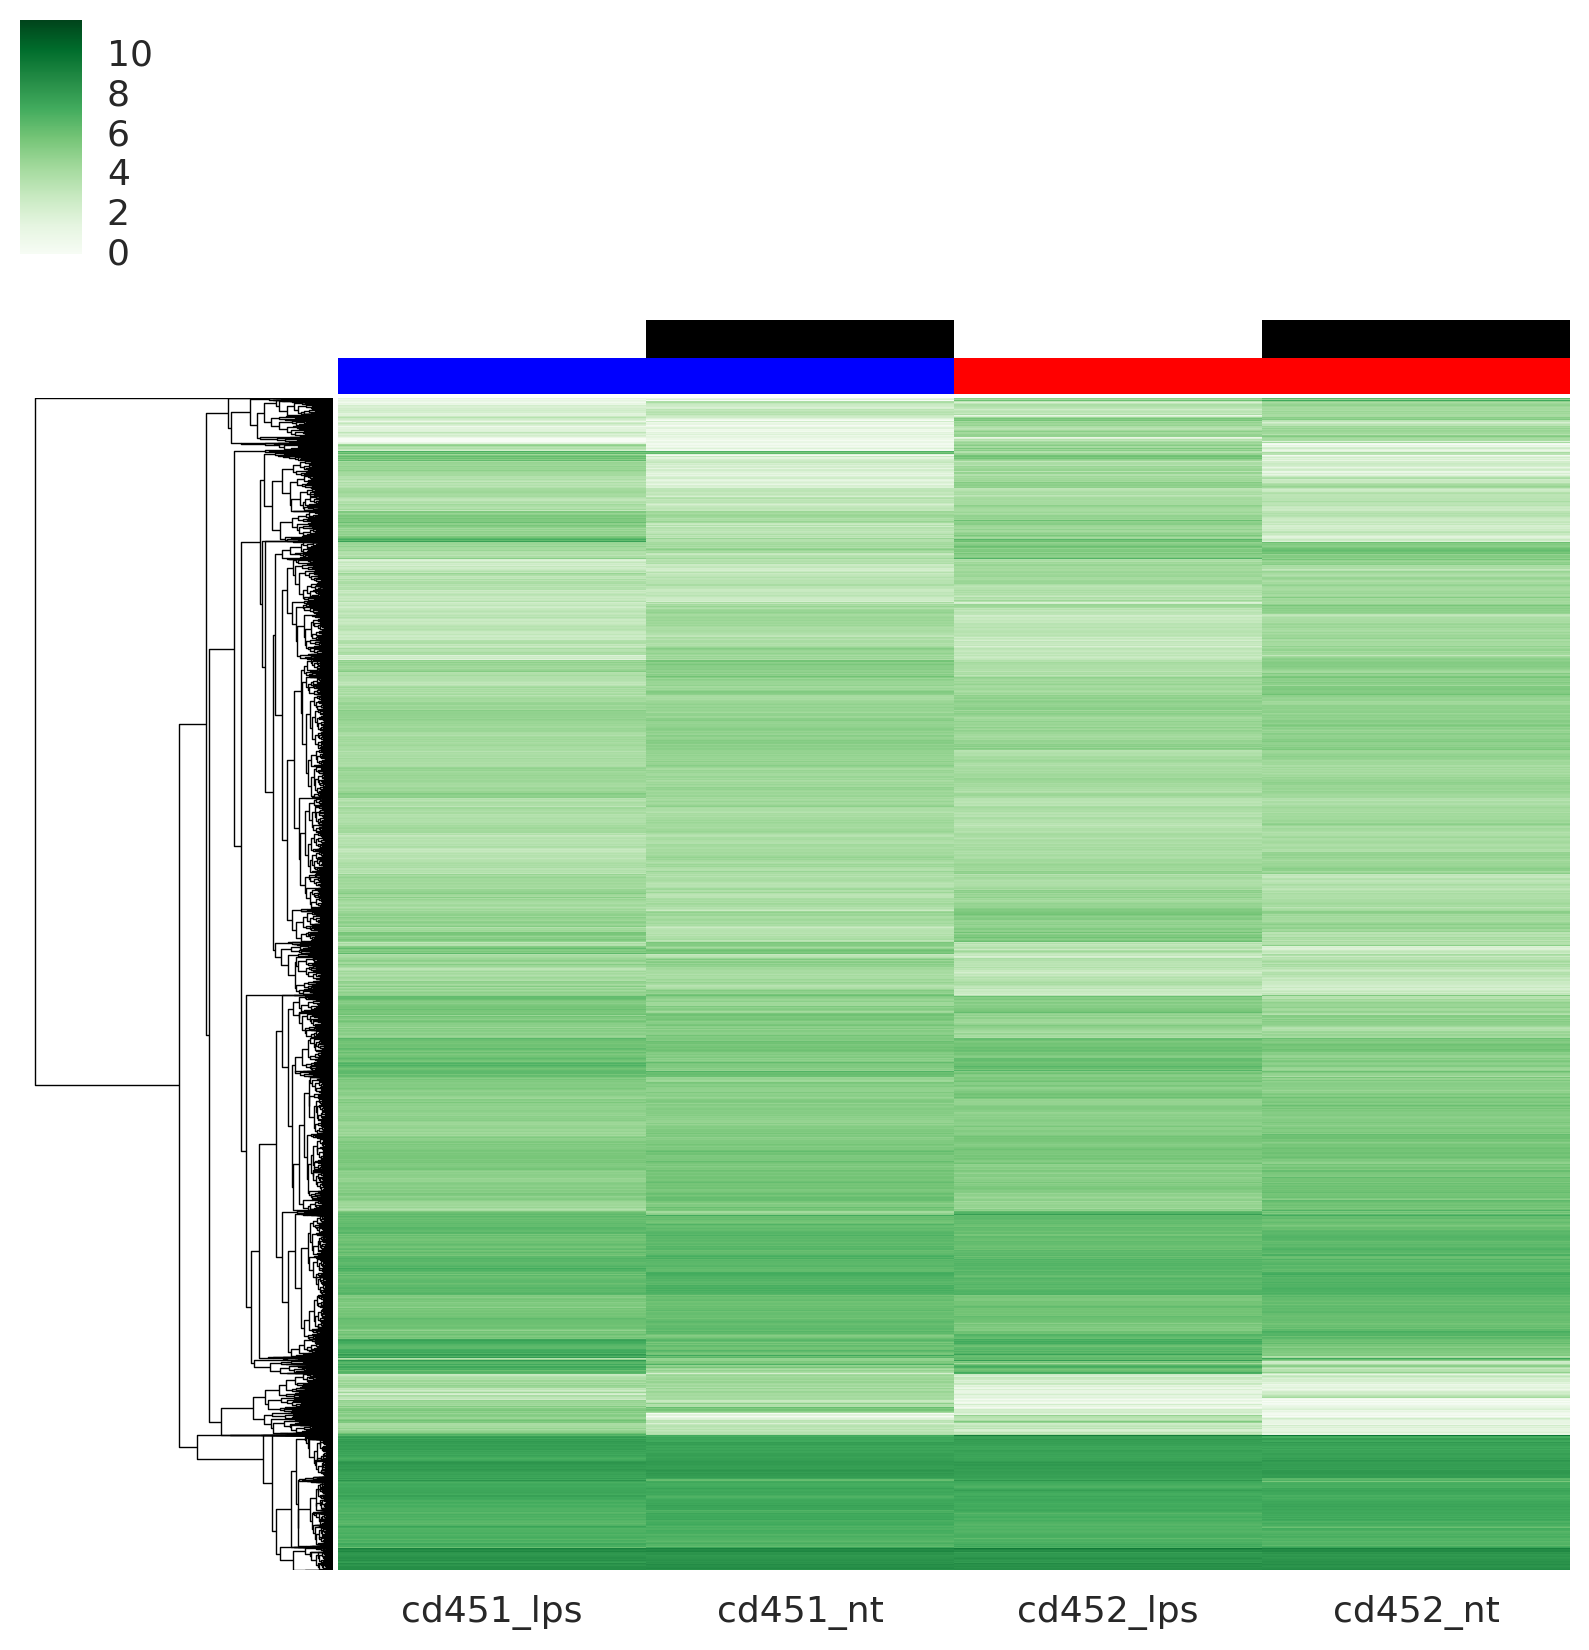

In [92]:
sns.clustermap(np.log2(quantileTag_frame[quantileTag_frame.max(axis=1)>=16]+1), col_cluster=False,yticklabels=False,
               cmap='Greens',
               col_colors=[['white', 'black', 'white', 'black'],
                          ['blue', 'blue', 'red', 'red']])

## Create Enhancer and Promoter Bed Files

In [93]:
annotated_frame = pd.read_csv('annotated.tsv', sep='\t')

In [94]:
intergenic_ids = annotated_frame[annotated_frame['Annotation'].str.contains('Intergenic')].iloc[:,0].values

In [95]:
promoter_ids = annotated_frame[annotated_frame['Annotation'].str.contains('promoter')].iloc[:,0].values

### Enhancers

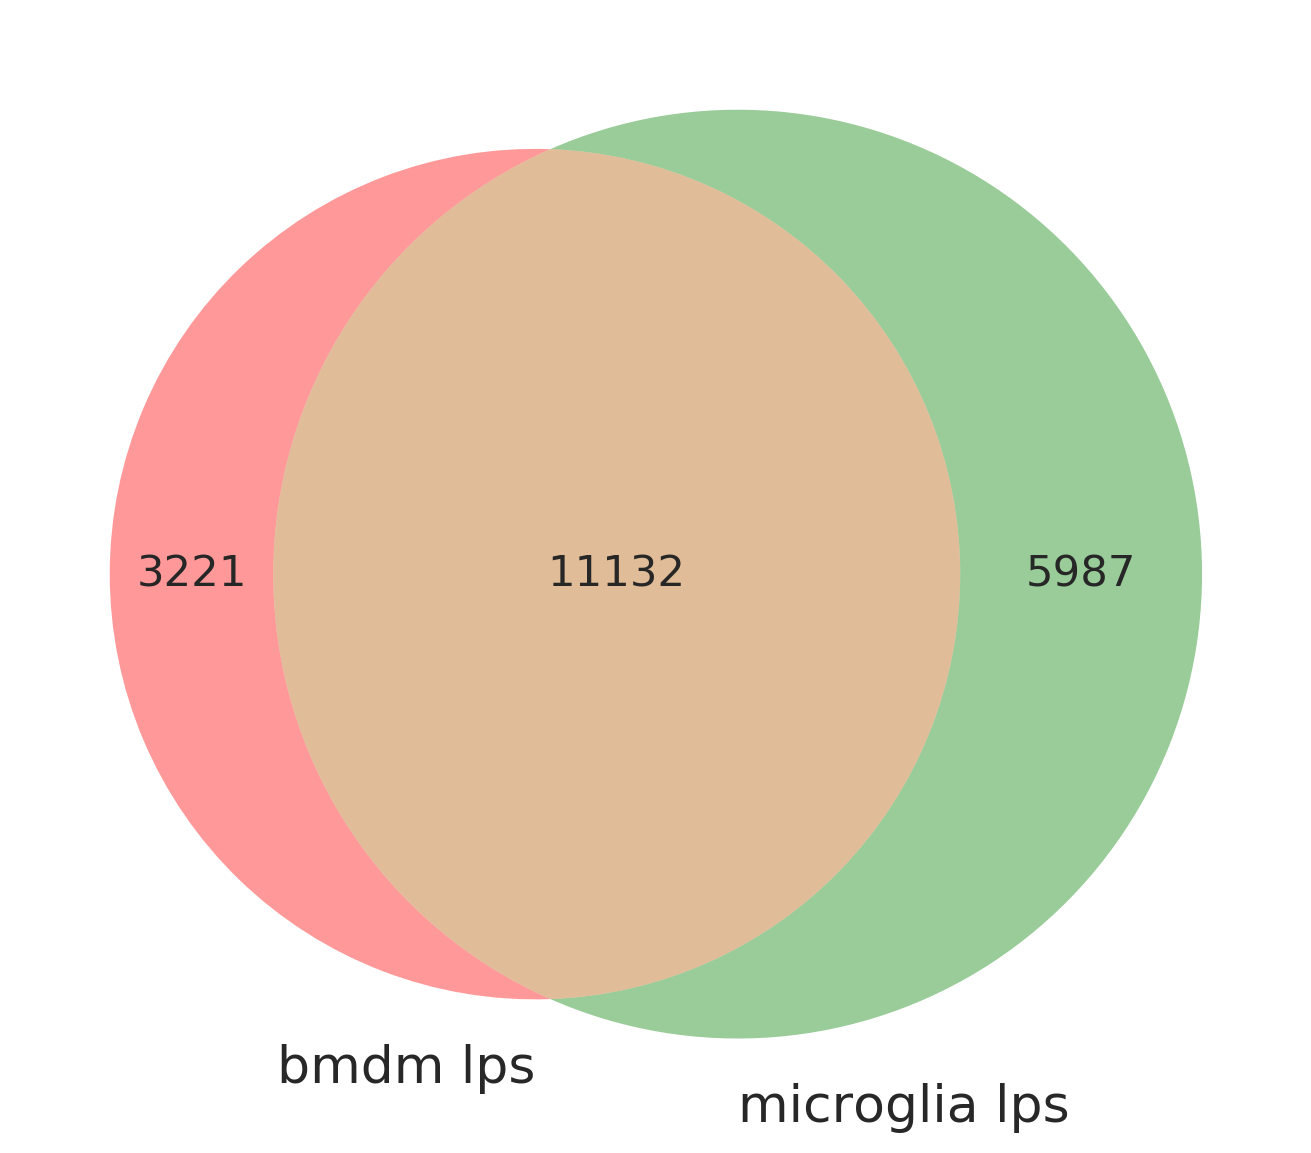

In [96]:
matplotlib_venn.venn2([set(summary_frame[summary_frame['cd451_lps'] > 0].index.values).intersection(set(intergenic_ids)),
                       set(summary_frame[summary_frame['cd452_lps'] > 0].index.values).intersection(set(intergenic_ids))], 
                      set_labels=['bmdm lps', 'microglia lps'])

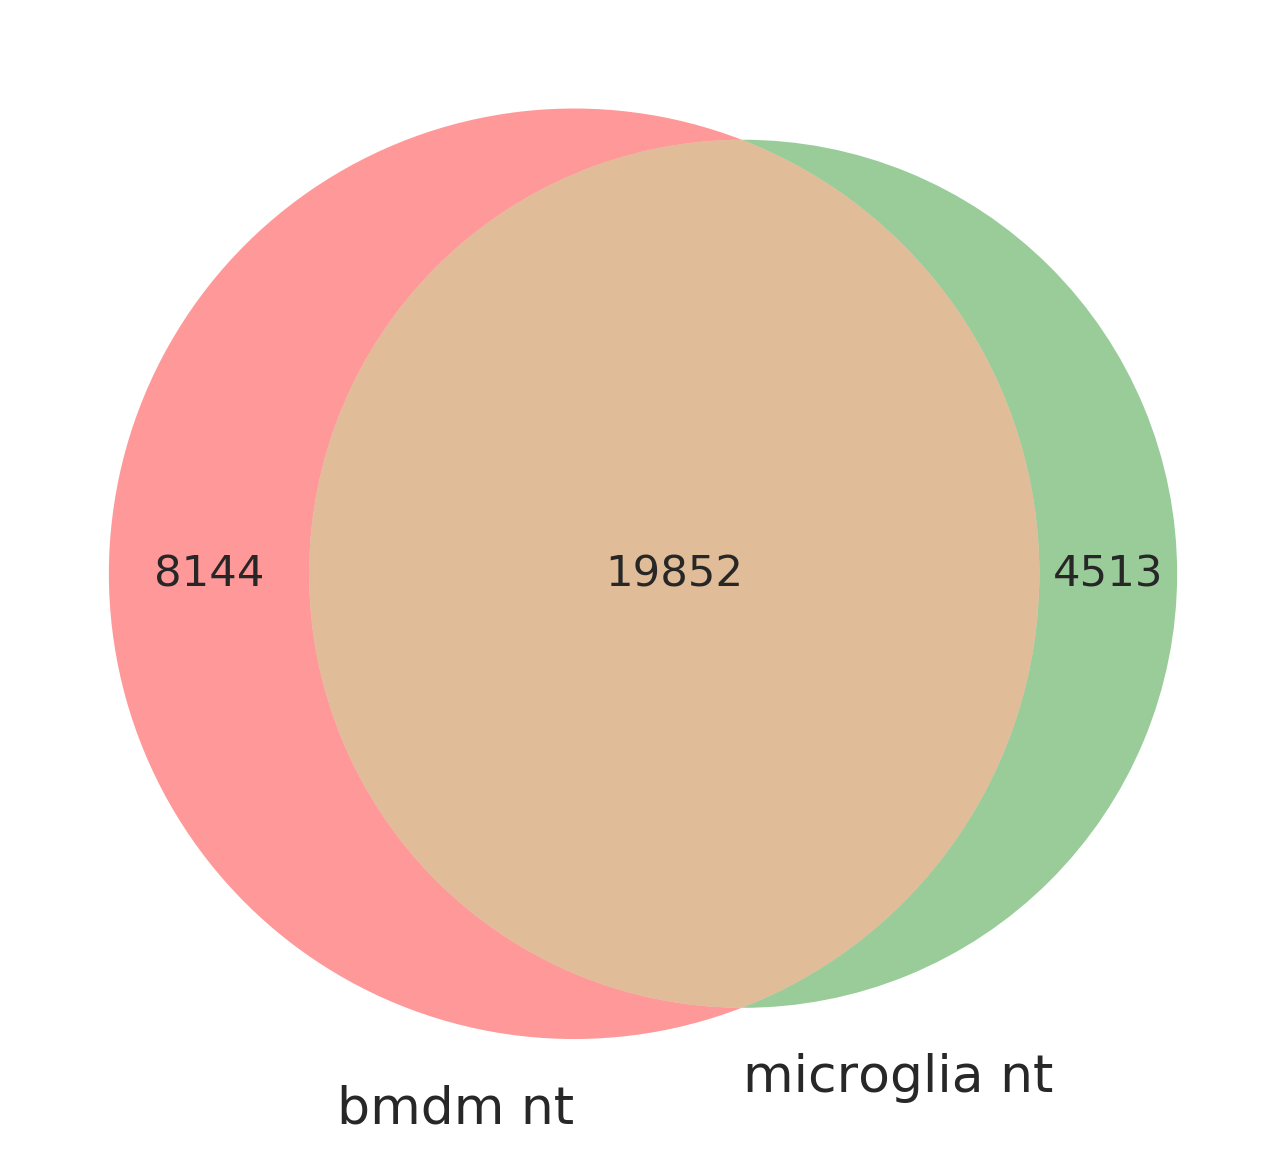

In [97]:
matplotlib_venn.venn2([set(summary_frame[summary_frame['cd451_nt'] > 0].index.values).intersection(set(intergenic_ids)),
                       set(summary_frame[summary_frame['cd452_nt'] > 0].index.values).intersection(set(intergenic_ids))], 
                      set_labels=['bmdm nt', 'microglia nt'])

### Promoters

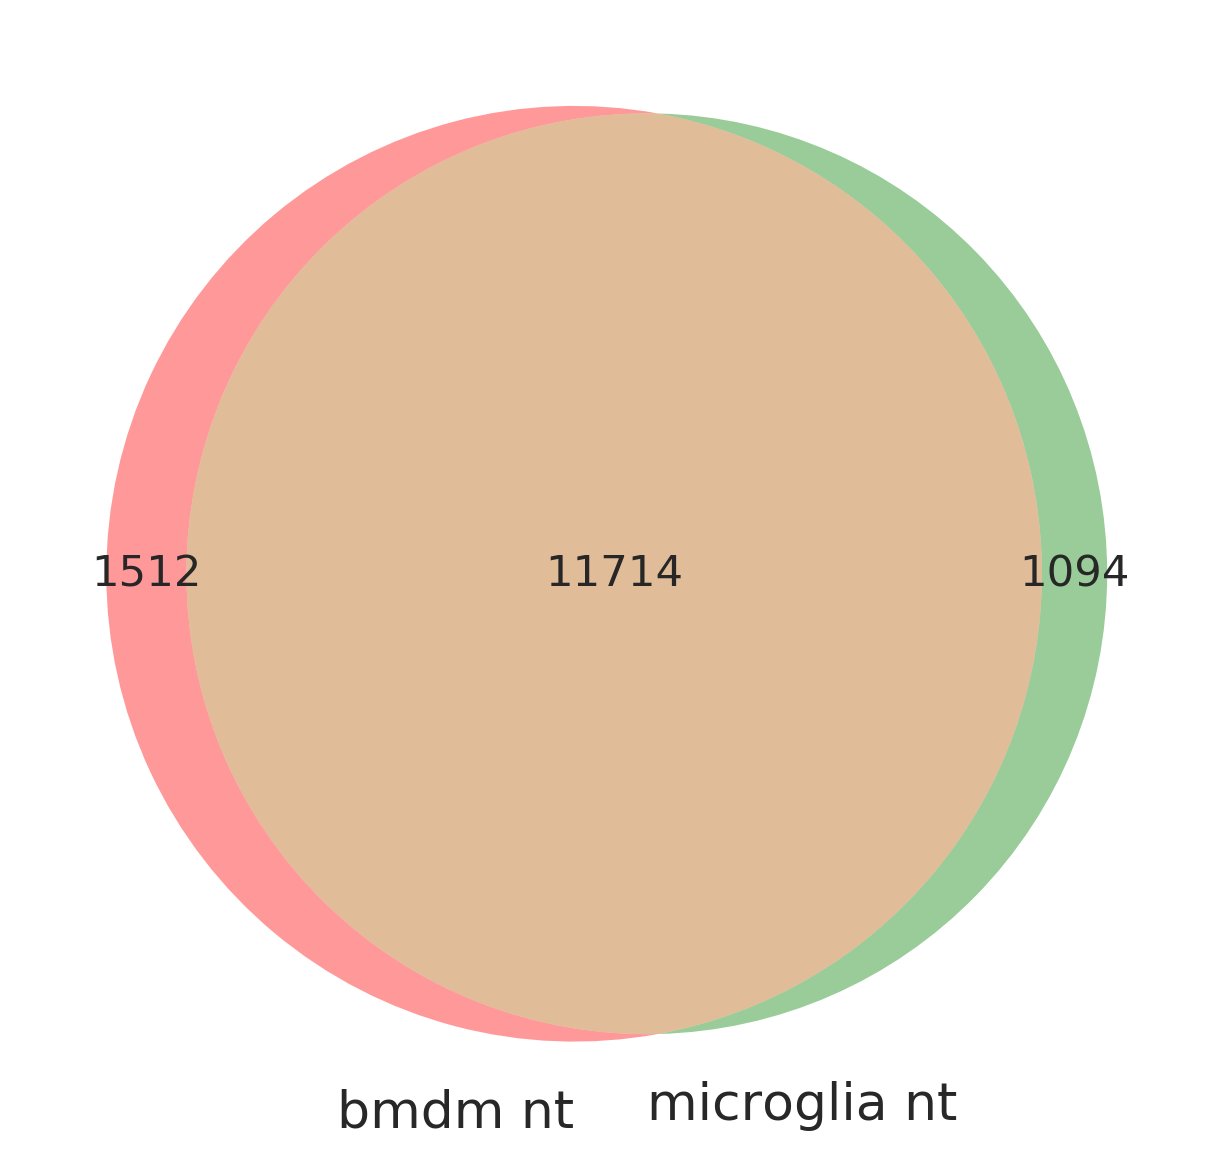

In [98]:
matplotlib_venn.venn2([set(summary_frame[summary_frame['cd451_nt'] > 0].index.values).intersection(set(promoter_ids)),
                       set(summary_frame[summary_frame['cd452_nt'] > 0].index.values).intersection(set(promoter_ids))], 
                      set_labels=['bmdm nt', 'microglia nt'])

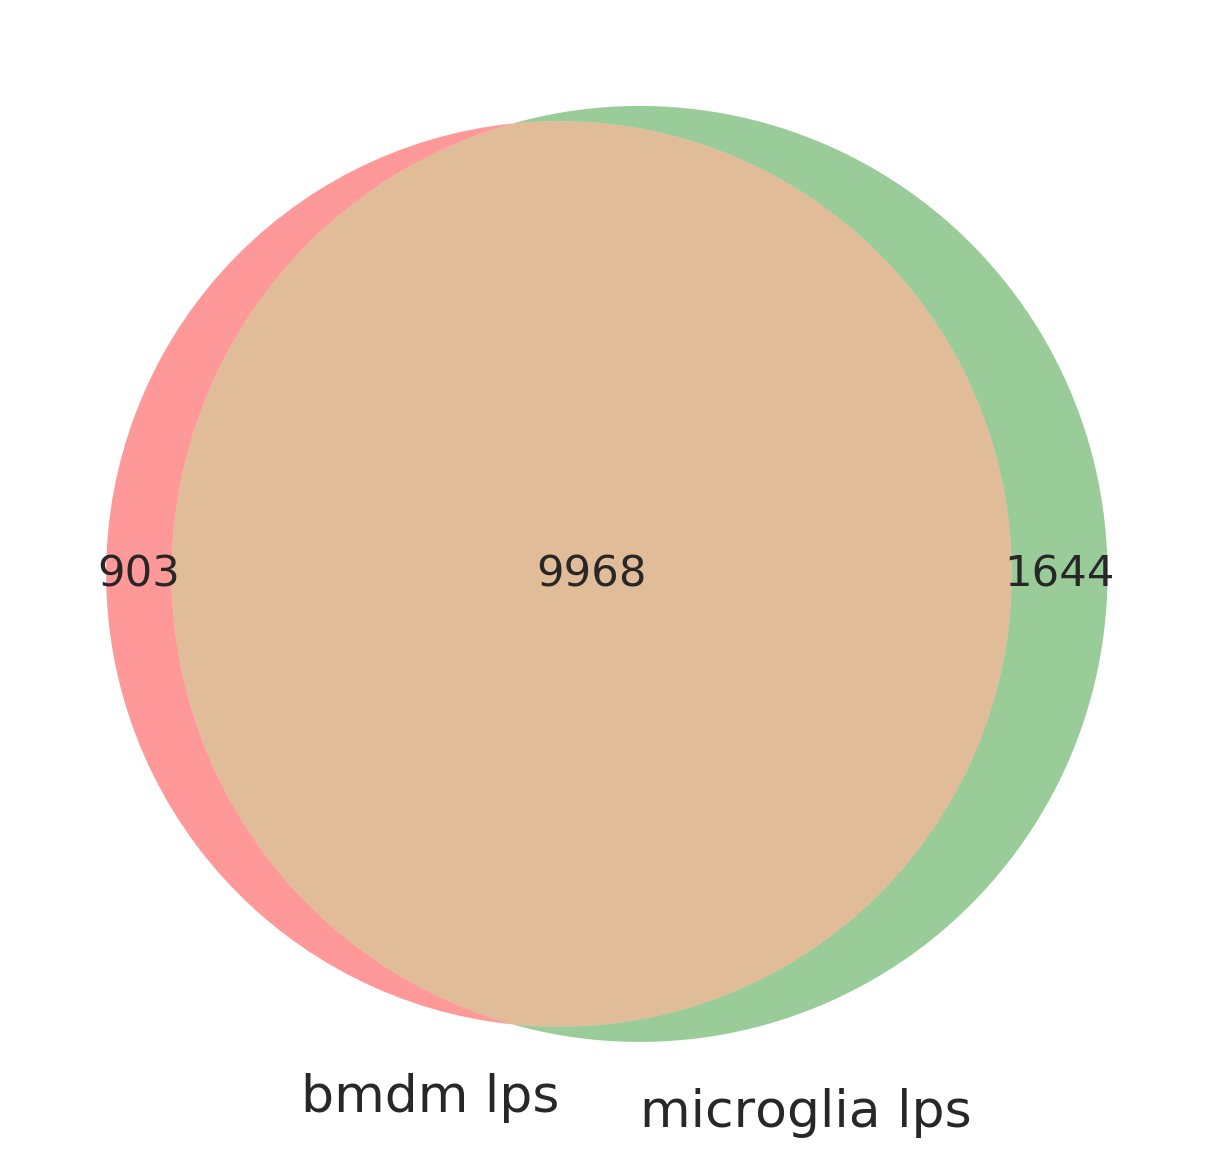

In [99]:
matplotlib_venn.venn2([set(summary_frame[summary_frame['cd451_lps'] > 0].index.values).intersection(set(promoter_ids)),
                       set(summary_frame[summary_frame['cd452_lps'] > 0].index.values).intersection(set(promoter_ids))], 
                      set_labels=['bmdm lps', 'microglia lps'])

## Create Bed Files

#### promoters

In [ ]:
annotations

In [108]:
if not os.path.isdir('./bed_files_promoters'):
    os.mkdir('./bed_files_promoters')
for cond in summary_frame.columns[5:]:
    frame = summary_frame[(summary_frame[cond] > 0) &
                          (summary_frame.index.isin(promoter_ids))][['chr', 'start', 'end']]
    frame.columns = ['#chr', 'start', 'end']
    frame['ID'] = summary_frame['chr'].astype(str) + ':' + \
        (summary_frame['start'] - 1).astype(str) + '-' + summary_frame['end'].astype(str)
    frame['strand'] = '+'
    frame.to_csv('./bed_files_promoters/' + cond + '_promoter.bed', index=False, sep='\t')

#### Enhancers

In [111]:
if not os.path.isdir('./bed_files_enhancers'):
    os.mkdir('./bed_files_enhancers')
for cond in summary_frame.columns[5:]:
    frame = summary_frame[(summary_frame[cond] > 0) &
                          (summary_frame.index.isin(intergenic_ids))][['chr', 'start', 'end']]
    frame.columns = ['#chr', 'start', 'end']
    frame['ID'] = summary_frame['chr'].astype(str) + ':' + \
        (summary_frame['start'] - 1).astype(str) + '-' + summary_frame['end'].astype(str)
    frame['strand'] = '+'
    frame.to_csv('./bed_files_enhancers/' + cond + '_enhancer.bed', index=False, sep='\t')

## Run TBA Again

### promoters

In [112]:
%%bash
# delete the existing script file
rm ./run_tba_promoters.sh
# create a script file
touch ./run_tba_promoters.sh

# if directories don't exist, create them
if [ ! -d ./tba_output_promoters/ ]; then mkdir ./tba_output_promoters; fi

# for each peak file create several commands
for bed_file in ./bed_files_promoters/*;
do 
# generate peak sequence fasta file name
seq_file=${bed_file/promoter.bed/promoter.fasta};
seq_file=${seq_file/bed_files_promoters/tba_output_promoters};

# execute command to extract sequences
echo "/home/jtao/code/tba/model_training/extract_sequences.py $bed_file mm10 $seq_file">> ./run_tba_promoters.sh

# generate background coordinates
echo "/home/jtao/code/tba/model_training/generate_background_coordinates.py $bed_file mm10 ./tba_output_promoters/">> ./run_tba_promoters.sh

# rename background file
bg_seq_file=${seq_file/promoter.fasta/background.fasta};
echo "mv ./tba_output_promoters/background.fasta $bg_seq_file">> ./run_tba_promoters.sh
echo "/home/jtao/code/tba/model_training/create_features.py -num_procs 40 $seq_file $bg_seq_file ./tba_output_promoters /home/jtao/code/tba/default_motifs/*">> ./run_tba_promoters.sh

# calculate motif scores for peaks and background
combined_features=${seq_file/.fasta/_combined_features.tsv}
labels=${combined_features/combined_features.tsv/labels.txt}
echo "/home/jtao/code/tba/model_training/train_classifier.py $combined_features $labels ./tba_output_promoters/">> ./run_tba_promoters.sh
coeff_path=${combined_features/combined_features.tsv/coefficients.tsv}
performance_path=${combined_features/combined_features.tsv/performance.tsv}
echo "mv ./tba_output_promoters/coefficients.tsv $coeff_path">> ./run_tba_promoters.sh
echo "mv ./tba_output_promoters/performance.tsv $performance_path">> ./run_tba_promoters.sh

# perform insilico mutagenesis
echo "/home/jtao/code/tba/model_training/calc_feature_significance.py -num_procs 12 -num_iterations 5 $combined_features $labels ./tba_output_promoters/">> ./run_tba_promoters.sh
significance_path=${combined_features/combined_features.tsv/significance.tsv}
echo mv ./tba_output_promoters/significance.tsv $significance_path>> ./run_tba_promoters.sh

done

### Enhancers

In [2]:
%%bash
# delete the existing script file
rm ./run_tba_enhancers.sh
# create a script file
touch ./run_tba_enhancers.sh

# if directories don't exist, create them
if [ ! -d ./tba_output_enhancers/ ]; then mkdir ./tba_output_enhancers; fi

# for each peak file create several commands
for bed_file in ./bed_files_enhancers/*;
do 
# generate peak sequence fasta file name
seq_file=${bed_file/enhancer.bed/enhancer.fasta};
seq_file=${seq_file/bed_files_enhancers/tba_output_enhancers};

# execute command to extract sequences
echo "/home/jtao/code/tba/model_training/extract_sequences.py $bed_file mm10 $seq_file">> ./run_tba_enhancers.sh

# generate background coordinates
echo "/home/jtao/code/tba/model_training/generate_background_coordinates.py $bed_file mm10 ./tba_output_enhancers/">> ./run_tba_enhancers.sh

# rename background file
bg_seq_file=${seq_file/enhancer.fasta/background.fasta};
echo "mv ./tba_output_enhancers/background.fasta $bg_seq_file">> ./run_tba_enhancers.sh
echo "/home/jtao/code/tba/model_training/create_features.py -num_procs 40 $seq_file $bg_seq_file ./tba_output_enhancers /home/jtao/code/tba/default_motifs/*">> ./run_tba_enhancers.sh

# calculate motif scores for peaks and background
combined_features=${seq_file/.fasta/_combined_features.tsv}
labels=${combined_features/combined_features.tsv/labels.txt}
echo "/home/jtao/code/tba/model_training/train_classifier.py $combined_features $labels ./tba_output_enhancers/">> ./run_tba_enhancers.sh
coeff_path=${combined_features/combined_features.tsv/coefficients.tsv}
performance_path=${combined_features/combined_features.tsv/performance.tsv}
echo "mv ./tba_output_enhancers/coefficients.tsv $coeff_path">> ./run_tba_enhancers.sh
echo "mv ./tba_output_enhancers/performance.tsv $performance_path">> ./run_tba_enhancers.sh

# perform insilico mutagenesis
echo "/home/jtao/code/tba/model_training/calc_feature_significance.py -num_procs 12 -num_iterations 5 $combined_features $labels ./tba_output_enhancers/">> ./run_tba_enhancers.sh
significance_path=${combined_features/combined_features.tsv/significance.tsv}
echo mv ./tba_output_enhancers/significance.tsv $significance_path>> ./run_tba_enhancers.sh

done

### read in weight values

In [104]:
sample_weights_dict = {}
for f in os.listdir('./tba_output_promoters/'):
    if 'coefficients' in f and not 'gene' in f:
        # read in coefficients
        frame = pd.read_csv('./tba_output_promoters/' + f, sep='\t', index_col=0)
        # take the mean across cross validation iterations
        mean_weights_promoters = frame.mean(axis=1)
        sample = '_'.join(f.split('_')[0:2])
        sample_weights_dict[sample] = mean_weights_promoters
# create data frame
mean_weights_promoters_frame = pd.DataFrame(sample_weights_dict, index = sample_weights_dict[list(sample_weights_dict.keys())[0]].index.values)
mean_weights_promoters_frame = mean_weights_promoters_frame[mean_weights_promoters_frame.isnull().max(axis=1) ==False]

### Promoters

### read in significance values

In [40]:
sample_pval_dict = {}
for f in os.listdir('./tba_output_promoters/'):
    if 'significance' in f and not 'gene' in f:
        # read in cpvals
        frame = pd.read_csv('./tba_output_promoters/' + f, sep='\t', index_col=0)
        # take the mean across cross validation iterations
        mean_pval_promoters = frame.mean(axis=1)
        sample = '_'.join(f.split('_')[0:2])
        sample_pval_dict[sample] = mean_pval_promoters
# create data frame
mean_pval_promoters_frame = pd.DataFrame(sample_pval_dict, index = sample_pval_dict[list(sample_pval_dict.keys())[0]].index.values)
mean_pval_promoters_frame = mean_pval_promoters_frame[mean_pval_promoters_frame.isnull().max(axis=1) ==False]

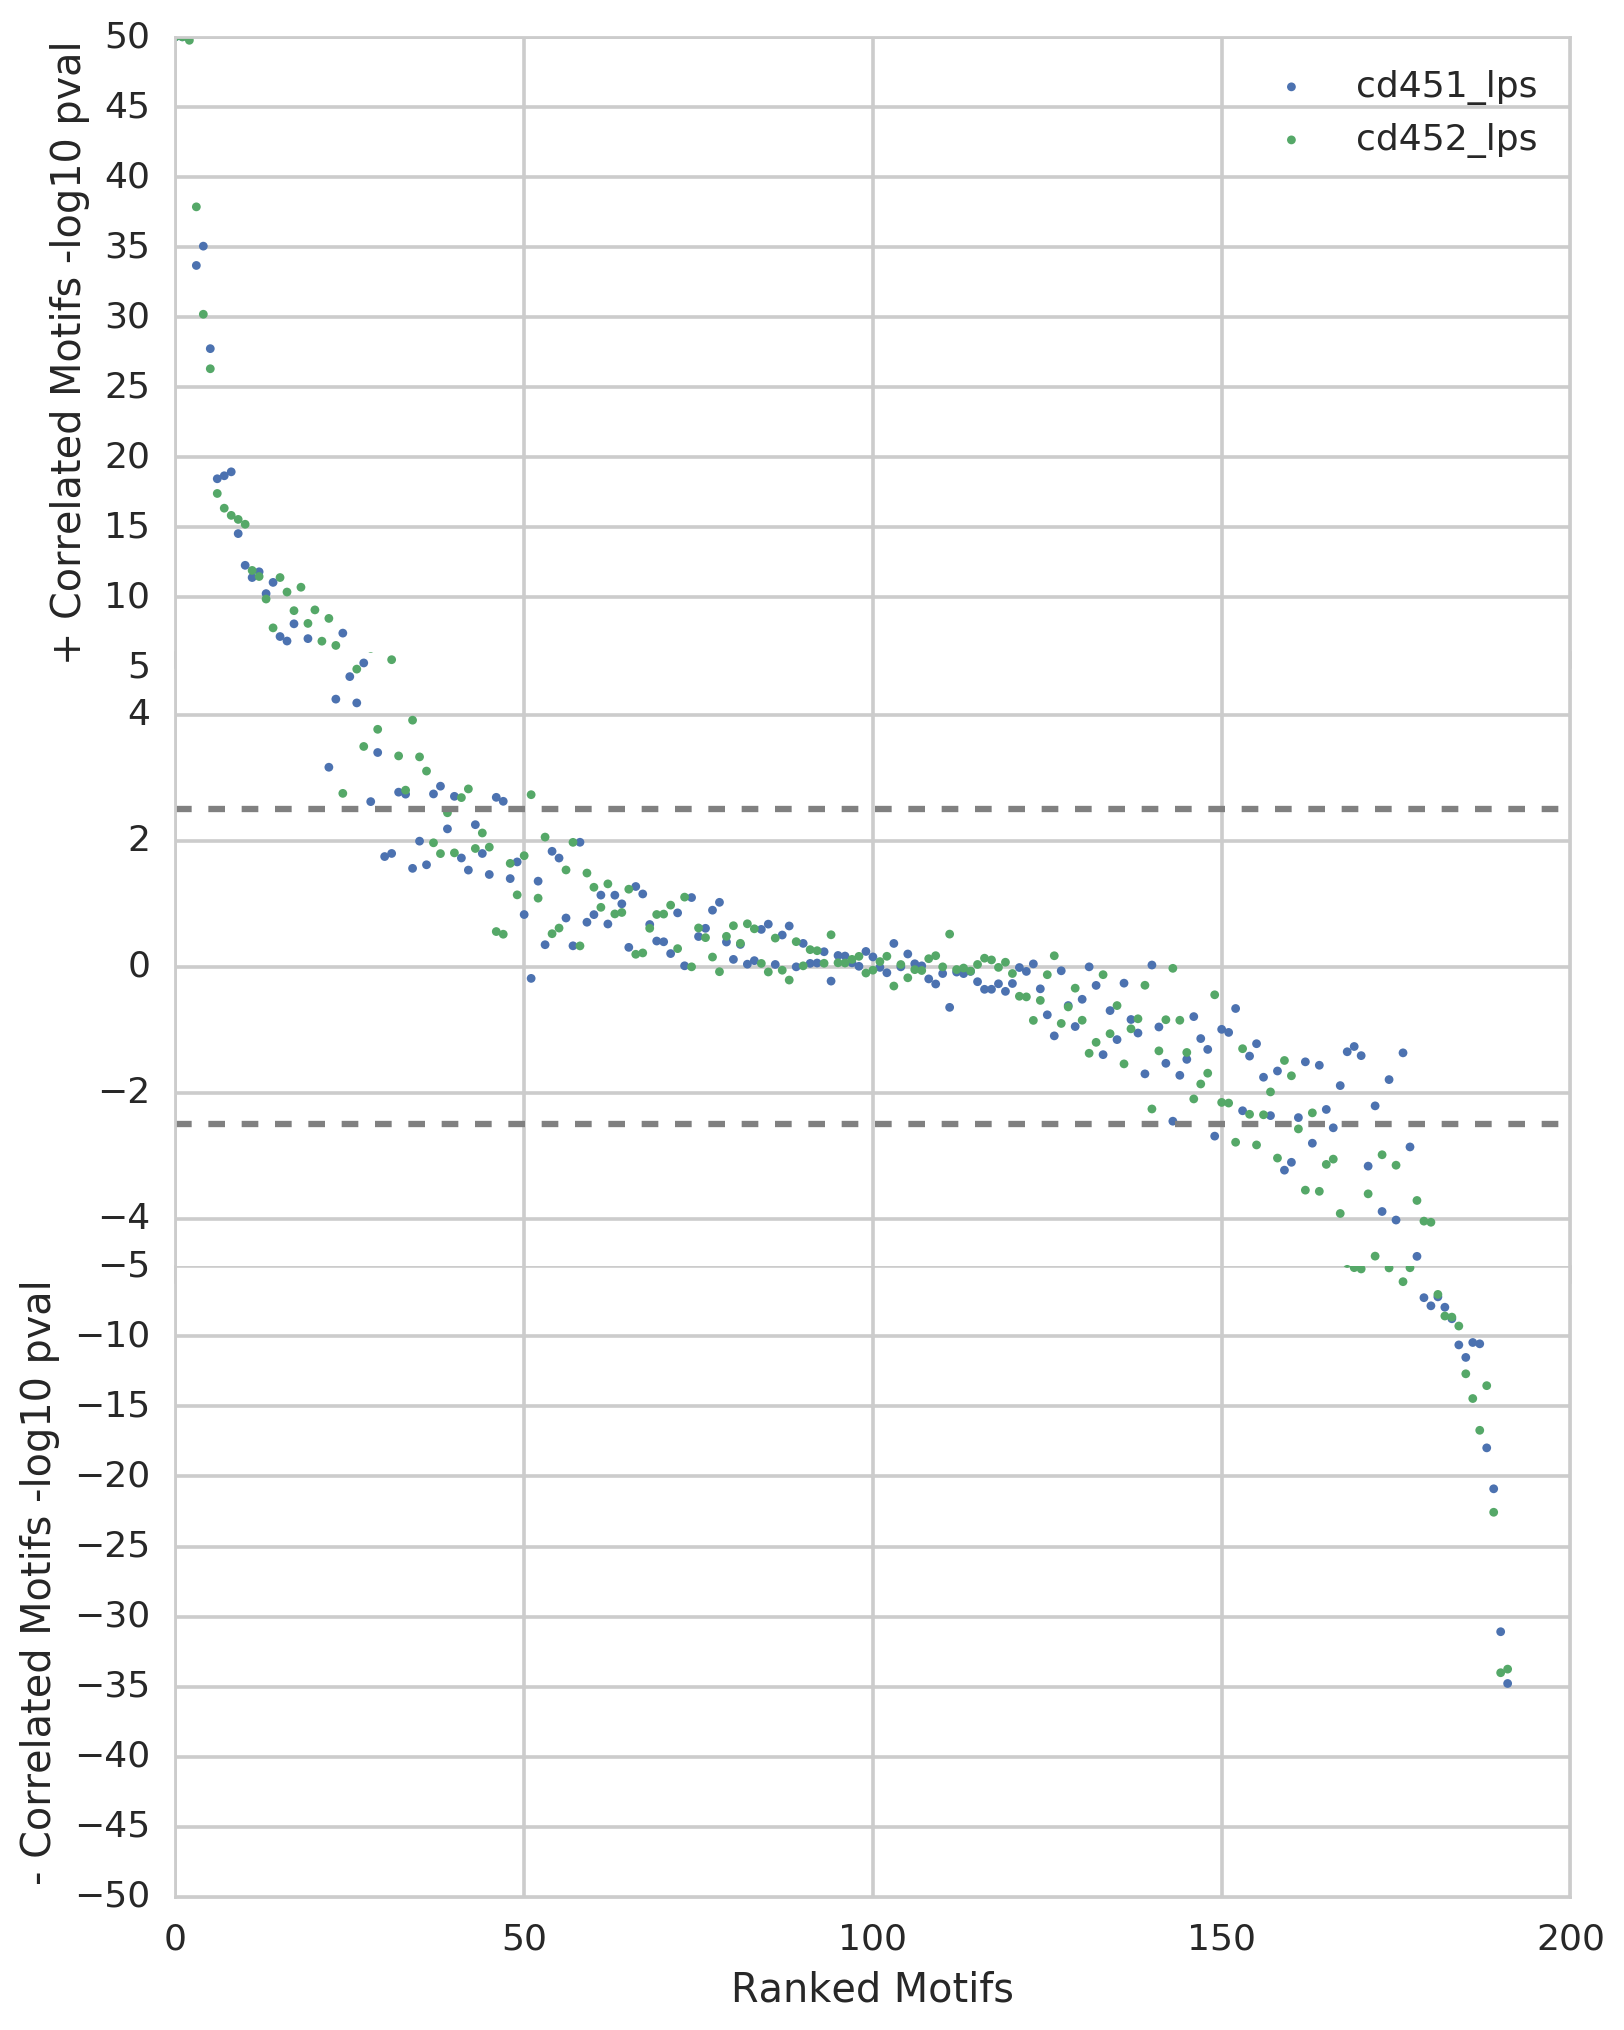

In [46]:
pseudocount = 1e-50 # set ceiling/floor for pvals
treatments = [x for x in mean_pval_frame.columns if 'lps' in x]
pval_threshold = 10**-2.5 # position of the dashed lines
treatment_orientedPvals_dict = {}
for treatment in treatments:
    pvals = mean_pval_promoters_frame[treatment]
    weights = mean_weights_promoters_frame[treatment]
    # calculate logpvals and assign direction according to weight
    oriented_pvals = [np.log10(x[0] +pseudocount) if x[1] < 0 else -np.log10(x[0]+pseudocount) for x in zip(pvals, weights)]
    treatment_orientedPvals_dict[treatment] = oriented_pvals

    # create data frame and sort according to mean
frame = pd.DataFrame(treatment_orientedPvals_dict, index = mean_pval_frame.index.values)
frame['mean'] = frame.mean(axis=1)
frame.sort_values('mean', ascending = False, inplace=True)
frame.drop('mean', axis=1, inplace=True)

colors = sns.color_palette()
counter = 0
with sns.axes_style('whitegrid'):
    # define subplots
    f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize = (9,12))

    for treatment in frame.columns.values:
        color = colors[counter]
        counter += 1
        # top panel
        # bottom panel
        ax1.scatter(list(range(frame.shape[0])), 
                    frame[treatment], 
                    label = treatment, 
                    c = color,
                    marker = 'o',
                    edgecolor = 'None',
                    s=10)
        
        # middle panel
        ax2.scatter(list(range(frame.shape[0])), 
                    frame[treatment], 
                    label = treatment, 
                    c = color,
                    marker = 'o',
                    edgecolor = 'None',
                    s=10)
        # bottom panel
        ax3.scatter(list(range(frame.shape[0])), 
                    frame[treatment], 
                    label = treatment, 
                    c = color,
                    marker = 'o',
                    edgecolor = 'None',
                    s=10)
        
    # scale panels
    plt.xlim(0,200)
    ax1.set_ylim(5, 50)
    ax2.set_ylim(-5, 5)  
    ax3.set_ylim(-50,-5)
    
    # hide the spines between axes
    ax1.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    
    ax2.spines['bottom'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    
    ax1.xaxis.tick_top()
    ax1.tick_params(labeltop='off')  # don't put tick labels at the top
    
    ax3.xaxis.tick_bottom()
    
    ax2.axhline(xmin=0,xmax=200,y=-np.log10(pval_threshold+ pseudocount), c='grey', linestyle='--')
    ax2.axhline(xmin=0,xmax=200,y=np.log10(pval_threshold+ pseudocount), c='grey', linestyle='--')
    
    ax1.set_ylabel('+ Correlated Motifs -log10 pval')
    ax3.set_ylabel('- Correlated Motifs -log10 pval')
    ax1.legend()
    
    plt.xlabel('Ranked Motifs')
    f.subplots_adjust(hspace=-0.025, wspace=-0.025)

### Enhancers

### read in weight values

In [126]:
sample_weights_dict = {}
for f in os.listdir('./tba_output_enhancers/'):
    if 'coefficients' in f and not 'annotated' in f:
        # read in coefficients
        os.system('/home/jtao/code/tba/model_training/annotate_results_with_genes.py ./tba_output_enhancers/'+ f + ' ./tba_output_enhancers/' + f.replace('.tsv','_annotated.tsv'))
        frame = pd.read_csv('./tba_output_enhancers/' + f.replace('.tsv','_annotated.tsv'), sep='\t', index_col=0)
        # take the mean across cross validation iterations
        mean_weights_enhancers = frame.iloc[:,1:].mean(axis=1).values
        sample = '_'.join(f.split('_')[0:2])
        sample_weights_dict[sample] = mean_weights_enhancers
# create data frame
mean_weights_enhancers_frame = pd.DataFrame(sample_weights_dict, 
                                            index = [frame.index.values, frame['genes'].values])
mean_weights_enhancers_frame = mean_weights_enhancers_frame[mean_weights_enhancers_frame.isnull().max(axis=1) ==False]

### read in significance values

In [125]:
sample_pval_dict = {}
for f in os.listdir('./tba_output_enhancers/'):
    if 'significance' in f and not 'annotated' in f:
        # read in cpvals
        os.system('/home/jtao/code/tba/model_training/annotate_results_with_genes.py ./tba_output_enhancers/'+ f + ' ./tba_output_enhancers/' + f.replace('.tsv','_annotated.tsv'))
        frame = pd.read_csv('./tba_output_enhancers/' + f.replace('.tsv','_annotated.tsv'), sep='\t', index_col=0)
        print(frame.shape)
        # take the mean across cross validation iterations
        mean_pval_enhancers = frame.iloc[:,1:].mean(axis=1).values
        sample = '_'.join(f.split('_')[0:2])
        sample_pval_dict[sample] = mean_pval_enhancers
# create data frame
mean_pval_enhancers_frame = pd.DataFrame(sample_pval_dict, 
                                         index = [frame.index.values, frame['genes'].values])
mean_pval_enhancers_frame = mean_pval_enhancers_frame[mean_pval_enhancers_frame.isnull().max(axis=1) ==False]

(431, 6)
(431, 6)
(431, 6)
(431, 6)


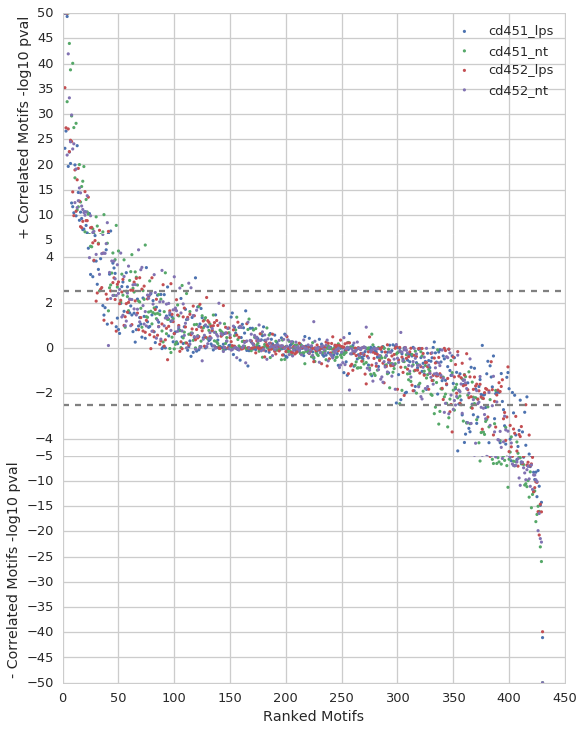

In [89]:
pseudocount = 1e-50 # set ceiling/floor for pvals
treatments = mean_pval_enhancers_frame.columns
pval_threshold = 10**-2.5 # position of the dashed lines
treatment_orientedPvals_dict = {}
for treatment in treatments:
    pvals = mean_pval_enhancers_frame[treatment]
    weights = mean_weights_enhancers_frame[treatment]
    # calculate logpvals and assign direction according to weight
    oriented_pvals = [np.log10(x[0] +pseudocount) if x[1] < 0 else -np.log10(x[0]+pseudocount) for x in zip(pvals, weights)]
    treatment_orientedPvals_dict[treatment] = oriented_pvals

    # create data frame and sort according to mean
frame = pd.DataFrame(treatment_orientedPvals_dict, index = mean_pval_enhancers_frame.index.values)
frame['mean'] = frame.mean(axis=1)
frame.sort_values('mean', ascending = False, inplace=True)
frame.drop('mean', axis=1, inplace=True)

colors = sns.color_palette()
counter = 0
with sns.axes_style('whitegrid'):
    # define subplots
    f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize = (9,12))

    for treatment in frame.columns.values:
        color = colors[counter]
        counter += 1
        # top panel
        # bottom panel
        ax1.scatter(list(range(frame.shape[0])), 
                    frame[treatment], 
                    label = treatment, 
                    c = color,
                    marker = 'o',
                    edgecolor = 'None',
                    s=10)
        
        # middle panel
        ax2.scatter(list(range(frame.shape[0])), 
                    frame[treatment], 
                    label = treatment, 
                    c = color,
                    marker = 'o',
                    edgecolor = 'None',
                    s=10)
        # bottom panel
        ax3.scatter(list(range(frame.shape[0])), 
                    frame[treatment], 
                    label = treatment, 
                    c = color,
                    marker = 'o',
                    edgecolor = 'None',
                    s=10)
        
    # scale panels
    plt.xlim(0,450)
    ax1.set_ylim(5, 50)
    ax2.set_ylim(-5, 5)  
    ax3.set_ylim(-50,-5)
    
    # hide the spines between axes
    ax1.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    
    ax2.spines['bottom'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    
    ax1.xaxis.tick_top()
    ax1.tick_params(labeltop='off')  # don't put tick labels at the top
    
    ax3.xaxis.tick_bottom()
    
    ax2.axhline(xmin=0,xmax=200,y=-np.log10(pval_threshold+ pseudocount), c='grey', linestyle='--')
    ax2.axhline(xmin=0,xmax=200,y=np.log10(pval_threshold+ pseudocount), c='grey', linestyle='--')
    
    ax1.set_ylabel('+ Correlated Motifs -log10 pval')
    ax3.set_ylabel('- Correlated Motifs -log10 pval')
    ax1.legend()
    
    plt.xlabel('Ranked Motifs')
    f.subplots_adjust(hspace=-0.025, wspace=-0.025)

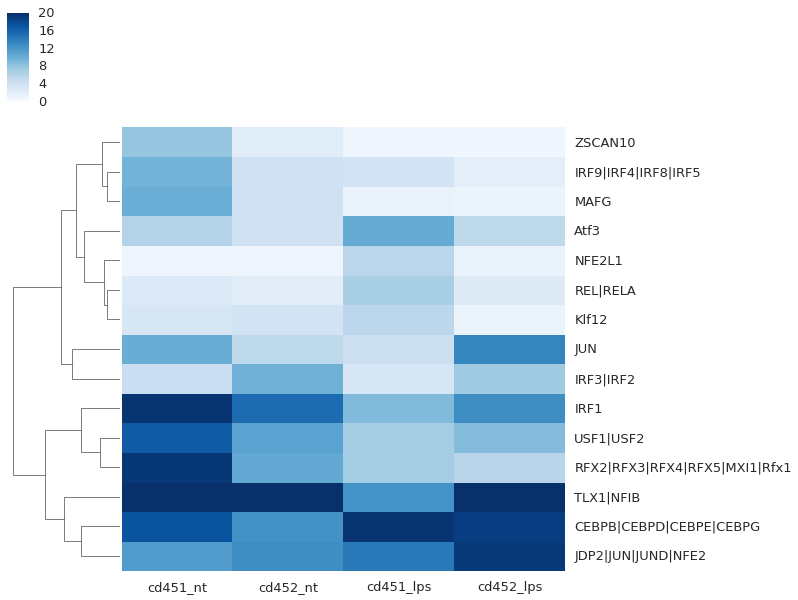

In [137]:
pseudocount = 1e-20 # pseudocount for calculating logfold change
treatments = mean_weights_enhancers_frame.columns
treatment_orientedPvals_dict = {}
for treatment in treatments:
    # retrieve pval and weights cooresponding to treatment
    pvals = mean_pval_enhancers_frame[treatment]
    weights = mean_weights_enhancers_frame[treatment]
    
    # calculate logpvals and assign direction according to weight
    oriented_pvals = [np.log10(x[0] +pseudocount) if x[1] < 0 else -np.log10(x[0]+pseudocount) for x in zip(pvals, weights)]
    treatment_orientedPvals_dict[treatment] = oriented_pvals
# crate data frame
frame = pd.DataFrame(treatment_orientedPvals_dict, index = mean_weights_enhancers_frame.index.values)
# sort by mean
frame['mean'] = frame.mean(axis=1)
frame.sort_values('mean', ascending = False, inplace=True)
frame.drop('mean', axis=1, inplace=True)

# plot only motifs with log pval > 2 for at least one condition (p<0.01) and positively correlated with open chromatin
frame = frame[frame.max(axis=1) >= 5]
# plot only motifs with absolute log likelihood ratio >=3
filtered_frame = frame[((frame['cd451_nt'] - frame['cd452_nt']).abs() >=4) |
                       ((frame['cd451_lps'] - frame['cd452_lps']).abs() >=4)]

# create heatmap
cg = sns.clustermap(filtered_frame[['cd451_nt', 'cd452_nt', 'cd451_lps', 'cd452_lps']],
     vmin=0,
     cmap='Blues',
     col_cluster = False
#      metric = 'correlation'
                   )
plt.setp(cg.ax_heatmap.get_yticklabels(), rotation=0);



Atf3
BATF::JUN
BCL11A
E2F1
Fos-related_factors_1_merged
GCM_factors_1_merged
IRF1
IRF7
IRF_1_merged
Jun-related_factors_2_merged
Klf12
MAFG::NFE2L1
MZF1
NF-kappaB-related_factors_1_merged
NK-related_factors_1_merged
POU_domain_factors_4_merged
Rel_1_merged
TBX2-related_factors_1_merged
Tal-related_factors_2_merged
Thyroid_hormone_receptor-related_factors_NR1_2_merged
YY2
ZNF32
ZNF691
ZNF784


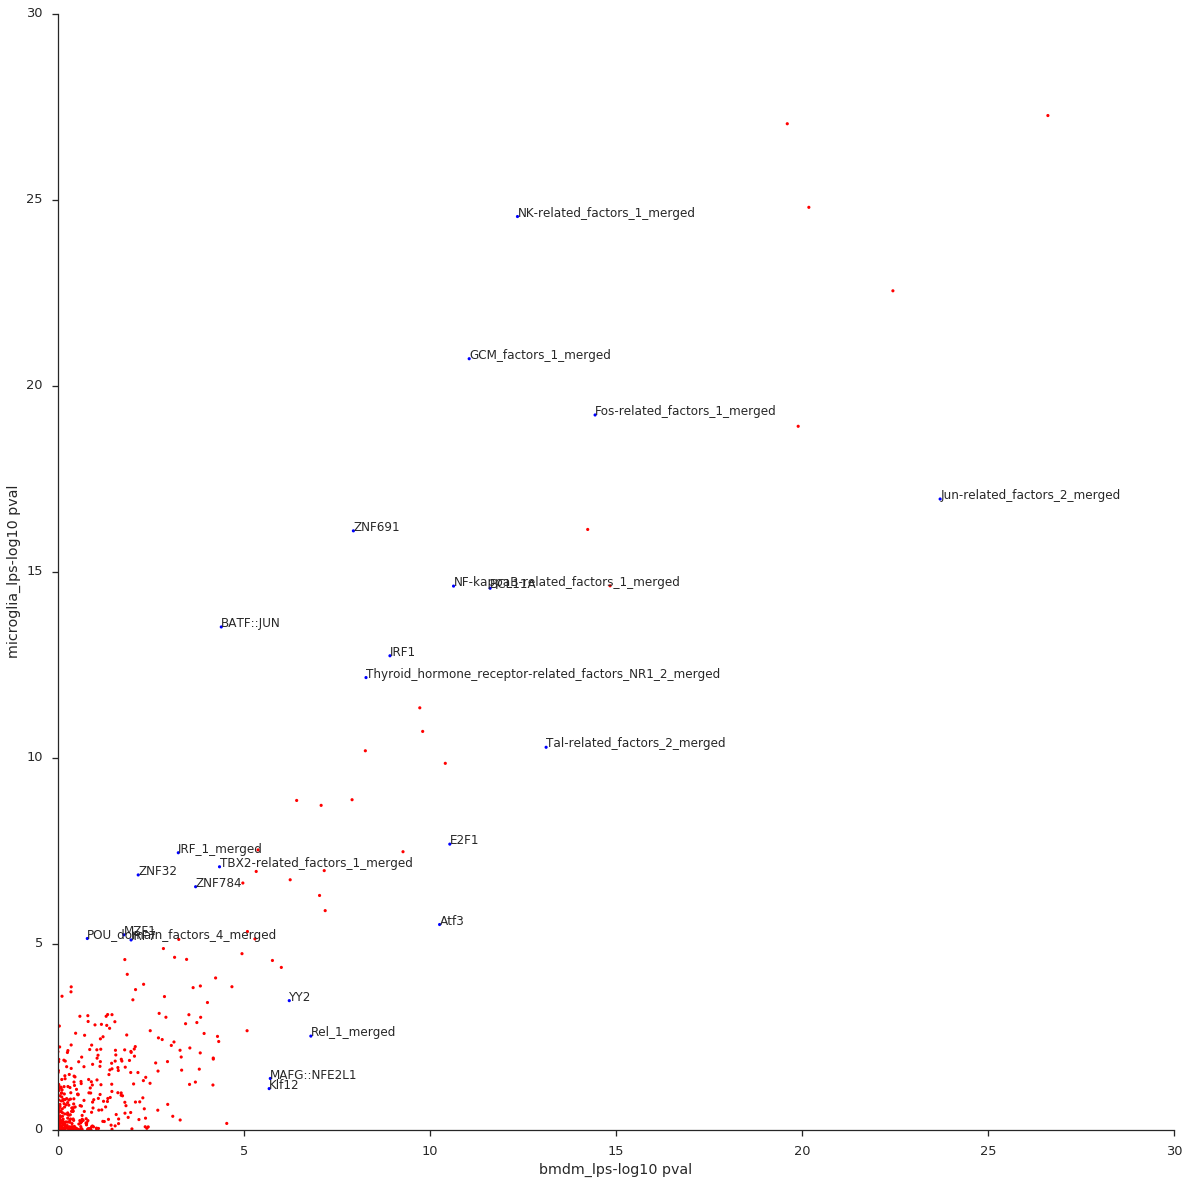

AIRE
BATF::JUN
C2H2_ZF_3_merged
CEBP-related_1_merged
CEBP-related_2_merged
EPAS1
Factors_with_multiple_dispersed_zinc_fingers_2_merged
GATA_1_merged
HOXA7
HSF_1_merged
Homeodomain_11_merged
IKZF1_var2
IRF1
IRF4_var3
IRF_1_merged
Interferon-regulatory_factors_1_merged
MAFA
MAFG
More_than_3_adjacent_zinc_finger_factors_1_merged
More_than_3_adjacent_zinc_finger_factors_4_merged
NF-kappaB-related_factors_1_merged
Nkx2-5
Nkx2-5(var.2)
RFX-related_factors_1_merged
TEF-1-related_factors_1_merged
Tal-related_factors_2_merged
Three-zinc_finger_Kruppel-related_factors_3_merged
Thyroid_hormone_receptor-related_factors_NR1_2_merged
ZNF32
ZNF589
ZNF691
ZSCAN10
bHLH-ZIP_factors_5_merged


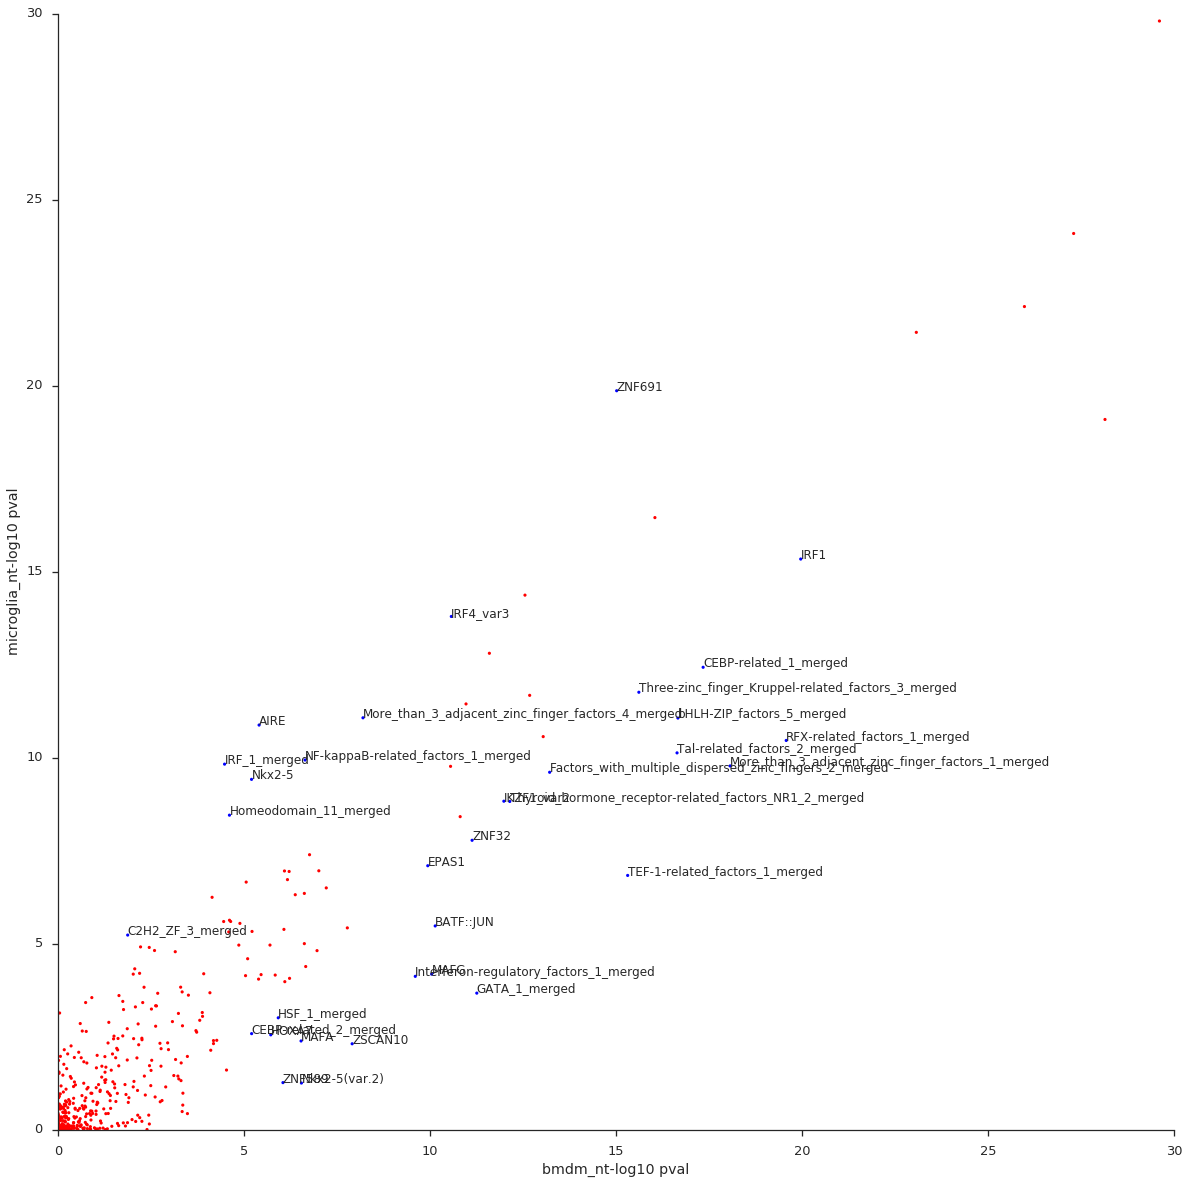

In [164]:
treatments = mean_pval_enhancers_frame.columns.values
genes = [x[0] for x in mean_pval_enhancers_frame.index.values]
for i in range(len(treatments)-1):
    for j in range(i+1,len(treatments)):
        with sns.axes_style('ticks'):
            plt.figure(figsize=(20,20))
            if not treatments[i].split('_')[1] == treatments[j].split('_')[1]:
                continue
            colors = []
            xvals = mean_pval_enhancers_frame[treatments[i]]
            yvals = mean_pval_enhancers_frame[treatments[j]]
            
            xvals = -np.log10(xvals+1e-50)
            yvals = -np.log10(yvals+1e-50)
            for x, y in list(zip(xvals,yvals)):
                pseudo_x = -np.log10(10**-x+1e-20)
                pseudo_y = -np.log10(10**-y+1e-20)
                if abs(pseudo_x-pseudo_y)>=2.5 and max(abs(x), abs(y))>=5:
                    colors.append('blue')
                else:
                    colors.append('red')
            plt.scatter(xvals,
                        yvals,
                        edgecolor='None',
                        s=10,
                        c=colors
                       )
            for x, y, g in list(zip(xvals,yvals,genes)):
                pseudo_x = -np.log10(10**-x+1e-20)
                pseudo_y = -np.log10(10**-y+1e-20)
                if abs(pseudo_x-pseudo_y)>=2.5 and max(abs(x), abs(y))>=5:
                    print(g)
                    plt.annotate(xy=(x,y), s=g, size=12)

            plt.xlabel(treatments[i].replace('cd451', 'bmdm').replace('cd452', 'microglia') + '-log10 pval')
            plt.ylabel(treatments[j].replace('cd451', 'bmdm').replace('cd452', 'microglia') + '-log10 pval')
            sns.despine()
            plt.xlim(0,30)
            plt.ylim(0,30)
            plt.gca().set_aspect(1)
            plt.savefig('./enhancer_pval_scatter_'+treatments[i] + '_' + treatments[j] + '.pdf', dpi=220, bbox_inches='tight')
            plt.show()

## Add Gene and TSS Distance to Motif Scores

In [61]:
coordinates = summary_frame['chr'].astype(str) + ':' + \
        (summary_frame['start']).astype(str) + '-' + summary_frame['end'].astype(str)

ids = summary_frame['ID'].values

coord_id_dict = dict(zip(coordinates, ids))

In [73]:
for f in os.listdir('./tba_output_enhancers/'):
    if 'enhancer' in f and 'motif_scores' in f:
        print(f)
        frame = pd.read_csv('./tba_output_enhancers/'+f, sep='\t', index_col=0)
        frame['Gene Name'] = annotation_genes[[coord_id_dict[x] for x in frame.index.values]].values
        frame['Distance to TSS Name'] = annotation_gene_distances[[coord_id_dict[x] for x in frame.index.values]].values
        frame.to_csv('./to_share/' + f.replace('.tsv', '_withGenes.tsv'), sep='\t')

cd452_lps_enhancer_motif_scores.tsv
cd451_nt_enhancer_motif_scores.tsv
cd452_nt_enhancer_motif_scores.tsv
cd451_lps_enhancer_motif_scores.tsv


## Focusing on KLF12

In [8]:
microglia_lps_motif_score_frame = pd.read_csv('./tba_output_enhancers/cd452_lps_enhancer_motif_scores.tsv', 
                                              sep='\t', index_col=0)
microglia_nt_motif_score_frame = pd.read_csv('./tba_output_enhancers/cd452_nt_enhancer_motif_scores.tsv', 
                                              sep='\t', index_col=0)

bmdm_lps_motif_score_frame = pd.read_csv('./tba_output_enhancers/cd451_lps_enhancer_motif_scores.tsv', 
                                              sep='\t', index_col=0)
bmdm_nt_motif_score_frame = pd.read_csv('./tba_output_enhancers/cd451_nt_enhancer_motif_scores.tsv', 
                                              sep='\t', index_col=0)

In [10]:
background_lps_motif_score_frame = pd.read_csv('./tba_output_enhancers/cd451_lps_background_motif_scores.tsv',
                                              sep='\t', index_col=0)
background_nt_motif_score_frame = pd.read_csv('./tba_output_enhancers/cd451_nt_background_motif_scores.tsv',
                                             sep='\t', index_col=0)

In [19]:
sns.set_context('talk')

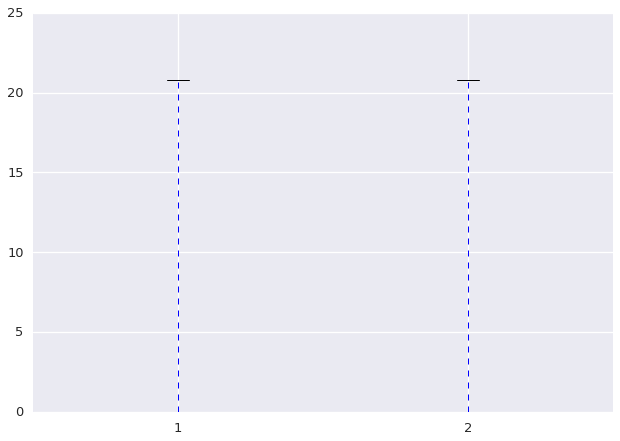

In [20]:
plt.boxplot([microglia_lps_motif_score_frame['Klf12'], bmdm_lps_motif_score_frame['Klf12']]);

(0, 0.2)

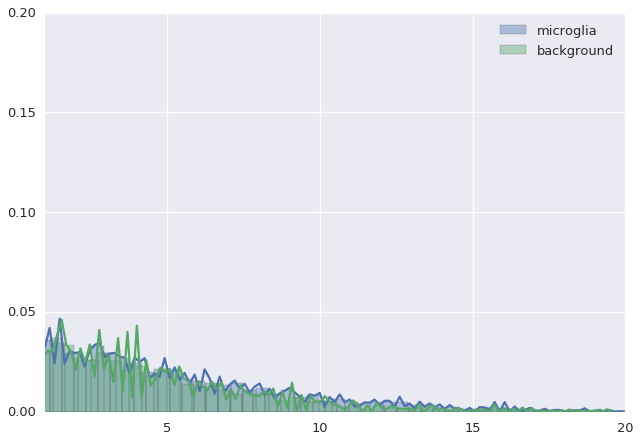

In [25]:
sns.distplot([microglia_lps_motif_score_frame['Klf12']], label = 'microglia')
sns.distplot([background_lps_motif_score_frame['Klf12']], label = 'background')
plt.legend()
plt.xlim(1,20)
plt.ylim(0,0.2)

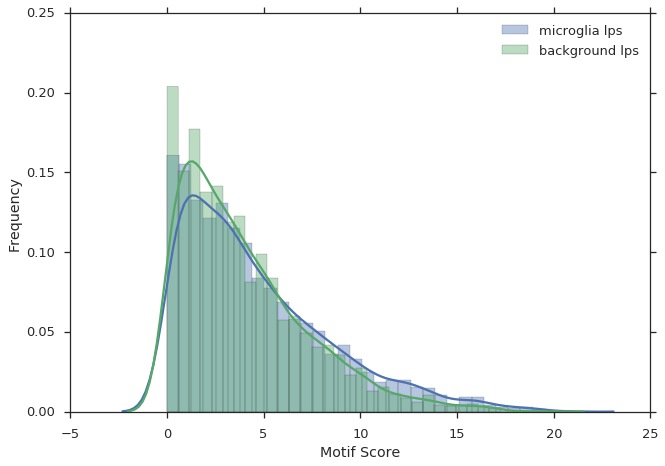

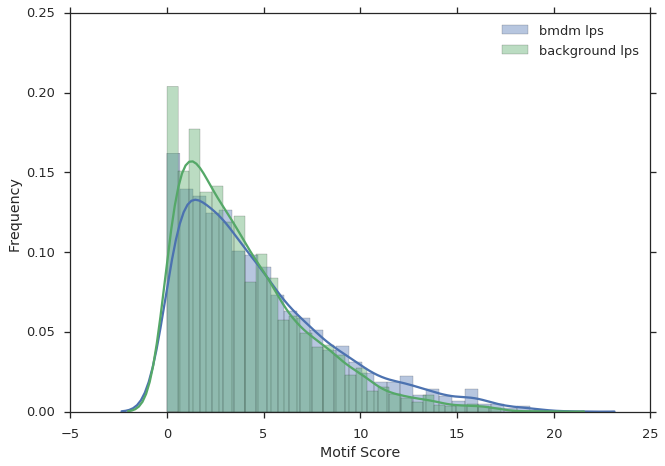

In [33]:
with sns.axes_style('ticks'):
    sns.distplot([x for x in microglia_lps_motif_score_frame['Klf12'] if x>0], label = 'microglia lps')
    sns.distplot([x for x in background_lps_motif_score_frame['Klf12'] if x>0], label = 'background lps')
    plt.xlabel('Motif Score')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()
    
    sns.distplot([x for x in bmdm_lps_motif_score_frame['Klf12'] if x>0], label = 'bmdm lps')
    sns.distplot([x for x in background_lps_motif_score_frame['Klf12'] if x>0], label = 'background lps')
    plt.xlabel('Motif Score')
    plt.ylabel('Frequency')
    plt.legend()
    

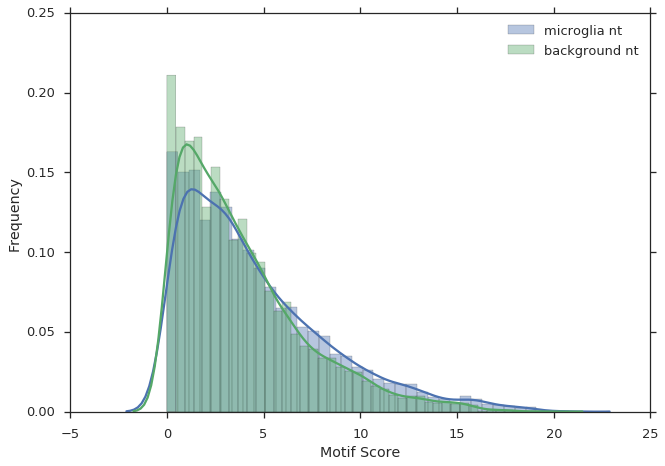

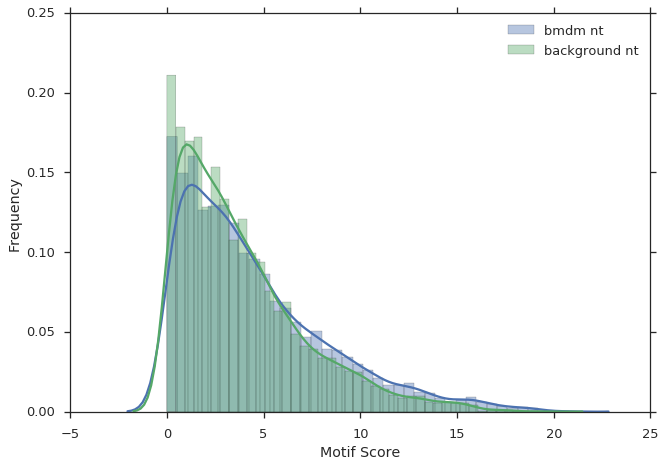

In [32]:
with sns.axes_style('ticks'):
    sns.distplot([x for x in microglia_nt_motif_score_frame['Klf12'] if x>0], label = 'microglia nt')
    sns.distplot([x for x in background_nt_motif_score_frame['Klf12'] if x>0], label = 'background nt')
    plt.xlabel('Motif Score')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()
    
    sns.distplot([x for x in bmdm_nt_motif_score_frame['Klf12'] if x>0], label = 'bmdm nt')
    sns.distplot([x for x in background_nt_motif_score_frame['Klf12'] if x>0], label = 'background nt')
    plt.xlabel('Motif Score')
    plt.ylabel('Frequency')
    plt.legend()
    

In [37]:
%%bash
if [ ! -d ./denovo_motif_analysis ]; then mkdir ./denovo_motif_analysis; else rm -r ./denovo_motif_analysis/*/; fi
for bed_file in ./bed_files_enhancers/*bed;
    do 
    out_dir=${bed_file/bed_files_enhancers/denovo_motif_analysis}
    out_dir=${out_dir/.bed};
    echo findMotifsGenome.pl $bed_file mm10 $out_dir -p 24;
done

findMotifsGenome.pl ./bed_files_enhancers/cd451_lps_enhancer.bed mm10 ./denovo_motif_analysis/cd451_lps_enhancer -p 24
findMotifsGenome.pl ./bed_files_enhancers/cd451_nt_enhancer.bed mm10 ./denovo_motif_analysis/cd451_nt_enhancer -p 24
findMotifsGenome.pl ./bed_files_enhancers/cd452_lps_enhancer.bed mm10 ./denovo_motif_analysis/cd452_lps_enhancer -p 24
findMotifsGenome.pl ./bed_files_enhancers/cd452_nt_enhancer.bed mm10 ./denovo_motif_analysis/cd452_nt_enhancer -p 24


rm: cannot remove ‘./denovo_motif_analysis/*/’: No such file or directory


## Peak Calling for Lavin Paper

In [51]:
# %%capture 
# suppress output - this can be saved to a variable (like a log file)

### call peaks ###
# iterate through each individual file
peakDirectory = workingDirectory + '/' + 'lavinAtac_peak_files'

if not os.path.exists(peakDirectory):
    os.makedirs(peakDirectory)

# make peak files with simplified names
# filteredSamples = list(filtered_mappingStats_frame['sampleName'].values)
scriptFile1 = open('./peakCalling_homer_lavin.sh', 'w')
condition_count_dict = {}
atacTagDirPath = './tag_directories_lavinAtac/'
for tagDir in os.listdir(atacTagDirPath):
    # call peaks only for experiments that passed thresholding
    print(tagDir)
    tokens = tagDir.split('_')
    cellType = tokens[1]
    if cellType in condition_count_dict:
        condition_count_dict[cellType] += 1
    else:
        condition_count_dict[cellType] = 1
    count = condition_count_dict[cellType]
    peakFileName1 = cellType + '_nt_'+ str(count)  + "_peaks.tsv"

    scriptFile1.write('findPeaks ' + atacTagDirPath + '/' + tagDir 
                     + ' -L 0 -C 0 -fdr 0.9' 
                     + ' -style factor -size 150  > ' + 
                     peakDirectory + '/' + peakFileName1 + ' &\n')

scriptFile1.close()


C57Bl6_SmallIntestineMacrophages_ATAC_Vehicle_SRR1653767
C57Bl6_Monocytes_ATAC_Vehicle_SRR1653773
C57Bl6_SmallIntestineMacrophages_ATAC_Vehicle_SRR1653768
C57Bl6_Neutrophils_ATAC_Vehicle_SRR1653772
C57Bl6_PeritonealCavityMacrophages_ATAC_Vehicle_SRR1653770
C57Bl6_SpleenRedPulpMacrophages_ATAC_Vehicle_SRR1653780
C57Bl6_SpleenRedPulpMacrophages_ATAC_Vehicle_SRR1653781
C57Bl6_Neutrophils_ATAC_Vehicle_SRR1653771
C57Bl6_LungMacrophages_ATAC_Vehicle_SRR1653766
C57Bl6_LargeIntestineMacrophages_ATAC_Vehicle_SRR1653777
C57Bl6_LargeIntestineMacrophages_ATAC_Vehicle_SRR1653776
C57Bl6_LungMacrophages_ATAC_Vehicle_SRR1653765
C57Bl6_Monocytes_ATAC_Vehicle_SRR1653774
C57Bl6_PeritonealCavityMacrophages_ATAC_Vehicle_SRR1653769
C57Bl6_SpleenRedPulpMacrophages_ATAC_Vehicle_SRR1653764


In [55]:
idrDirectory = './lavinAtac_idr/'
scriptFile = open('./run_idr_lavin.sh', 'w')
!rm ./lavinAtac_idr/*

! if [ ! -d $idrDirectory ]; then mkdir $idrDirectory; fi

# homer peaks
counter = 0
for cellType in condition_count_dict.keys():
    counter+=1
    print(cellType)
    samples = [x for x in os.listdir('./lavinAtac_peak_files/') if cellType in x]
    peakFile1 = peakDirectory + '/' + samples[0]
    peakFile2 = peakDirectory + '/' + samples[1]
    print(peakFile1, peakFile2)
    # determine IDR threshold based on number of peaks
    # https://sites.google.com/site/anshulkundaje/projects/idr
    with open(peakFile1) as f:
        data = f.readlines()
    len_1 = len(data)
    with open(peakFile2) as f:
        data = f.readlines()
    len_2 = len(data)
    max_length = max(len_1, len_2)
    print(peakFile1, peakFile2, max_length)
    commandString = ' '.join(['python /home/jtao/code/seq_merge_pipe/run_idr_homerPeaks.py',
                             peakFile1,
                             peakFile2,
                             idrDirectory])
    if max_length > 150000 + 35: # 35 is the number of header rows in peak files
        commandString += " -threshold 0.02"
    else: 
        commandString += " -threshold 0.05"            
    if not counter % 12 == 0:
        commandString += ' &'
    scriptFile.write(commandString + '\n')
scriptFile.close()

rm: cannot remove ‘./lavinAtac_idr/*’: No such file or directory
Neutrophils
/home/jtao/analysis/jung_microglia_analysis//lavinAtac_peak_files/Neutrophils_nt_1_peaks.tsv /home/jtao/analysis/jung_microglia_analysis//lavinAtac_peak_files/Neutrophils_nt_2_peaks.tsv
/home/jtao/analysis/jung_microglia_analysis//lavinAtac_peak_files/Neutrophils_nt_1_peaks.tsv /home/jtao/analysis/jung_microglia_analysis//lavinAtac_peak_files/Neutrophils_nt_2_peaks.tsv 73176
LargeIntestineMacrophages
/home/jtao/analysis/jung_microglia_analysis//lavinAtac_peak_files/LargeIntestineMacrophages_nt_2_peaks.tsv /home/jtao/analysis/jung_microglia_analysis//lavinAtac_peak_files/LargeIntestineMacrophages_nt_1_peaks.tsv
/home/jtao/analysis/jung_microglia_analysis//lavinAtac_peak_files/LargeIntestineMacrophages_nt_2_peaks.tsv /home/jtao/analysis/jung_microglia_analysis//lavinAtac_peak_files/LargeIntestineMacrophages_nt_1_peaks.tsv 146201
SmallIntestineMacrophages
/home/jtao/analysis/jung_microglia_analysis//lavinAtac_pea

In [19]:
%%bash
chmod a+x ./scratch/*
bash ./run_idr_lavin.sh

Performing IDR analysis on the following samples: /home/jtao/analysis/jung_microglia_analysis//atac_peak_files/cd452_lps_1_1_peaks.tsv, /home/jtao/analysis/jung_microglia_analysis//atac_peak_files/cd452_lps_2_1_peaks.tsv
Output files will be written to: ./atac_idr/
Using the following IDR threshold: 0.05
Peaks will be ranked using: findPeaks Score
Other available scoreColumns: ['Normalized Tag Count' 'focus ratio' 'findPeaks Score' 'Score']
idr --samples ./atac_idr//cd452_lps_1_1_peaks.narrowPeak ./atac_idr//cd452_lps_2_1_peaks.narrowPeak --output-file ./atac_idr//cd452_lps_1_1_peaks_cd452_lps_2_1_peaks_idr.out --plot --idr-threshold 0.05 &
Performing IDR analysis on the following samples: /home/jtao/analysis/jung_microglia_analysis//atac_peak_files/cd451_lps_2_1_peaks.tsv, /home/jtao/analysis/jung_microglia_analysis//atac_peak_files/cd451_lps_3_1_peaks.tsv
Output files will be written to: ./atac_idr/
Using the following IDR threshold: 0.05
Peaks will be ranked using: findPeaks Score
O

chmod: cannot access ‘./scratch/*’: No such file or directory
Initial parameter values: [0.10 1.00 0.20 0.50]
Initial parameter values: [0.10 1.00 0.20 0.50]
Initial parameter values: [0.10 1.00 0.20 0.50]
Initial parameter values: [0.10 1.00 0.20 0.50]
Initial parameter values: [0.10 1.00 0.20 0.50]
Initial parameter values: [0.10 1.00 0.20 0.50]
Initial parameter values: [0.10 1.00 0.20 0.50]
Initial parameter values: [0.10 1.00 0.20 0.50]
Initial parameter values: [0.10 1.00 0.20 0.50]
Initial parameter values: [0.10 1.00 0.20 0.50]
Initial parameter values: [0.10 1.00 0.20 0.50]
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [2.03 1.46 0.92 0.64]
Final parameter values: [2.05 1.45 0.92 0.64]
Final parameter values: [2.16 1.49 0.93 0.66]
Number of reported peaks - 44906/84459 (53.2%)

Number of peaks passing IDR cutoff of 0.05 - 44906/84459 (53.2%)

Number of reported peaks - 45502/84413 (53.9%)

Number of peaks passing IDR cutoff of 0.05 - 45502/84413 (53.9

In [56]:
# pick the IDR results that have the most peaks
idrDirectory = './lavinAtac_idr/'
treatment_bestIDR_dict = {}
treatment_peakNumber_dict = {}
for p in os.listdir(idrDirectory):
    if 'idr.tsv' in p:
        with open (idrDirectory + '/' + p) as f:
            data = f.readlines()
        numPeaks = len(data) - 1
        treatment = '_'.join(p.split('_')[:2])
        if treatment in treatment_peakNumber_dict:
            if treatment_peakNumber_dict[treatment] < numPeaks:
                treatment_peakNumber_dict[treatment] = numPeaks
                treatment_bestIDR_dict[treatment] = p
        else:
            treatment_peakNumber_dict[treatment] = numPeaks
            treatment_bestIDR_dict[treatment] = p

In [60]:
if not os.path.isdir('./lavinAtac_idr_peaks/'):
    os.mkdir('./lavinAtac_idr_peaks/')
else:
    for f in os.listdir('./lavinAtac_idr_peaks/'):
        os.remove('./lavinAtac_idr_peaks/' + f)
for key in sorted(treatment_bestIDR_dict.keys()):
    p = treatment_bestIDR_dict[key]
    tokens = p.split('_')
    cellType = tokens[0]
    treatment = tokens[1]

    print('\t'.join([cellType, treatment, str(treatment_bestIDR_dict[key])]))

    if treatment_bestIDR_dict[key]:
        outpath = './lavinAtac_idr_peaks/' + '_'.join([cellType, treatment]) + '_peaks.tsv'
        !cp $idrDirectory/$p $outpath





LargeIntestineMacrophages	nt	LargeIntestineMacrophages_nt_2_peaks_LargeIntestineMacrophages_nt_1_peaks_idr.tsv
LungMacrophages	nt	LungMacrophages_nt_2_peaks_LungMacrophages_nt_1_peaks_idr.tsv
Monocytes	nt	Monocytes_nt_1_peaks_Monocytes_nt_2_peaks_idr.tsv
Neutrophils	nt	Neutrophils_nt_1_peaks_Neutrophils_nt_2_peaks_idr.tsv
PeritonealCavityMacrophages	nt	PeritonealCavityMacrophages_nt_2_peaks_PeritonealCavityMacrophages_nt_1_peaks_idr.tsv
SmallIntestineMacrophages	nt	SmallIntestineMacrophages_nt_2_peaks_SmallIntestineMacrophages_nt_1_peaks_idr.tsv
SpleenRedPulpMacrophages	nt	SpleenRedPulpMacrophages_nt_2_peaks_SpleenRedPulpMacrophages_nt_3_peaks_idr.tsv


### Get enhancer peaks

In [68]:
%%bash
for peakFile in ./lavinAtac_idr_peaks/*
do 
annotatedFile=${peakFile/_peaks.tsv/_annotatedPeaks.tsv};
annotatePeaks.pl $peakFile mm10 >  $annotatedFile
done


	Peak file = ./lavinAtac_idr_peaks/LargeIntestineMacrophages_nt_annotatedPeaks.tsv
	Genome = mm10
	Organism = mouse
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 0
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 0
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Only 0 peaks found! If many more expected, maybe the file format is for Macs only
	Try running the command: changeNewLine.pl "0.418295546275662.clean.pos"

	Reading Positions...
	-----------------------
	Finding Closest TSS...
	Annotating:
		Annotation	Number of peaks	Total size (bp)	Log2 Enrichment
	NOTE: If this part takes more than 2 minutes, there is a good chance
		your machine ran out of memory: consider hitting ctrl+C and rerunning
		the command with "-noann"
	To capture annotation stats i

In [77]:
%%bash
for annotated_file in ./lavinAtac_idr_peaks/*annotated*; 
do 

enhancer_file=${annotated_file/annotatedPeaks/enhancerPeaks}
echo $annotated_file $enhancer_file
echo "#"$(head -n 1 $annotated_file) > $enhancer_file
grep -i intergenic $annotated_file >> $enhancer_file
done

./lavinAtac_idr_peaks/LargeIntestineMacrophages_nt_annotatedPeaks.tsv ./lavinAtac_idr_peaks/LargeIntestineMacrophages_nt_enhancerPeaks.tsv
./lavinAtac_idr_peaks/LungMacrophages_nt_annotatedPeaks.tsv ./lavinAtac_idr_peaks/LungMacrophages_nt_enhancerPeaks.tsv
./lavinAtac_idr_peaks/Monocytes_nt_annotatedPeaks.tsv ./lavinAtac_idr_peaks/Monocytes_nt_enhancerPeaks.tsv
./lavinAtac_idr_peaks/Neutrophils_nt_annotatedPeaks.tsv ./lavinAtac_idr_peaks/Neutrophils_nt_enhancerPeaks.tsv
./lavinAtac_idr_peaks/PeritonealCavityMacrophages_nt_annotatedPeaks.tsv ./lavinAtac_idr_peaks/PeritonealCavityMacrophages_nt_enhancerPeaks.tsv
./lavinAtac_idr_peaks/SmallIntestineMacrophages_nt_annotatedPeaks.tsv ./lavinAtac_idr_peaks/SmallIntestineMacrophages_nt_enhancerPeaks.tsv
./lavinAtac_idr_peaks/SpleenRedPulpMacrophages_nt_annotatedPeaks.tsv ./lavinAtac_idr_peaks/SpleenRedPulpMacrophages_nt_enhancerPeaks.tsv


In [82]:
%%bash
# delete the existing script file
rm ./run_tba_enhancersLavin.sh
# create a script file
touch ./run_tba_enhancersLavin.sh

# if directories don't exist, create them
if [ ! -d ./tba_output_lavinEnhancers/ ]; then mkdir ./tba_output_lavinEnhancers; fi

# for each peak file create several commands
for peak_file in ./lavinAtac_idr_peaks/*enhancer*tsv;
do 
# generate peak sequence fasta file name
bed_file=${peak_file/tsv/bed}

echo "pos2bed.pl $peak_file > $bed_file" >> ./run_tba_enhancersLavin.sh
seq_file=${bed_file/enhancerPeaks.bed/enhancer.fasta};
seq_file=${seq_file/bed_files_enhancers/tba_output_lavinEnhancers};

# execute command to extract sequences
echo "/home/jtao/code/tba/model_training/extract_sequences.py $bed_file mm10 $seq_file">> ./run_tba_enhancersLavin.sh

# generate background coordinates
echo "/home/jtao/code/tba/model_training/generate_background_coordinates.py $bed_file mm10 ./tba_output_lavinEnhancers/">> ./run_tba_enhancersLavin.sh

# rename background file
bg_seq_file=${seq_file/enhancer.fasta/background.fasta};
echo "mv ./tba_output_lavinEnhancers/background.fasta $bg_seq_file">> ./run_tba_enhancersLavin.sh
echo "/home/jtao/code/tba/model_training/create_features.py -num_procs 40 $seq_file $bg_seq_file ./tba_output_lavinEnhancers /home/jtao/code/tba/default_motifs/*">> ./run_tba_enhancersLavin.sh

# calculate motif scores for peaks and background
combined_features=${seq_file/.fasta/_combined_features.tsv}
combined_features=${combined_features/lavinAtac_idr_peaks/tba_output_lavinEnhancers}
labels=${combined_features/combined_features.tsv/labels.txt}
echo "/home/jtao/code/tba/model_training/train_classifier.py $combined_features $labels ./tba_output_lavinEnhancers/">> ./run_tba_enhancersLavin.sh
coeff_path=${combined_features/combined_features.tsv/coefficients.tsv}
performance_path=${combined_features/combined_features.tsv/performance.tsv}
echo "mv ./tba_output_lavinEnhancers/coefficients.tsv $coeff_path">> ./run_tba_enhancersLavin.sh
echo "mv ./tba_output_lavinEnhancers/performance.tsv $performance_path">> ./run_tba_enhancersLavin.sh

# perform insilico mutagenesis
echo "/home/jtao/code/tba/model_training/calc_feature_significance.py -num_procs 12 -num_iterations 5 $combined_features $labels ./tba_output_lavinEnhancers/">> ./run_tba_enhancersLavin.sh
significance_path=${combined_features/combined_features.tsv/significance.tsv}
echo mv ./tba_output_lavinEnhancers/significance.tsv $significance_path>> ./run_tba_enhancersLavin.sh

done

### read in weight values

In [84]:
sample_weights_dict = {}
for f in os.listdir('./tba_output_lavinEnhancers/'):
    if 'coefficients' in f and not 'gene' in f:
        # read in coefficients
        frame = pd.read_csv('./tba_output_lavinEnhancers/' + f, sep='\t', index_col=0)
        # take the mean across cross validation iterations
        mean_weights = frame.mean(axis=1)
        sample = '_'.join(f.split('_')[0:2])
        sample_weights_dict[sample] = mean_weights
# create data frame
mean_weights_lavin_frame = pd.DataFrame(sample_weights_dict, index = sample_weights_dict[list(sample_weights_dict.keys())[0]].index.values)
mean_weights_lavin_frame = mean_weights_lavin_frame[mean_weights_lavin_frame.isnull().max(axis=1) ==False]

### read in significance values

In [85]:
sample_pval_dict = {}
for f in os.listdir('./tba_output_lavinEnhancers/'):
    if 'significance' in f and not 'gene' in f:
        # read in signifance values using pandas
        frame = pd.read_csv('./tba_output_lavinEnhancers/' + f, sep='\t', index_col=0)
        # take the mean across cross validation iterations
        mean_pval = frame.mean(axis=1) 
        sample = '_'.join(f.split('_')[0:2])
        sample_pval_dict[sample] = mean_pval
# create data frame
mean_pval_lavin_frame = pd.DataFrame(sample_pval_dict, index = sample_pval_dict[list(sample_pval_dict.keys())[0]].index.values)
mean_pval_lavin_frame = mean_pval_lavin_frame[mean_pval_lavin_frame.isnull().max(axis=1) ==False]

In [116]:
mean_weights_lavin_frame.drop('SmallIntestineMacrophages_nt', axis=1, inplace=True)
mean_pval_lavin_frame.drop('SmallIntestineMacrophages_nt', axis=1, inplace=True)
mean_weights_lavin_frame.drop('Neutrophils_nt', axis=1, inplace=True)
mean_pval_lavin_frame.drop('Neutrophils_nt', axis=1, inplace=True)

In [118]:
mean_pval_lavin_frame[mean_pval_lavin_frame.min(axis=1) < 10e-5].mean()

LargeIntestineMacrophages_nt      0.136773
LungMacrophages_nt                0.111486
Monocytes_nt                      0.171363
PeritonealCavityMacrophages_nt    0.053643
SpleenRedPulpMacrophages_nt       0.052309
dtype: float64

### Intersect with Microglia Data

In [153]:
motif_genes_dict = dict(zip([x[0] for x in mean_pval_enhancers_frame.index.values],
                            [x[1] for x in mean_pval_enhancers_frame.index.values]))
motifs = sorted(motif_genes_dict.keys())
mean_pval_merged_frame = mean_pval_enhancers_frame.copy()
mean_pval_merged_frame.index = [x[0] for x in mean_pval_enhancers_frame.index.values]
    
mean_pval_merged_frame = pd.concat([mean_pval_merged_frame.loc[motifs,:],
                                    mean_pval_lavin_frame.loc[motifs,:]], axis=1)                                  

mean_pval_merged_frame.columns = [x.replace('cd451', 'BMDM').replace('cd452', 'Microglia') 
                                      for x in mean_pval_merged_frame.columns.values]

In [158]:
mean_weights_merged_frame = mean_weights_enhancers_frame.copy()
mean_weights_merged_frame.index = [x[0] for x in mean_weights_enhancers_frame.index.values]
    
mean_weights_merged_frame = pd.concat([mean_weights_merged_frame.loc[motifs,:],
                                    mean_weights_lavin_frame.loc[motifs,:]], axis=1)                                  

mean_weights_merged_frame.columns = [x.replace('cd451', 'BMDM').replace('cd452', 'Microglia') 
                                      for x in mean_weights_merged_frame.columns.values]

### Plot all Motifs Significance values

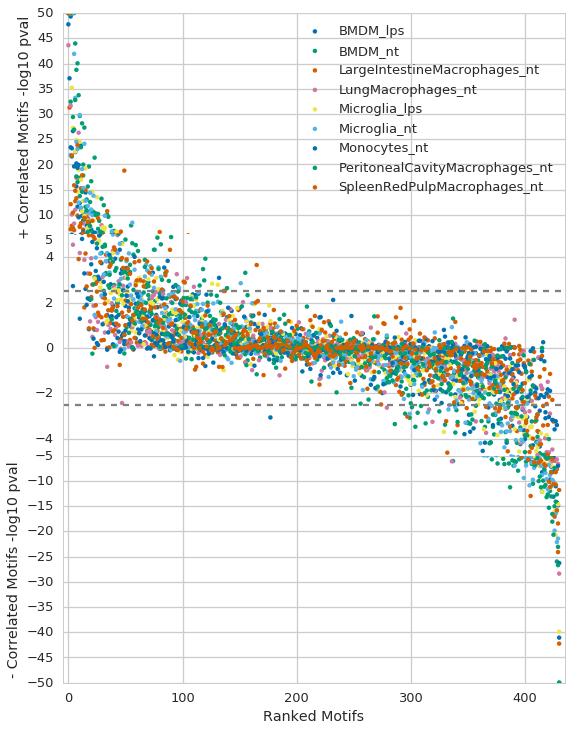

In [161]:
pseudocount = 1e-50 # set ceiling/floor for pvals
treatments = mean_pval_merged_frame.columns
pval_threshold = 10**-2.5 # position of the dashed lines
treatment_orientedPvals_dict = {}
for treatment in treatments:
    pvals = mean_pval_merged_frame[treatment]
    weights = mean_weights_merged_frame[treatment]
    # calculate logpvals and assign direction according to weight
    oriented_pvals = [np.log10(x[0] +pseudocount) if x[1] < 0 else -np.log10(x[0]+pseudocount) for x in zip(pvals, weights)]
    treatment_orientedPvals_dict[treatment] = oriented_pvals

    # create data frame and sort according to mean
frame = pd.DataFrame(treatment_orientedPvals_dict, index = mean_pval_merged_frame.index.values)
frame['mean'] = frame.mean(axis=1)
frame.sort_values('mean', ascending = False, inplace=True)
frame.drop('mean', axis=1, inplace=True)

colors = sns.color_palette('colorblind', 10)
counter = 0
with sns.axes_style('whitegrid'):
    # define subplots
    f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize = (9,12))

    for treatment in frame.columns.values:
        color = colors[counter]
        counter += 1
        # top panel
        # bottom panel
        ax1.scatter(list(range(frame.shape[0])), 
                    frame[treatment], 
                    label = treatment, 
                    c = color,
                    marker = 'o',
                    edgecolor = 'None',
                    s=20)
        
        # middle panel
        ax2.scatter(list(range(frame.shape[0])), 
                    frame[treatment], 
                    label = treatment, 
                    c = color,
                    marker = 'o',
                    edgecolor = 'None',
                    s=20)
        # bottom panel
        ax3.scatter(list(range(frame.shape[0])), 
                    frame[treatment], 
                    label = treatment, 
                    c = color,
                    marker = 'o',
                    edgecolor = 'None',
                    s=20)
        
    # scale panels
    plt.xlim(-5,435)
    ax1.set_ylim(5, 50)
    ax2.set_ylim(-5, 5)  
    ax3.set_ylim(-50,-5)
    
    # hide the spines between axes
    ax1.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    
    ax2.spines['bottom'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    
    ax1.xaxis.tick_top()
    ax1.tick_params(labeltop='off')  # don't put tick labels at the top
    
    ax3.xaxis.tick_bottom()
    
    ax2.axhline(xmin=0,xmax=200,y=-np.log10(pval_threshold+ pseudocount), c='grey', linestyle='--')
    ax2.axhline(xmin=0,xmax=200,y=np.log10(pval_threshold+ pseudocount), c='grey', linestyle='--')
    
    ax1.set_ylabel('+ Correlated Motifs -log10 pval')
    ax3.set_ylabel('- Correlated Motifs -log10 pval')
    ax1.legend()
    
    plt.xlabel('Ranked Motifs')
    f.subplots_adjust(hspace=-0.025, wspace=-0.025)

### Create Heatmap of differential motifs

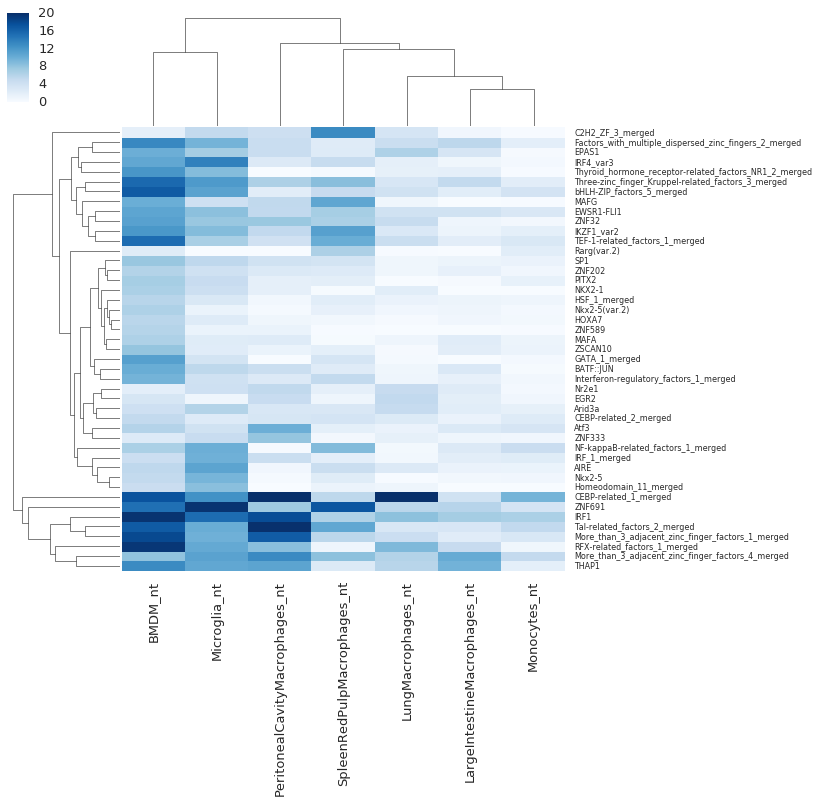

In [378]:
pseudocount = 1e-20 # pseudocount for calculating logfold change
treatments = mean_pval_merged_frame.columns
treatment_orientedPvals_dict = {}
for treatment in treatments:
    # retrieve pval and weights cooresponding to treatment
    pvals = mean_pval_merged_frame[treatment]
    weights = mean_weights_merged_frame[treatment]
    
    # calculate logpvals and assign direction according to weight
#     oriented_pvals = [np.log10(x[0] +pseudocount) if x[1] < 0 else -np.log10(x[0]+pseudocount) for x in zip(pvals, weights)]
    oriented_pvals = [-np.log10(x[0]+pseudocount) for x in zip(pvals, weights)]
    treatment_orientedPvals_dict[treatment] = oriented_pvals
# crate data frame
frame = pd.DataFrame(treatment_orientedPvals_dict, index = mean_pval_merged_frame.index.values)
# sort by mean
frame['mean'] = frame.mean(axis=1)
frame.sort_values('mean', ascending = False, inplace=True)
frame.drop('mean', axis=1, inplace=True)

# plot only motifs with log pval > 2 for at least one condition (p<0.01) and positively correlated with open chromatin
frame = frame[frame.max(axis=1) >= 5]
# frame = frame[frame.max(axis=1) <= 20]
# plot only motifs with absolute log likelihood ratio >=3
# filtered_frame = frame[((frame.max(axis=1) - frame.min(axis=1)).abs() >=2.5)]
filtered_frame = frame[((frame[['Microglia_nt', 'BMDM_nt']].max(axis=1) - \
                         frame[['Microglia_nt', 'BMDM_nt']].min(axis=1)).abs() >= 2)]
filtered_frame = filtered_frame[[x for x in filtered_frame.columns if '_nt' in x]]
# create heatmap
cg = sns.clustermap(filtered_frame,
     vmin=0,
     cmap='Blues',
     vmax=20)
plt.setp(cg.ax_heatmap.get_yticklabels(), rotation=0, size=8);

plt.savefig('./motif_heatmap.pdf', bbox_inches='tight')

## Integrate Expression Data

In [277]:
expression_frame = pd.read_csv('./20170911_AS_exons_homer.txt', sep='\t')
columns = expression_frame.columns.values
columns[0] = 'refseq'
columns[7] = 'gene'
expression_frame.columns = columns
expression_frame = expression_frame[['refseq', 'gene']+[x for x in columns if 'reads' in x]]
columns = expression_frame.columns.values
columns = [x.replace('AS_BM_microglia_12h_','').split()[0].replace('control','nt') for x in columns]
columns = [x.replace('_CD451.M', '_BMDM').replace('_CD452.M','_microglia') for x in columns]
expression_frame.columns = columns

In [570]:
mean_expression_frame = expression_frame[['refseq', 'gene']]
mean_expression_frame['microglia_nt'] = expression_frame[[x for x in expression_frame.columns if 'microglia' in x and 'nt' in x]].mean(axis=1)
mean_expression_frame['bmdm_nt'] = expression_frame[[x for x in expression_frame.columns if 'BMDM' in x and 'nt' in x]].mean(axis=1)
mean_expression_frame['microglia_lps'] = expression_frame[[x for x in expression_frame.columns if 'microglia' in x and 'LPS' in x]].mean(axis=1)
mean_expression_frame['bmdm_lps'] = expression_frame[[x for x in expression_frame.columns if 'BMDM' in x and 'LPS' in x]].mean(axis=1)
mean_expression_frame['gene'] = mean_expression_frame['gene'].str.lower()
# mean_expression_frame = mean_expression_frame[mean_expression_frame.max(axis=1) > 10]
mean_expression_frame.index = mean_expression_frame['refseq'].values

/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

In [338]:
count = 0
gene_refseq_dict = {}
for ref, genes in zip(mean_expression_frame['refseq'].values, mean_expression_frame['gene'].values):
    for g in genes.split('|')[:1]:
        if g in gene_refseq_dict:
            print(g)
            count+=1
        if not g == '-':
            gene_refseq_dict[g.lower()] = ref
print(count)

0


In [339]:
gene_refseq_dict['znf281'] = gene_refseq_dict['zfp281']

In [345]:
motif_genes_dict['BATF::JUN']= 'jun|batf|batf2|batf3'

In [348]:
motif_genes_dict['Nr1h3::Rxra'] = 'Rxra|Nr1h3'

#### Vehicle

(431, 9)
(45, 9)


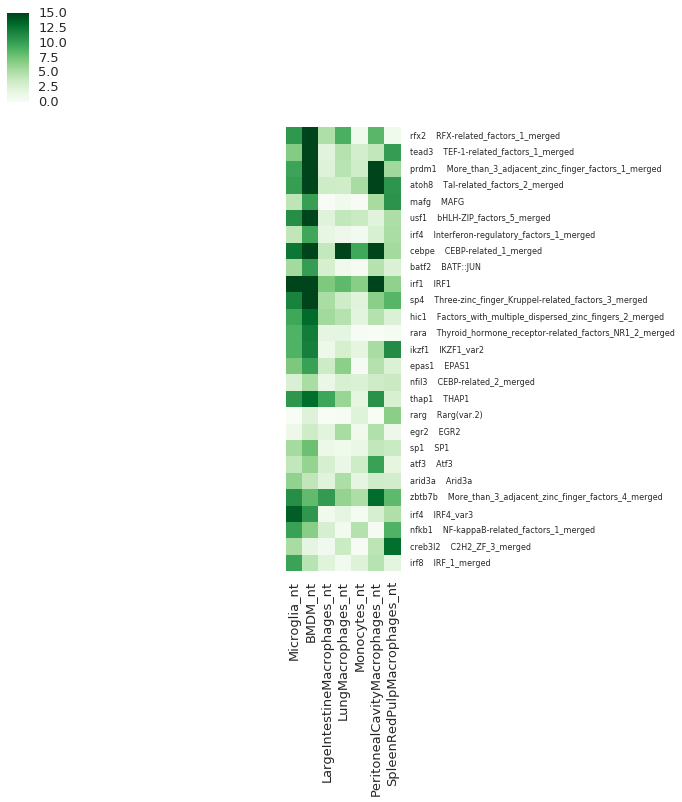

In [583]:
pseudocount = 1e-20 # pseudocount for calculating logfold change
treatments = mean_pval_merged_frame.columns
# treatment_orientedPvals_dict = {}
# for treatment in treatments:
#     # retrieve pval and weights cooresponding to treatment
#     pvals = mean_pval_merged_frame[treatment]
#     weights = mean_weights_merged_frame[treatment]
    
#     # calculate logpvals and assign direction according to weight
#     oriented_pvals = [np.log10(x[0] +pseudocount) if x[1] < 0 else -np.log10(x[0]+pseudocount) for x in zip(pvals, weights)]
#     treatment_orientedPvals_dict[treatment] = oriented_pvals
# crate data frame
# frame = pd.DataFrame(treatment_orientedPvals_dict, index = mean_pval_merged_frame.index.values)
frame = -np.log10(mean_pval_merged_frame +pseudocount)

print(frame.shape)
# plot only motifs with log pval > 2 for at least one condition (p<0.01) and positively correlated with open chromatin
frame = frame[frame.abs().max(axis=1) >= 5]

# plot only motifs with absolute log likelihood ratio >=3
# filtered_frame = frame[((frame.max(axis=1) - frame.min(axis=1)).abs() >=2.5)]
filtered_frame = frame[((frame[['Microglia_nt', 'BMDM_nt']].max(axis=1) - \
                         frame[['Microglia_nt', 'BMDM_nt']].min(axis=1)).abs() >= 2)]
print(filtered_frame.shape)
filtered_frame = filtered_frame[[x for x in filtered_frame.columns if '_nt' in x]]
filtered_frame['LLR'] = likelihood_ratios = filtered_frame['Microglia_nt'] -filtered_frame['BMDM_nt']
filtered_motifs = []
filtered_motif_gene_dict = {}
seen_genes = set()
for motif, LLR in zip(filtered_frame.index.values, filtered_frame['LLR'].values):
    genes = motif_genes_dict[motif].lower().split('|')
    filtered_genes = [g for g in genes if g in gene_refseq_dict and not g in seen_genes]
    if len(filtered_genes) > 0:
        filtered_refseqs = [gene_refseq_dict[g] for g in filtered_genes]
        bmdm_expression = mean_expression_frame.loc[filtered_refseqs, 'bmdm_nt']
        bmdm_expression.index = filtered_genes
        microglia_expression = mean_expression_frame.loc[filtered_refseqs, 'microglia_nt']
        microglia_expression.index = filtered_genes
        
        expr_frame = pd.concat([microglia_expression, bmdm_expression], axis=1)
        expr_frame = expr_frame[expr_frame.max(axis=1)>10]
        if expr_frame.shape[0] > 0:
            log2fcs = np.log2((expr_frame['microglia_nt'] + 1)/(expr_frame['bmdm_nt'] + 1))
            if LLR > 0:
                selected_gene = np.argmax(log2fcs)
#                 selected_gene = np.argmax(expr_frame['microglia_nt'])
            else:
                selected_gene = np.argmin(log2fcs)
#                 selected_gene = np.argmax(expr_frame['bmdm_nt'])
            selected_gene_bmdm = expr_frame.loc[selected_gene, 'bmdm_nt']
            selected_gene_microglia = expr_frame.loc[selected_gene, 'microglia_nt']

            filtered_motifs.append(motif)
            filtered_motif_gene_dict[motif] = selected_gene
#         print(motif, expr_frame)
filtered_frame = filtered_frame.loc[filtered_motifs,:]
filtered_motif_gene_dict['IRF_1_merged'] = 'irf8'
filtered_frame.index = [filtered_motif_gene_dict[x] + '    ' + x  for x in filtered_frame.index.values]
filtered_frame.sort_values('LLR', inplace = True)


# create heatmap
cg = sns.clustermap(filtered_frame[['Microglia_nt', 'BMDM_nt', 'LargeIntestineMacrophages_nt',
       'LungMacrophages_nt', 'Monocytes_nt', 'PeritonealCavityMacrophages_nt',
       'SpleenRedPulpMacrophages_nt']],
     vmin=0,
     cmap='Greens',
     metric = 'correlation',
#      method = 'centroid',
     row_cluster = False,
     col_cluster = False,
     square=True,
     vmax=15)
plt.setp(cg.ax_heatmap.get_yticklabels(), rotation=0, size=8);
plt.savefig('./fig_4e.pdf', bbox_inches='tight')
plt.show()
filtered_frame.to_csv('fig_4e.tsv', sep='\t', )
# filtered_motif_gene_dict

In [584]:
expression_frame.index = [x.lower().split('|')[0] for x in expression_frame['gene'].values]

In [585]:
plotting_frame = pd.DataFrame(expression_frame.iloc[:,2:].stack())
plotting_frame.columns = ['Expression']
plotting_frame['Log Expression'] = np.log2(plotting_frame['Expression'].values + 1)
plotting_frame['Treatment'] = [x[1].split('_')[0] for x in plotting_frame.index.values]
plotting_frame['Cell Type'] = [x[1].split('_')[2] for x in plotting_frame.index.values]
plotting_frame['Gene'] = [x[0] for x in plotting_frame.index.values]

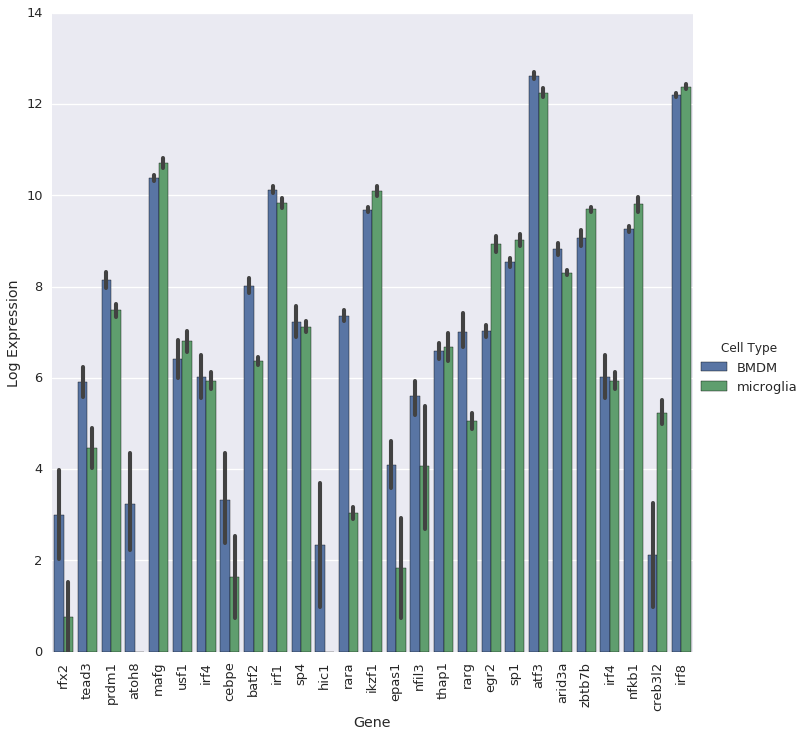

In [586]:
genes_to_plot = [x.split()[0] for x in filtered_frame.index.values]
data = plotting_frame[(plotting_frame['Gene'].isin(genes_to_plot)) &
                                     (plotting_frame['Treatment'] == 'nt')]

sns.factorplot(data = data,
               x='Gene',
               y='Log Expression',
               hue = 'Cell Type',
               kind = 'bar',
               size = 10,
               order = genes_to_plot,
               ci=68
              )
plt.xticks(rotation=90)
plt.savefig('./fig_4e_expression.pdf', bbox_inches='tight')

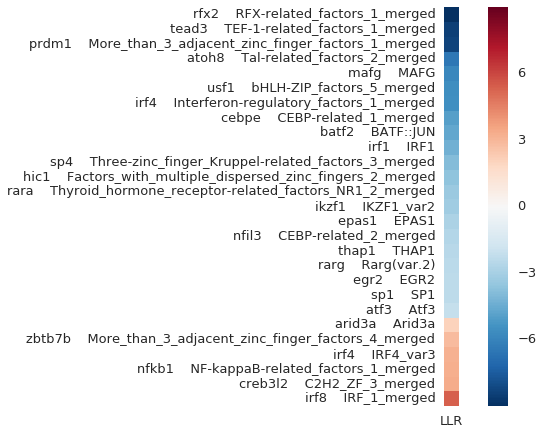

In [587]:
sns.heatmap(filtered_frame[['LLR']],
            square = True,
            )
plt.savefig('./fig_4e_llr.pdf', bbox_inches='tight')

#### KLA

(431, 9)
(50, 9)
AIRE Empty DataFrame
Columns: [microglia_lps, microglia_nt]
Index: []
EBF1 Empty DataFrame
Columns: [microglia_lps, microglia_nt]
Index: []
GATA_1_merged Empty DataFrame
Columns: [microglia_lps, microglia_nt]
Index: []
GCM_factors_1_merged Empty DataFrame
Columns: [microglia_lps, microglia_nt]
Index: []
Homeodomain_11_merged Empty DataFrame
Columns: [microglia_lps, microglia_nt]
Index: []
Homeodomain_15_merged Empty DataFrame
Columns: [microglia_lps, microglia_nt]
Index: []
Homeodomain_5_merged Empty DataFrame
Columns: [microglia_lps, microglia_nt]
Index: []
NKX2-1 Empty DataFrame
Columns: [microglia_lps, microglia_nt]
Index: []
Nkx2-5 Empty DataFrame
Columns: [microglia_lps, microglia_nt]
Index: []
Nkx2-5(var.2) Empty DataFrame
Columns: [microglia_lps, microglia_nt]
Index: []
Nr2e1 Empty DataFrame
Columns: [microglia_lps, microglia_nt]
Index: []
PLAGL1 Empty DataFrame
Columns: [microglia_lps, microglia_nt]
Index: []
THRB_var4 Empty DataFrame
Columns: [microglia_lps, m

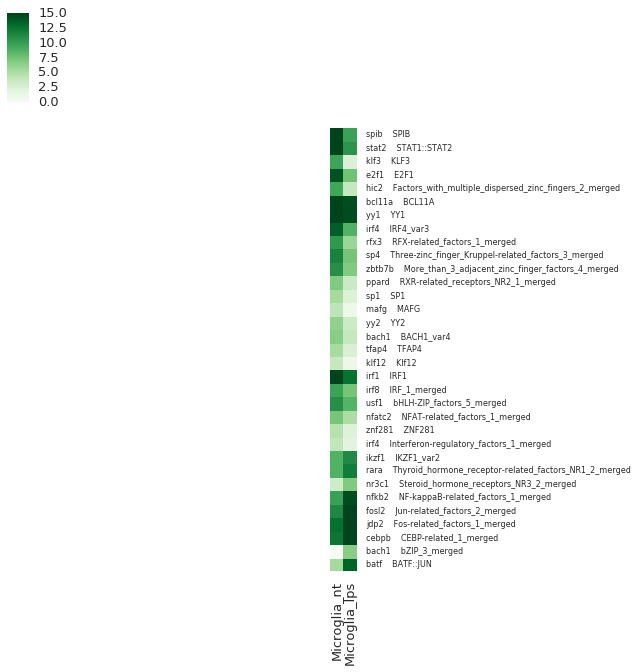

In [593]:
pseudocount = 1e-20 # pseudocount for calculating logfold change
treatments = mean_pval_merged_frame.columns
frame = -np.log10(mean_pval_merged_frame +pseudocount)

print(frame.shape)
# plot only motifs with log pval > 2 for at least one condition (p<0.01) and positively correlated with open chromatin
frame = frame[frame.abs().max(axis=1) >= 5]

# plot only motifs with absolute log likelihood ratio >=3
# filtered_frame = frame[((frame.max(axis=1) - frame.min(axis=1)).abs() >=2.5)]
filtered_frame = frame[((frame[['Microglia_nt', 'Microglia_lps']].max(axis=1) - \
                         frame[['Microglia_nt', 'Microglia_lps']].min(axis=1)).abs() >= 2)]
print(filtered_frame.shape)
filtered_frame = filtered_frame[[x for x in filtered_frame.columns if 'Microglia' in x]]
filtered_frame['LLR'] = likelihood_ratios = filtered_frame['Microglia_lps'] - filtered_frame['Microglia_nt']
filtered_motifs = []
filtered_motif_gene_dict = {}
seen_genes = set()
for motif, LLR in zip(filtered_frame.index.values, filtered_frame['LLR'].values):
    genes = motif_genes_dict[motif].lower().split('|')
    filtered_genes = [g for g in genes if g in gene_refseq_dict and not g in seen_genes]
    if len(filtered_genes) > 0:
        filtered_refseqs = [gene_refseq_dict[g] for g in filtered_genes]
        lps_expression = mean_expression_frame.loc[filtered_refseqs, 'microglia_lps']
        lps_expression.index = filtered_genes
        nt_expression = mean_expression_frame.loc[filtered_refseqs, 'microglia_nt']
        nt_expression.index = filtered_genes
        
        expr_frame = pd.concat([lps_expression, nt_expression], axis=1)
        expr_frame = expr_frame[expr_frame.max(axis=1)>10]
        if expr_frame.shape[0] > 0:
            log2fcs = np.log2((expr_frame['microglia_lps'] + 1)/(expr_frame['microglia_nt'] + 1))
            if LLR > 0:
                selected_gene = np.argmax(log2fcs)
#                 selected_gene = np.argmax(expr_frame['Microglia_nt'])
            else:
                selected_gene = np.argmin(log2fcs)
#                 selected_gene = np.argmax(expr_frame['microglia_nt'])
            selected_gene_lps = expr_frame.loc[selected_gene, 'microglia_lps']
            selected_gene_nt = expr_frame.loc[selected_gene, 'microglia_nt']

            filtered_motifs.append(motif)
            filtered_motif_gene_dict[motif] = selected_gene
        else:
            print(motif, expr_frame)
filtered_frame = filtered_frame.loc[filtered_motifs,:]
filtered_motif_gene_dict['IRF_1_merged'] = 'irf8'
filtered_frame.index = [filtered_motif_gene_dict[x] + '    ' + x  for x in filtered_frame.index.values]
filtered_frame.sort_values('LLR', inplace = True)


# create heatmap
cg = sns.clustermap(filtered_frame[['Microglia_nt', 'Microglia_lps']],
     vmin=0,
     cmap='Greens',
     metric = 'correlation',
#      method = 'centroid',
     row_cluster = False,
     col_cluster = False,
     square=True,
     vmax=15)
plt.setp(cg.ax_heatmap.get_yticklabels(), rotation=0, size=8);
plt.savefig('./fig_6b.pdf', bbox_inches='tight')
plt.show()
filtered_frame.to_csv('fig_6b.tsv', sep='\t', )
# filtered_motif_gene_dict

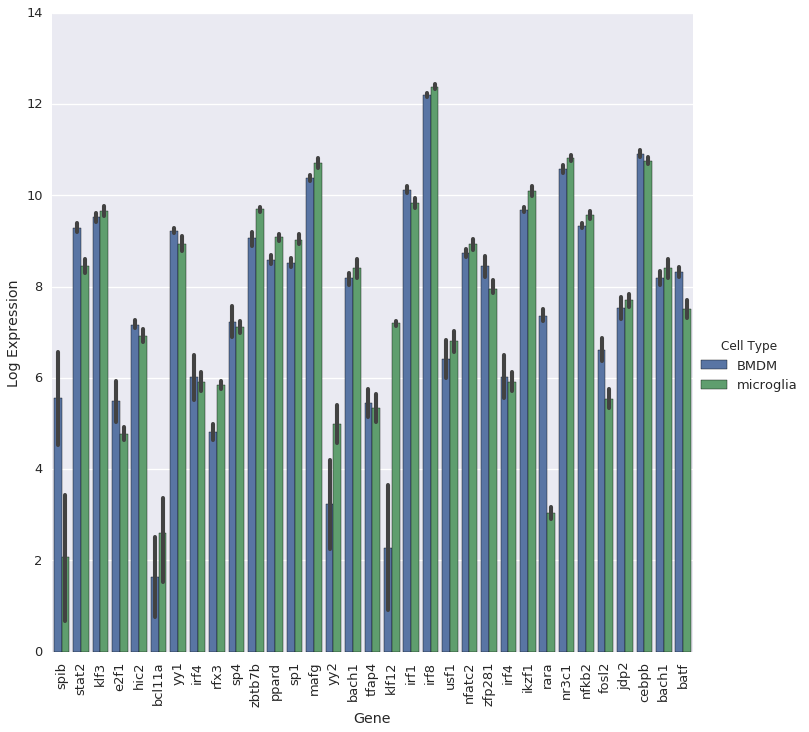

In [589]:
genes_to_plot = [x.split()[0].replace('znf281', 'zfp281') for x in filtered_frame.index.values]
data = plotting_frame[(plotting_frame['Gene'].isin(genes_to_plot)) &
                                     (plotting_frame['Treatment'] == 'nt')]

sns.factorplot(data = data,
               x='Gene',
               y='Log Expression',
               hue = 'Cell Type',
               kind = 'bar',
               size = 10,
               order = genes_to_plot,
               ci=68
              )
plt.xticks(rotation=90)
plt.savefig('./fig_6b_expression.pdf', bbox_inches='tight')

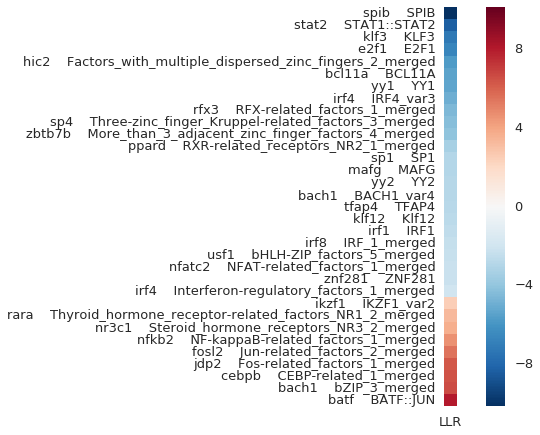

In [590]:
sns.heatmap(filtered_frame[['LLR']],
            square = True,
            )
plt.savefig('./fig_6b_llr.pdf', bbox_inches='tight')

### Create Table of top positively correlated motifs

In [172]:
pval_threshold = 1e-2
positive_motif_set = None
for treatment in treatments:
    pvals = mean_pval_merged_frame[treatment]
    weights = mean_weights_merged_frame[treatment]


    significant_positive_motifs = weights[weights>0].index.intersection(pvals[pvals < pval_threshold].index)
    if positive_motif_set == None:
        positive_motif_set = set(significant_positive_motifs)
    else:
        positive_motif_set = positive_motif_set.intersection(set(significant_positive_motifs)) 
data = mean_pval_merged_frame.loc[sorted(positive_motif_set), :]

data = data+1e-50

positive_table = data[[]]
positive_table['Motif'] = data.index.values
positive_table['Mean p-val'] = data.mean(axis=1)
positive_table.sort_values(by='Mean p-val', inplace = True)
positive_table

/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

Motif  \
CTCF                                                                                             CTCF   
Ets-related_factors_3_merged                                             Ets-related_factors_3_merged   
CEBPA                                                                                           CEBPA   
IRF1                                                                                             IRF1   
Jun-related_factors_2_merged                                             Jun-related_factors_2_merged   
ETV6                                                                                             ETV6   
BCL11A                                                                                         BCL11A   
CTCFL                                                                                           CTCFL   
Runt-related_factors_2_merged                                           Runt-related_factors_2_merged   
Ets-related_factors_1_merged                                             Ets-related_factors_1_merged   
STAT1::STAT2                                                                             STAT1::STAT2   
CEBP-related_1_merged                                                           CEBP-related_1_merged   
Regulators_of_differentiation_1_merged                         Regulators_of_differentiation_1_merged   
Fos-related_factors_1_merged                                             Fos-related_factors_1_merged   
Hairy-related_factors_1_merged                                         Hairy-related_factors_1_merged   
Three-zinc_finger_Kruppel-related_factors_3_merged  Three-zinc_finger_Kruppel-related_factors_3_me...   
bHLH-ZIP_factors_5_merged                                                   bHLH-ZIP_factors_5_merged   

                                                      Mean p-val  
CTCF                                                2.613280e-45  
Ets-related_factors_3_merged                        5.965433e-33  
CEBPA                                               8.026253e-09  
IRF1                                                8.512096e-08  
Jun-related_factors_2_merged                        8.799185e-08  
ETV6                                                9.585668e-08  
BCL11A                                              3.567303e-07  
CTCFL                                               3.658670e-07  
Runt-related_factors_2_merged                       5.085758e-07  
Ets-related_factors_1_merged                        9.142742e-07  
STAT1::STAT2                                        2.797744e-06  
CEBP-related_1_merged                               1.401515e-05  
Regulators_of_differentiation_1_merged              2.136455e-04  
Fos-related_factors_1_merged                        2.884166e-04  
Hairy-related_factors_1_merged                      3.939119e-04  
Three-zinc_finger_Kruppel-related_factors_3_merged  7.928047e-04  
bHLH-ZIP_factors_5_merged                           1.461417e-03

## PCA

In [189]:
import sklearn

import sklearn.preprocessing

import sklearn.decomposition

In [547]:
weights_data = mean_weights_merged_frame[[x for x in mean_weights_merged_frame.columns if not 'lps' in x]]
pval_data =  mean_pval_merged_frame[[x for x in mean_pval_merged_frame.columns if not 'lps' in x]]


In [548]:
significant_motifs = pval_data[pval_data.min(axis=1) < 10e-0].index.values
weights_data = weights_data.loc[significant_motifs,:]
pval_data = pval_data.loc[significant_motifs,:]

In [549]:
pca_model = sklearn.decomposition.PCA(n_components=2)

In [550]:
scaler = sklearn.preprocessing.StandardScaler()
standardized_data = scaler.fit_transform(weights_data)

In [551]:
standardized_data.mean(axis=0)

array([ 1.03036940e-17,  2.67896043e-17, -1.03036940e-18,  8.24295517e-18,
       -1.64859103e-17,  8.24295517e-18,  2.67896043e-17])

In [552]:
transformed_coordinates = pca_model.fit_transform(standardized_data.T)

In [553]:
pca_model.explained_variance_ratio_

array([0.24196342, 0.21849366])

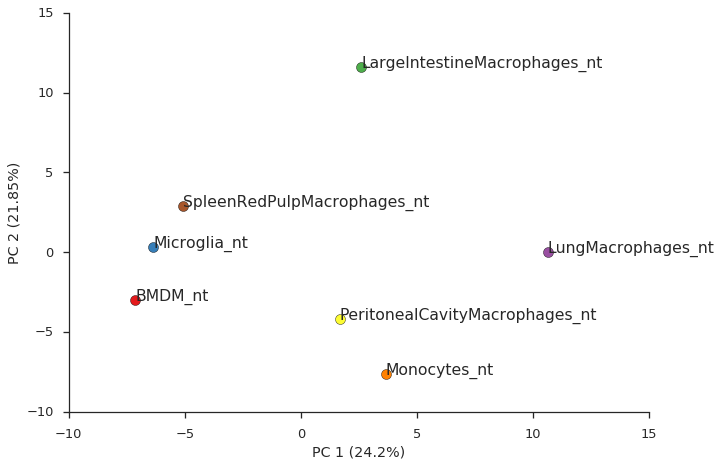

In [555]:
with sns.axes_style('ticks'):
    for tc, label, color in zip(transformed_coordinates, weights_data.columns.values, sns.color_palette('Set1', len(weights_data.columns))):
        plt.scatter(tc[0], tc[1], c=color, s=100)
        plt.annotate(xy=tc, s=label)
        plt.xlabel('PC 1 (' + str(np.round(pca_model.explained_variance_ratio_[0]*100,2)) + '%)')
        plt.ylabel('PC 2 (' + str(np.round(pca_model.explained_variance_ratio_[1]*100,2)) + '%)')
sns.despine()
plt.savefig('./nt_cellType_pca.pdf', bbox_inches='tight')